### Data preparation and Exploration

In [1]:
import pandas as pd 
import numpy as np
import json
import re
from tqdm import tqdm,tqdm_gui
from tqdm._tqdm_notebook import tqdm_notebook

In [2]:
PATH = './data/'

In [3]:
with open(PATH+'review.json') as f:
    review_data = pd.DataFrame(json.loads(line) for line in f)

FileNotFoundError: [Errno 2] No such file or directory: './data/review.json'

In [ ]:
with open(PATH+'business.json') as f:
    business_data = pd.DataFrame(json.loads(line) for line in f)

In [ ]:
rest_biz = business_data[business_data['categories'].apply(str).str.contains('Restaurants')]

In [ ]:
rest_biz = rest_biz.drop(columns=['stars'])

In [ ]:
rest_biz.sort_values(by='review_count',ascending=False,inplace=True)

In [29]:
rest_biz.groupby(by=['state'])['review_count'].sum().sort_values(ascending=False)

state
NV     949953
AZ     837216
ON     414411
NC     180487
OH     154726
PA     143283
QC      98978
WI      69050
BW      24934
EDH     23747
IL      22186
SC       5981
MLN      1101
HLD       589
C         168
ELN       117
FIF       110
NYK       101
WLN        87
NY         73
NI         58
WA         40
01         24
PKN        24
ST         24
ESX        11
BY         10
KHL         7
RCC         7
XGL         6
3           5
HH          4
CA          4
WHT         4
ABE         3
ZET         3
Name: review_count, dtype: int64

In [30]:
preprocessed_data = rest_biz.merge(review_data,how='inner')
preprocessed_data = preprocessed_data[preprocessed_data['state'].isin(['NV'])]

In [31]:
preprocessed_data.head()

address                                         attributes  \
0  3655 Las Vegas Blvd S  {'Alcohol': 'full_bar', 'HasTV': False, 'Noise...   
1  3655 Las Vegas Blvd S  {'Alcohol': 'full_bar', 'HasTV': False, 'Noise...   
2  3655 Las Vegas Blvd S  {'Alcohol': 'full_bar', 'HasTV': False, 'Noise...   
3  3655 Las Vegas Blvd S  {'Alcohol': 'full_bar', 'HasTV': False, 'Noise...   
4  3655 Las Vegas Blvd S  {'Alcohol': 'full_bar', 'HasTV': False, 'Noise...   

              business_id                                         categories  \
0  4JNXUYY8wbaaDmk3BPzlWw  [French, Steakhouses, Breakfast & Brunch, Rest...   
1  4JNXUYY8wbaaDmk3BPzlWw  [French, Steakhouses, Breakfast & Brunch, Rest...   
2  4JNXUYY8wbaaDmk3BPzlWw  [French, Steakhouses, Breakfast & Brunch, Rest...   
3  4JNXUYY8wbaaDmk3BPzlWw  [French, Steakhouses, Breakfast & Brunch, Rest...   
4  4JNXUYY8wbaaDmk3BPzlWw  [French, Steakhouses, Breakfast & Brunch, Rest...   

        city                                              hours  is_open  \
0  Las Vegas  {'Monday': '7:00-23:00', 'Tuesday': '7:00-23:0...        1   
1  Las Vegas  {'Monday': '7:00-23:00', 'Tuesday': '7:00-23:0...        1   
2  Las Vegas  {'Monday': '7:00-23:00', 'Tuesday': '7:00-23:0...        1   
3  Las Vegas  {'Monday': '7:00-23:00', 'Tuesday': '7:00-23:0...        1   
4  Las Vegas  {'Monday': '7:00-23:00', 'Tuesday': '7:00-23:0...        1   

    latitude   longitude          name           ...           review_count  \
0  36.112827 -115.172581  Mon Ami Gabi           ...                   6979   
1  36.112827 -115.172581  Mon Ami Gabi           ...                   6979   
2  36.112827 -115.172581  Mon Ami Gabi           ...                   6979   
3  36.112827 -115.172581  Mon Ami Gabi           ...                   6979   
4  36.112827 -115.172581  Mon Ami Gabi           ...                   6979   

  state  cool        date  funny               review_id  stars  \
0    NV     0  2011-02-22      0  WE9eUYf5EV8AxJjl8QZRtA      5   
1    NV     0  2015-04-15      0  7Fl41hKa0wjO3TlvHKD3lw      4   
2    NV     0  2013-11-11      0  Jm4iOfsltS3T59puoV6r8Q      5   
3    NV     3  2015-12-28      2  m6lwvXPCdpKHVp05Bjkhlw      5   
4    NV     0  2015-09-16      0  nkb40j7kBe2qAci1xpyd3g      5   

                                                text  useful  \
0  Very chic. Although, the menu items doesnt SCR...       0   
1  Cute french bistro with great service. I came ...       1   
2  The food is very good, the prices fair and the...       0   
3  One of my favorite go-to brunch spots on the L...       8   
4  Simply amazing steak and frites. Got the blue ...       0   

                  user_id  
0  K6FpHYwcJYznoXXu8ySZHw  
1  3SGQKsO1J-jcRIp3WNxCeA  
2  LPT8XlpXlHGAp0Ri4Hu4Rw  
3  3NnPbhmv_vEfPTBp2pnn9Q  
4  xl4rsQqpibUNhR8Jqxp4OQ  

[5 rows x 22 columns]

In [32]:
date_sorted = preprocessed_data.sort_values(by='date',ascending=False)

In [33]:
data_20150101 = date_sorted[date_sorted['date']>'2017-01-01']

In [34]:
data_20150101 = data_20150101.reset_index().drop('index',axis=1)

In [35]:
data_20150101.groupby(by=['state'])['state'].count()

state
NV    126225
Name: state, dtype: int64

In [36]:
data_20150101.shape

(126225, 22)

In [39]:
preprocessed_dataviz = data_20150101.loc[:,['business_id','user_id','text']]

In [40]:
# The data for this analysis include restaurant reviews across two states Nevada and Arizona for the past 2.5 years

In [41]:
preprocessed_dataviz.to_feather('./data/preprocessed_data')

### Tokenization 

In [2]:
import pandas as pd
import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim import models,corpora
from tqdm import tqdm,tqdm_gui
from tqdm._tqdm_notebook import tqdm_notebook

In [3]:
preprocessed_data = pd.read_feather('./data/preprocessed_data')
preprocessed_data = preprocessed_data.reset_index().drop('index',axis=1)

In [4]:
nlp = spacy.load('en')

1. Convert the reviews into sentence streams
2. Construct a bigram model
3. Using a bigram model, construct 

Here, we want to create a stream of sentences. And use that to create our bigram model.

In [5]:
doc = nlp.pipe(preprocessed_data['text'],n_threads=-1)
text_out = []
for review in tqdm(doc):
    review_sent = []
    for sent in review.sents:
        sentence = []
        for token in sent:        
            if token.is_alpha and token.is_stop == False:
                lemma = token.lemma_
                sentence.append(lemma)
        review_sent.append(sentence)
    text_out.append(review_sent)

126225it [55:08, 38.15it/s]


In [6]:
total_text = []
for text in text_out:
    total_text +=text
common_terms = ['by' ,'in', 'of' ,'on' ,'or', 'to','the']
bigram_model = Phrases(total_text,scoring='npmi',common_terms=common_terms,threshold=0.5,min_count=100)

1. Words at review level

In [7]:
processed_review =[]
for text in text_out:
    review =[]
    for t in text:
        review +=t
    processed_review.append(review)
processed_bigram_reviews = [ bigram_model[review] for review in tqdm(processed_review)]

  0%|          | 0/126225 [00:00<?, ?it/s]/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
100%|██████████| 126225/126225 [00:42<00:00, 2980.36it/s]


In [8]:
processed_bigram_reviews[100]

['ichiza',
 'good',
 'the',
 'thing',
 '-PRON-',
 'like',
 'wagyu',
 'yakitori',
 '-PRON-',
 'order',
 'yakitori',
 'chicken',
 'thigh',
 'wagyu',
 'tongue',
 'ok',
 'wagyu_beef',
 'good',
 'pork_belly',
 'meh',
 'duck',
 'meh',
 'grill',
 'octopus',
 'ok',
 '-PRON-',
 'will',
 'come']

In [9]:
# filtering for stop words
from spacy.lang.en.stop_words import STOP_WORDS 
STOP_WORDS

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'g

In [10]:
final_bigrams = []
stopwordlist = list(STOP_WORDS)
for r in tqdm(processed_bigram_reviews):
    review = []
    for word in r:
        if word not in stopwordlist and word != '-PRON-':
            review.append(word)
    final_bigrams.append(review)
            
        

100%|██████████| 126225/126225 [00:24<00:00, 5101.75it/s]


In [11]:
final_bigrams[100]

['ichiza',
 'good',
 'thing',
 'like',
 'wagyu',
 'yakitori',
 'order',
 'yakitori',
 'chicken',
 'thigh',
 'wagyu',
 'tongue',
 'ok',
 'wagyu_beef',
 'good',
 'pork_belly',
 'meh',
 'duck',
 'meh',
 'grill',
 'octopus',
 'ok',
 'come']

In [12]:
dictionary = corpora.Dictionary(final_bigrams)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tqdm(final_bigrams)]

100%|██████████| 126225/126225 [00:05<00:00, 22110.95it/s]


In [13]:
import logging
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.DEBUG)

In [25]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(5,50,5)
for num_topics in tqdm(num_topics_list):
    lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=final_bigrams, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')



  0%|          | 0/9 [00:00<?, ?it/s]INFO : using symmetric alpha at 0.2
INFO : using symmetric eta at 0.2
INFO : using serial LDA version on this node
INFO : running online LDA training, 5 topics, 20 passes over the supplied corpus of 126225 documents, updating every 140000 documents, evaluating every ~126225 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 35 processes

DEBUG : worker process entering E-step loop

DEBUG : getting a new job

DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job

DEBUG : getting a new job
DEBUG : worker process entering E-step loop

DEBUG : worker process entering E-step loop
DEBUG : getting a new job

DEBUG : worker process entering E-step loop
DEBUG : getting a new job

DEBUG : worker process entering E-step loop
DEBUG : getting a new job

DEBUG : worker process entering E-step loop

DEBUG : getting a new job
DEBUG :

DEBUG : processing chunk #21 of 4000 documents
INFO : PROGRESS: pass 0, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 0, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 0, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1222/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing i

INFO : PROGRESS: pass 1, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 1, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 1, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 1, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 1, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #4400

DEBUG : processing chunk #28 of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : 1822/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 1865/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1821/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1816/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1862/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEB

INFO : PROGRESS: pass 2, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1954/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #14 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1886/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1904/4000 documents converged within 50

INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
DEBUG : processing chunk #0 of 4000 documents
INFO : PROGRESS: pass 3, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #32000/126

DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1993/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2015/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 2031/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : 1998/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2024/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a 

INFO : PROGRESS: pass 4, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 4, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 4, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 4, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 4, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 4, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DE

INFO : topic #4 (0.200): 0.024*"good" + 0.021*"food" + 0.017*"great" + 0.012*"order" + 0.010*"delicious" + 0.010*"service" + 0.009*"place" + 0.009*"time" + 0.009*"chicken" + 0.009*"try"
INFO : topic diff=0.097724, rho=0.165394
DEBUG : bound: at document #0
INFO : -7.486 per-word bound, 179.3 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 5, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 5, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 5, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : P

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2092/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2065/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2120/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2113/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : processing chunk

INFO : PROGRESS: pass 6, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 6, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 6, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 6, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 6, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 6, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 6, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DE

INFO : topic #2 (0.200): 0.019*"food" + 0.018*"order" + 0.017*"good" + 0.015*"come" + 0.012*"time" + 0.011*"place" + 0.008*"like" + 0.007*"restaurant" + 0.006*"ask" + 0.006*"try"
INFO : topic #3 (0.200): 0.026*"good" + 0.018*"food" + 0.015*"place" + 0.012*"service" + 0.012*"great" + 0.011*"come" + 0.010*"order" + 0.010*"time" + 0.009*"try" + 0.008*"like"
INFO : topic #4 (0.200): 0.024*"good" + 0.021*"food" + 0.017*"great" + 0.012*"order" + 0.010*"delicious" + 0.010*"service" + 0.009*"place" + 0.009*"chicken" + 0.009*"try" + 0.009*"time"
INFO : topic diff=0.085099, rho=0.161047
DEBUG : bound: at document #0
INFO : -7.467 per-word bound, 177.0 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #

DEBUG : 2147/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2216/4000 documents converged within 50 iterations
DEBUG : 2197/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2172/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2148/4000 documents converged within 50 iterations
DEBUG : 

DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 8, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 8, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 8, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 8, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 8, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 8, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 8, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 doc

DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
INFO : topic #0 (0.200): 0.018*"great" + 0.016*"good" + 0.015*"food" + 0.014*"place" + 0.010*"order" + 0.009*"come" + 0.009*"service" + 0.009*"time" + 0.008*"like" + 0.008*"love"
INFO : topic #1 (0.200): 0.022*"food" + 0.019*"good" + 0.017*"order" + 0.017*"come" + 0.014*"place" + 0.012*"time" + 0.010*"service" + 0.010*"like" + 0.009*"wait" + 0.009*"pizza"
INFO : topic #2 (0.200): 0.019*"order" + 0.019*"food" + 0.016*"good" + 0.015*"come" + 0.013*"time" + 0.011*"place" + 0.008*"like" + 0.006*"sandwich" + 0.006*"location" + 0.006*"ask"
INFO : topic #3 (0.200): 0.027*"good" + 0.019*"food" + 0.015*"place" + 0.013*"great" + 0.012*"service" + 0.011*"come" + 0.010*"order" + 0.010*"time" + 0.009*"try" + 0.008*"amazing"
INFO : topic #4 (0.200): 0.024*"good" + 0.021*"food" + 0.017*"great" + 0.012*"order" + 0.010*"delicious" + 0.010*"service" + 0.009*"place" + 0.009*"chicken" + 0.009*"try" + 0.009*"restaurant"
INFO : topic diff=

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2270/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2232/4000 documents converged within 50 iterations
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #28 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2258/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #29 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2322/4000 documents conver

INFO : PROGRESS: pass 10, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 10, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 10, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 10, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 10, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 10, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 10, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 10, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 10, dispatched chunk #26

DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2333/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2234/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2190/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.200): 0.018*"great" + 0.016*"good" + 0.015*"place" + 0.015*"food" + 0.010*"order" + 0.009*"come" + 0.009*"burger" + 0.008*"service" + 0.008*"time" + 0.008*"like"
INFO : topic #1 (0.200): 0.022*"food" + 0.018*"good" + 0.017*"order" + 0.016*"come" + 0.014*"place" + 0.012*"time" + 0.010*"service" + 0.010*"wait" + 0.009*"like" + 0.009*"pizza"
INFO : topic #2 (0.200): 0.020*"order" + 0.018*"food" + 0.015*"good" + 0.014*"come

DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2331/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2366/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2393/4000 documents converged within 

INFO : PROGRESS: pass 12, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 12, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 12, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 12, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 12, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 12, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 12, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 12, dispatched chunk #23 = d

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2369/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2414/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2417/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2421/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2350/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2290/4000 documents converged within 50 iterations
DEBUG : processed chunk

DEBUG : 2451/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2486/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2474/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2432/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #24 of 400

INFO : PROGRESS: pass 14, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 14, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 14, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 14, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 14, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 14, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 14, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 14, dispatched chunk #19 = d

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2465/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 2543/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1424/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2525/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2495/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2493/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2501/4000 docum

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2533/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2582/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2599/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2561/4000 documents converged within 50 iterations
DEBUG : processing chunk #18 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBU

DEBUG : result put
DEBUG : getting a new job
DEBUG : 2659/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2663/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 1478/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2599/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2599/4000 documents converged within 50 iterations
DEBUG : 2659/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2622/4000 documents converged within 50 iterations
DEBUG : 

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2669/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2704/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2646/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2580/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a

INFO : PROGRESS: pass 18, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 18, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 18, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 18, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 18, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 18, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 18, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
DEBUG : processing chunk #2 of 4000 documents
DEBUG : per

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2672/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2686/4000 documents converged within 50 iterations
DEBUG : 2721/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 2710/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2786/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2651/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2699/4000 docum

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2760/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2736/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2695/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on

INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats from 3000 documents
INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO : CorpusAccumulator accumulated stats from 12000 documents
INFO : CorpusAccumulator accumulated stats from 13000 documents
INFO : CorpusAccumulator accumulated stats from 14000 documents
INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 1

INFO : using ParallelWordOccurrenceAccumulator(processes=35, batch_size=64) to estimate probabilities from sliding windows
DEBUG : completed batch 0; 64 documents processed (96 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (251 virtual)
DEBUG : completed batch 0; 64 documents processed (218 virtual)
DEBUG : completed batch 1; 128 documents processed (155 virtual)
DEBUG : completed batch 0; 64 documents processed (372 virtual)
DEBUG : completed batch 0; 64 documents processed (90 virtual)
DEBUG : completed batch 1; 128 documents processed (451 virtual)
DEBUG : completed batch 0; 64 documents processed (303 virtual)
DEBUG : completed batch 1; 128 documents processed (160 virtual)
DEBUG : completed batch 0; 64 documents processed (143 virtual)
DEBUG : completed batch 1; 128 documents processed (478 virtual)
DEBUG : completed batch 1; 128 documents processed (154 virtual)
DEBUG : completed batch 0; 64 documents pro

DEBUG : completed batch 6; 448 documents processed (1596 virtual)
DEBUG : completed batch 2; 192 documents processed (466 virtual)
DEBUG : completed batch 4; 320 documents processed (748 virtual)
DEBUG : completed batch 2; 192 documents processed (517 virtual)
DEBUG : completed batch 7; 512 documents processed (1664 virtual)
DEBUG : completed batch 2; 192 documents processed (282 virtual)
DEBUG : completed batch 2; 192 documents processed (423 virtual)
DEBUG : completed batch 2; 192 documents processed (807 virtual)
DEBUG : completed batch 2; 192 documents processed (558 virtual)
DEBUG : completed batch 2; 192 documents processed (520 virtual)
DEBUG : completed batch 2; 192 documents processed (325 virtual)
DEBUG : completed batch 6; 448 documents processed (911 virtual)
DEBUG : completed batch 2; 192 documents processed (510 virtual)
DEBUG : completed batch 4; 320 documents processed (815 virtual)
DEBUG : completed batch 2; 192 documents processed (550 virtual)
DEBUG : completed batch

DEBUG : completed batch 5; 384 documents processed (810 virtual)
DEBUG : completed batch 9; 640 documents processed (1785 virtual)
DEBUG : completed batch 6; 448 documents processed (1421 virtual)
DEBUG : completed batch 10; 704 documents processed (1735 virtual)
DEBUG : completed batch 7; 512 documents processed (1323 virtual)
DEBUG : completed batch 6; 448 documents processed (1020 virtual)
DEBUG : completed batch 8; 576 documents processed (1489 virtual)
DEBUG : completed batch 6; 448 documents processed (1299 virtual)
DEBUG : completed batch 8; 576 documents processed (1441 virtual)
DEBUG : completed batch 6; 448 documents processed (1166 virtual)
DEBUG : completed batch 9; 640 documents processed (1502 virtual)
DEBUG : completed batch 8; 576 documents processed (1477 virtual)
DEBUG : completed batch 6; 448 documents processed (1240 virtual)
DEBUG : completed batch 6; 448 documents processed (895 virtual)
DEBUG : completed batch 6; 448 documents processed (1039 virtual)
DEBUG : com

DEBUG : completed batch 9; 640 documents processed (1854 virtual)
DEBUG : completed batch 10; 704 documents processed (2113 virtual)
DEBUG : completed batch 11; 768 documents processed (2100 virtual)
DEBUG : completed batch 11; 768 documents processed (2137 virtual)
DEBUG : completed batch 9; 640 documents processed (1746 virtual)
DEBUG : completed batch 9; 640 documents processed (2623 virtual)
DEBUG : completed batch 9; 640 documents processed (1677 virtual)
DEBUG : completed batch 9; 640 documents processed (1529 virtual)
DEBUG : completed batch 13; 896 documents processed (2336 virtual)
DEBUG : completed batch 12; 832 documents processed (2056 virtual)
DEBUG : completed batch 9; 640 documents processed (1978 virtual)
DEBUG : completed batch 10; 704 documents processed (2486 virtual)
DEBUG : completed batch 9; 640 documents processed (1854 virtual)
DEBUG : completed batch 11; 768 documents processed (2312 virtual)
DEBUG : completed batch 12; 832 documents processed (2160 virtual)
DE

DEBUG : completed batch 13; 896 documents processed (2980 virtual)
DEBUG : completed batch 13; 896 documents processed (2423 virtual)
DEBUG : completed batch 13; 896 documents processed (2550 virtual)
DEBUG : completed batch 17; 1152 documents processed (3018 virtual)
DEBUG : completed batch 14; 960 documents processed (3015 virtual)
DEBUG : completed batch 17; 1152 documents processed (3343 virtual)
DEBUG : completed batch 18; 1216 documents processed (3082 virtual)
DEBUG : completed batch 12; 832 documents processed (2285 virtual)
DEBUG : completed batch 15; 1024 documents processed (3174 virtual)
DEBUG : completed batch 13; 896 documents processed (3257 virtual)
DEBUG : completed batch 16; 1088 documents processed (2617 virtual)
DEBUG : completed batch 14; 960 documents processed (2614 virtual)
DEBUG : completed batch 12; 832 documents processed (2479 virtual)
DEBUG : completed batch 18; 1216 documents processed (3871 virtual)
DEBUG : completed batch 14; 960 documents processed (304

DEBUG : completed batch 16; 1088 documents processed (3327 virtual)
DEBUG : completed batch 15; 1024 documents processed (3200 virtual)
DEBUG : completed batch 14; 960 documents processed (3351 virtual)
DEBUG : completed batch 16; 1088 documents processed (2849 virtual)
DEBUG : completed batch 16; 1088 documents processed (3874 virtual)
DEBUG : completed batch 16; 1088 documents processed (3926 virtual)
DEBUG : completed batch 17; 1152 documents processed (3900 virtual)
DEBUG : completed batch 19; 1280 documents processed (3201 virtual)
DEBUG : completed batch 17; 1152 documents processed (3318 virtual)
DEBUG : completed batch 20; 1344 documents processed (3736 virtual)
DEBUG : completed batch 17; 1152 documents processed (3512 virtual)
DEBUG : completed batch 20; 1344 documents processed (3069 virtual)
DEBUG : completed batch 16; 1088 documents processed (2875 virtual)
DEBUG : completed batch 16; 1088 documents processed (3112 virtual)
DEBUG : completed batch 16; 1088 documents proces

DEBUG : completed batch 24; 1600 documents processed (4189 virtual)
DEBUG : completed batch 19; 1280 documents processed (4736 virtual)
DEBUG : completed batch 22; 1472 documents processed (4114 virtual)
DEBUG : completed batch 20; 1344 documents processed (4712 virtual)
DEBUG : completed batch 19; 1280 documents processed (4148 virtual)
DEBUG : completed batch 23; 1536 documents processed (4704 virtual)
DEBUG : completed batch 20; 1344 documents processed (4670 virtual)
DEBUG : completed batch 20; 1344 documents processed (3931 virtual)
DEBUG : completed batch 21; 1408 documents processed (4443 virtual)
DEBUG : completed batch 22; 1472 documents processed (4055 virtual)
DEBUG : completed batch 21; 1408 documents processed (4692 virtual)
DEBUG : completed batch 22; 1472 documents processed (3650 virtual)
DEBUG : completed batch 19; 1280 documents processed (4212 virtual)
DEBUG : completed batch 24; 1600 documents processed (3809 virtual)
DEBUG : completed batch 19; 1280 documents proce

DEBUG : completed batch 24; 1600 documents processed (5383 virtual)
DEBUG : completed batch 22; 1472 documents processed (4981 virtual)
DEBUG : completed batch 24; 1600 documents processed (4429 virtual)
DEBUG : completed batch 26; 1728 documents processed (4533 virtual)
DEBUG : completed batch 24; 1600 documents processed (5328 virtual)
DEBUG : completed batch 28; 1856 documents processed (4751 virtual)
DEBUG : completed batch 28; 1856 documents processed (5067 virtual)
DEBUG : completed batch 28; 1856 documents processed (5230 virtual)
DEBUG : completed batch 25; 1664 documents processed (5798 virtual)
DEBUG : completed batch 23; 1536 documents processed (5514 virtual)
DEBUG : completed batch 24; 1600 documents processed (4521 virtual)
DEBUG : completed batch 23; 1536 documents processed (5346 virtual)
DEBUG : completed batch 27; 1792 documents processed (5240 virtual)
DEBUG : completed batch 23; 1536 documents processed (4596 virtual)
DEBUG : completed batch 24; 1600 documents proce

DEBUG : completed batch 26; 1728 documents processed (5856 virtual)
DEBUG : completed batch 26; 1728 documents processed (4748 virtual)
DEBUG : completed batch 26; 1728 documents processed (5419 virtual)
DEBUG : completed batch 27; 1792 documents processed (4848 virtual)
DEBUG : completed batch 24; 1600 documents processed (4564 virtual)
DEBUG : completed batch 31; 2048 documents processed (6339 virtual)
DEBUG : completed batch 26; 1728 documents processed (5244 virtual)
DEBUG : completed batch 24; 1600 documents processed (5628 virtual)
DEBUG : completed batch 30; 1984 documents processed (5199 virtual)
DEBUG : completed batch 28; 1856 documents processed (5763 virtual)
DEBUG : completed batch 28; 1856 documents processed (5855 virtual)
DEBUG : completed batch 32; 2112 documents processed (5828 virtual)
DEBUG : completed batch 30; 1984 documents processed (6186 virtual)
DEBUG : completed batch 26; 1728 documents processed (6303 virtual)
DEBUG : completed batch 28; 1856 documents proce

DEBUG : completed batch 29; 1920 documents processed (6007 virtual)
DEBUG : completed batch 30; 1984 documents processed (5316 virtual)
DEBUG : completed batch 30; 1984 documents processed (5440 virtual)
DEBUG : completed batch 34; 2240 documents processed (5979 virtual)
DEBUG : completed batch 29; 1920 documents processed (5673 virtual)
DEBUG : completed batch 29; 1920 documents processed (6006 virtual)
DEBUG : completed batch 28; 1856 documents processed (6415 virtual)
DEBUG : completed batch 29; 1920 documents processed (5901 virtual)
DEBUG : completed batch 32; 2112 documents processed (6671 virtual)
DEBUG : completed batch 30; 1984 documents processed (6388 virtual)
DEBUG : completed batch 33; 2176 documents processed (6099 virtual)
DEBUG : completed batch 32; 2112 documents processed (6375 virtual)
DEBUG : completed batch 32; 2112 documents processed (7075 virtual)
DEBUG : completed batch 32; 2112 documents processed (6777 virtual)
DEBUG : completed batch 29; 1920 documents proce

DEBUG : completed batch 39; 2560 documents processed (6755 virtual)
DEBUG : completed batch 35; 2304 documents processed (7763 virtual)
DEBUG : completed batch 35; 2304 documents processed (7596 virtual)
DEBUG : completed batch 34; 2240 documents processed (5739 virtual)
DEBUG : completed batch 37; 2432 documents processed (7979 virtual)
DEBUG : completed batch 35; 2304 documents processed (6584 virtual)
DEBUG : completed batch 35; 2304 documents processed (7002 virtual)
DEBUG : completed batch 33; 2176 documents processed (7523 virtual)
DEBUG : completed batch 36; 2368 documents processed (7316 virtual)
DEBUG : completed batch 34; 2240 documents processed (6631 virtual)
DEBUG : completed batch 38; 2496 documents processed (7385 virtual)
DEBUG : completed batch 37; 2432 documents processed (7643 virtual)
DEBUG : completed batch 33; 2176 documents processed (6833 virtual)
DEBUG : completed batch 31; 2048 documents processed (6871 virtual)
DEBUG : completed batch 34; 2240 documents proce

DEBUG : completed batch 38; 2496 documents processed (8327 virtual)
DEBUG : completed batch 36; 2368 documents processed (8332 virtual)
DEBUG : completed batch 35; 2304 documents processed (7037 virtual)
DEBUG : completed batch 37; 2432 documents processed (7311 virtual)
DEBUG : completed batch 41; 2688 documents processed (8726 virtual)
DEBUG : completed batch 38; 2496 documents processed (9340 virtual)
DEBUG : completed batch 41; 2688 documents processed (8168 virtual)
DEBUG : completed batch 39; 2560 documents processed (7455 virtual)
DEBUG : completed batch 37; 2432 documents processed (8517 virtual)
DEBUG : completed batch 36; 2368 documents processed (7608 virtual)
DEBUG : completed batch 38; 2496 documents processed (6515 virtual)
DEBUG : completed batch 38; 2496 documents processed (7465 virtual)
DEBUG : completed batch 39; 2560 documents processed (6616 virtual)
DEBUG : completed batch 35; 2304 documents processed (7648 virtual)
DEBUG : completed batch 36; 2368 documents proce

DEBUG : completed batch 41; 2688 documents processed (8002 virtual)
DEBUG : completed batch 39; 2560 documents processed (7696 virtual)
DEBUG : completed batch 43; 2816 documents processed (8139 virtual)
DEBUG : completed batch 42; 2752 documents processed (9126 virtual)
DEBUG : completed batch 39; 2560 documents processed (8262 virtual)
DEBUG : completed batch 39; 2560 documents processed (7733 virtual)
DEBUG : completed batch 42; 2752 documents processed (8565 virtual)
DEBUG : completed batch 46; 3008 documents processed (8198 virtual)
DEBUG : completed batch 42; 2752 documents processed (10214 virtual)
DEBUG : completed batch 43; 2816 documents processed (8458 virtual)
DEBUG : completed batch 39; 2560 documents processed (8662 virtual)
DEBUG : completed batch 46; 3008 documents processed (7398 virtual)
DEBUG : completed batch 41; 2688 documents processed (9219 virtual)
DEBUG : completed batch 42; 2752 documents processed (9314 virtual)
DEBUG : completed batch 45; 2944 documents proc

DEBUG : completed batch 43; 2816 documents processed (8677 virtual)
DEBUG : completed batch 46; 3008 documents processed (9338 virtual)
DEBUG : completed batch 45; 2944 documents processed (8282 virtual)
DEBUG : completed batch 43; 2816 documents processed (8645 virtual)
DEBUG : completed batch 42; 2752 documents processed (9121 virtual)
DEBUG : completed batch 42; 2752 documents processed (9297 virtual)
DEBUG : completed batch 45; 2944 documents processed (8766 virtual)
DEBUG : completed batch 49; 3200 documents processed (8702 virtual)
DEBUG : completed batch 44; 2880 documents processed (9520 virtual)
DEBUG : completed batch 45; 2944 documents processed (9365 virtual)
DEBUG : completed batch 42; 2752 documents processed (9347 virtual)
DEBUG : completed batch 45; 2944 documents processed (9833 virtual)
DEBUG : completed batch 46; 3008 documents processed (8435 virtual)
DEBUG : completed batch 49; 3200 documents processed (8753 virtual)
DEBUG : completed batch 44; 2880 documents proce

DEBUG : completed batch 48; 3136 documents processed (10283 virtual)
DEBUG : completed batch 53; 3456 documents processed (9473 virtual)
DEBUG : completed batch 47; 3072 documents processed (10031 virtual)
DEBUG : completed batch 47; 3072 documents processed (9563 virtual)
DEBUG : completed batch 49; 3200 documents processed (9412 virtual)
DEBUG : completed batch 49; 3200 documents processed (10030 virtual)
DEBUG : completed batch 49; 3200 documents processed (10632 virtual)
DEBUG : completed batch 49; 3200 documents processed (8667 virtual)
DEBUG : completed batch 46; 3008 documents processed (10732 virtual)
DEBUG : completed batch 49; 3200 documents processed (8438 virtual)
DEBUG : completed batch 48; 3136 documents processed (9689 virtual)
DEBUG : completed batch 46; 3008 documents processed (8985 virtual)
DEBUG : completed batch 47; 3072 documents processed (9127 virtual)
DEBUG : completed batch 49; 3200 documents processed (9021 virtual)
DEBUG : completed batch 52; 3392 documents 

DEBUG : completed batch 53; 3456 documents processed (10553 virtual)
DEBUG : completed batch 50; 3264 documents processed (9720 virtual)
DEBUG : completed batch 49; 3200 documents processed (10618 virtual)
DEBUG : completed batch 52; 3392 documents processed (10670 virtual)
DEBUG : completed batch 55; 3584 documents processed (10692 virtual)
DEBUG : completed batch 54; 3520 documents processed (11298 virtual)
DEBUG : completed batch 52; 3392 documents processed (9289 virtual)
DEBUG : completed batch 52; 3392 documents processed (10212 virtual)
DEBUG : completed batch 51; 3328 documents processed (11176 virtual)
DEBUG : completed batch 51; 3328 documents processed (10901 virtual)
DEBUG : completed batch 51; 3328 documents processed (10479 virtual)
DEBUG : completed batch 54; 3520 documents processed (10394 virtual)
DEBUG : completed batch 55; 3584 documents processed (10561 virtual)
DEBUG : completed batch 52; 3392 documents processed (11179 virtual)
DEBUG : completed batch 57; 3712 doc

DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3456 documents processed (11726 virtual)
DEBUG : finished all batches; 3845 documents processed (10958 virtual)
DEBUG : finished all batches; 3712 documents processed (10843 virtual)
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 3264 documents processed (10443 virtual)
DEBUG : finished all batches; 3264 documents processed (9701 virtual)
DEBUG : finished all batches; 3392 documents processed (11577 virtual)
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 3648 documents processed (11444 virtual)
DEBUG : finished all batches; 3520 documents processed (10830 virtual)
DEBUG : finished all batches; 3776 documents processed (11092 virtual)
INFO : serializing accumulator to return to master...
INFO : seri

 11%|█         | 1/9 [03:55<31:25, 235.74s/it]INFO : using symmetric alpha at 0.1
INFO : using symmetric eta at 0.1
INFO : using serial LDA version on this node
INFO : running online LDA training, 10 topics, 20 passes over the supplied corpus of 126225 documents, updating every 140000 documents, evaluating every ~126225 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 35 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #21 of 4000 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1592/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1754/4000 documents converged within 50 iterations
DEBUG : 1601/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 1701/4000 documents converged within 50 iterations
DEBUG : processing chunk #23 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put

DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 1, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 1, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 1, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 1, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 1, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 1, dispatched chunk #16 = documents 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2071/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2095/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2044/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2025/4000 documents converged within 50 iterations
DEBUG : 2102/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 1093/2225 documents converged within 50 iterations
DEBUG : 2120/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : re

DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2104/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1976/4000 documents converged within 50 iterations
DEBUG : 2094/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2031/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2069/4000 documents converged within 50 iterations
DEBUG : processing chunk #18 of 40

INFO : PROGRESS: pass 3, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 3, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 3, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 3, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 3, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 3, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing 

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2118/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2142/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2128/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2110/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2154/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2099/4000 documents converged within 50 it

DEBUG : processing chunk #10 of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2202/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chun

INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 5, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 5, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 5, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 5, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 5, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 5, dispatched chunk #9 = documents up to #40000/1

DEBUG : result put
DEBUG : processing chunk #29 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2236/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2211/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2252/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2272/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2245/4000 documents converged within 50 iterations
DEBUG : process

DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents


INFO : topic diff=0.122059, rho=0.161047
DEBUG : bound: at document #0
INFO : -7.495 per-word bound, 180.4 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 7, dispatched chunk #6 = documents up to #28000/126225, outstanding q

DEBUG : processing chunk #28 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2368/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2438/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2403/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2381/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBU

INFO : PROGRESS: pass 8, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 8, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2511/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2390/40

INFO : topic #9 (0.100): 0.030*"good" + 0.028*"food" + 0.019*"price" + 0.014*"order" + 0.012*"place" + 0.010*"come" + 0.010*"buffet" + 0.010*"time" + 0.009*"like" + 0.008*"restaurant"
INFO : topic #0 (0.100): 0.018*"great" + 0.015*"good" + 0.013*"food" + 0.011*"place" + 0.011*"order" + 0.010*"service" + 0.009*"come" + 0.009*"love" + 0.008*"delicious" + 0.008*"burger"
INFO : topic diff=0.109197, rho=0.157026
DEBUG : bound: at document #0
INFO : -7.474 per-word bound, 177.7 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 9, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 9, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 9, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 9, dispat

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2554/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2599/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #28 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2575/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2535/4000 documents converged within 50 iterations
DEBUG : processed c

INFO : PROGRESS: pass 10, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 10, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 10, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 10, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 10, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 10, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents


INFO : topic #9 (0.100): 0.032*"good" + 0.029*"food" + 0.020*"price" + 0.013*"order" + 0.012*"place" + 0.012*"buffet" + 0.010*"come" + 0.009*"time" + 0.009*"like" + 0.008*"restaurant"
INFO : topic #5 (0.100): 0.023*"come" + 0.018*"food" + 0.016*"good" + 0.014*"time" + 0.011*"service" + 0.011*"place" + 0.010*"order" + 0.010*"table" + 0.009*"server" + 0.008*"drink"
INFO : topic #2 (0.100): 0.021*"order" + 0.019*"food" + 0.014*"come" + 0.013*"good" + 0.011*"location" + 0.009*"bad" + 0.008*"place" + 0.008*"eat" + 0.008*"like" + 0.008*"time"
INFO : topic #3 (0.100): 0.023*"good" + 0.012*"food" + 0.011*"order" + 0.010*"service" + 0.009*"come" + 0.009*"great" + 0.008*"taco" + 0.008*"place" + 0.008*"cheese" + 0.007*"like"
INFO : topic diff=0.096634, rho=0.153292
DEBUG : bound: at document #0
INFO : -7.455 per-word bound, 175.4 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/126225, outstandi

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2625/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2739/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #28 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2648/4000 documents converged within 50 iterations
DEBUG : 2738/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing

INFO : PROGRESS: pass 12, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 12, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 12, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 12, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 12, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 12, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 12, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 12, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 12, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 12, dispatched ch

DEBUG : getting a new job
DEBUG : 2693/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2624/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #5 (0.100): 0.023*"come" + 0.018*"food" + 0.016*"good" + 0.014*"time" + 0.011*"service" + 0.010*"place" + 0.010*"table" + 0.010*"order" + 0.010*"server" + 0.009*"drink"
INFO : topic #7 (0.100): 0.020*"order" + 0.018*"time" + 0.018*"food" + 0.015*"place" + 0.014*"wait" + 0.012*"good" + 0.011*"like" + 0.011*"come" + 0.009*"ask" + 0.009*"tell"
INFO : topic #8 (0.100): 0.030*"good" + 0.021*"chicken" + 0.018*"food" + 0.015*"order" + 0.014*"fry" + 0.012*"come" + 0.011*"like" + 0.010*"sauce" + 0.009*"place" + 0.009*"try"
INFO : topic #0 (0.100): 0.016*"great" + 0.015*"good" + 0.011*"place" + 0.011*"food" + 0.011*"order" + 0.009*"love" + 0.0

DEBUG : 2820/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2769/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : 2839/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2847/4000 documents converged within 50 iterations
DEBUG : processe

INFO : PROGRESS: pass 14, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 14, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 14, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 14, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 14, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 14, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 14, dispatched chunk #26 =

DEBUG : 2864/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 2825/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 2888/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2722/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2782/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0.100): 0.020*"good" + 0.014*"food" + 0.013*"great" + 0.013*"order" + 0.012*"delicious" + 0.011*"dish" + 0.009*"service" + 0.008*"restaurant" + 0.008*"try" + 0.007*"come"
INFO : topic #6 (0.100): 0.037*"great" + 0.035*"

DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 2889/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2892/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #20 of 4000 documents
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : 2869/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : 2935/4000 documents converged within 50 iterations
DEBU

DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 16, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 16, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 16, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 16, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 16, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 16, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 16, dispatched chunk #21 = doc

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2911/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 2926/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2938/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2989/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1618/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2874/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2929/4000 docum

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2949/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2949/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2949/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2943/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #20 of 4000 documents
DEBUG : 2966/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DE

DEBUG : processing chunk #1 of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 18, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 18, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 18, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 18, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 18, dispatched chunk #19 = doc

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2983/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3010/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3000/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 1652/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3009/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3006/4000 documents converged within 50 iterations
DEBUG : processed chunk

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2989/4000 documents converged within 50 iterations
DEBUG : 2970/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 3038/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : 3066/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : perfor

INFO : CorpusAccumulator accumulated stats from 14000 documents
INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 16000 documents
INFO : CorpusAccumulator accumulated stats from 17000 documents
INFO : CorpusAccumulator accumulated stats from 18000 documents
INFO : CorpusAccumulator accumulated stats from 19000 documents
INFO : CorpusAccumulator accumulated stats from 20000 documents
INFO : CorpusAccumulator accumulated stats from 21000 documents
INFO : CorpusAccumulator accumulated stats from 22000 documents
INFO : CorpusAccumulator accumulated stats from 23000 documents
INFO : CorpusAccumulator accumulated stats from 24000 documents
INFO : CorpusAccumulator accumulated stats from 25000 documents
INFO : CorpusAccumulator accumulated stats from 26000 documents
INFO : CorpusAccumulator accumulated stats from 27000 documents
INFO : CorpusAccumulator accumulated stats from 28000 documents
INFO : CorpusAccumulator accumulated sta

DEBUG : completed batch 1; 128 documents processed (342 virtual)
DEBUG : completed batch 1; 128 documents processed (519 virtual)
DEBUG : completed batch 2; 192 documents processed (527 virtual)
DEBUG : completed batch 1; 128 documents processed (269 virtual)
DEBUG : completed batch 2; 192 documents processed (410 virtual)
DEBUG : completed batch 1; 128 documents processed (439 virtual)
DEBUG : completed batch 0; 64 documents processed (211 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEBUG : completed batch 2; 192 documents processed (211 virtual)
DEBUG : completed batch 1; 128 documents processed (384 virtual)
DEBUG : completed batch 1; 128 documents processed (402 virtual)
DEBUG : completed batch 2; 192 documents processed (637 virtual)
DEBUG : completed batch 1; 128 documents processed (223 virtual)
DEBUG : completed batch 3; 256 documents processed (593 virtual)
DEBUG : completed batch 0; 64 documents processed (100 virtual)
DEBUG : completed batch 2; 19

DEBUG : completed batch 6; 448 documents processed (1406 virtual)
DEBUG : completed batch 6; 448 documents processed (1114 virtual)
DEBUG : completed batch 3; 256 documents processed (439 virtual)
DEBUG : completed batch 5; 384 documents processed (1171 virtual)
DEBUG : completed batch 2; 192 documents processed (1177 virtual)
DEBUG : completed batch 3; 256 documents processed (406 virtual)
DEBUG : completed batch 3; 256 documents processed (593 virtual)
DEBUG : completed batch 5; 384 documents processed (1119 virtual)
DEBUG : completed batch 3; 256 documents processed (534 virtual)
DEBUG : completed batch 5; 384 documents processed (1520 virtual)
DEBUG : completed batch 2; 192 documents processed (817 virtual)
DEBUG : completed batch 4; 320 documents processed (748 virtual)
DEBUG : completed batch 3; 256 documents processed (361 virtual)
DEBUG : completed batch 2; 192 documents processed (971 virtual)
DEBUG : completed batch 3; 256 documents processed (476 virtual)
DEBUG : completed b

DEBUG : completed batch 9; 640 documents processed (1608 virtual)
DEBUG : completed batch 5; 384 documents processed (1536 virtual)
DEBUG : completed batch 8; 576 documents processed (1465 virtual)
DEBUG : completed batch 7; 512 documents processed (1174 virtual)
DEBUG : completed batch 5; 384 documents processed (1459 virtual)
DEBUG : completed batch 6; 448 documents processed (1336 virtual)
DEBUG : completed batch 7; 512 documents processed (1756 virtual)
DEBUG : completed batch 6; 448 documents processed (1090 virtual)
DEBUG : completed batch 7; 512 documents processed (860 virtual)
DEBUG : completed batch 8; 576 documents processed (2057 virtual)
DEBUG : completed batch 6; 448 documents processed (1673 virtual)
DEBUG : completed batch 7; 512 documents processed (1376 virtual)
DEBUG : completed batch 8; 576 documents processed (1477 virtual)
DEBUG : completed batch 5; 384 documents processed (1682 virtual)
DEBUG : completed batch 7; 512 documents processed (763 virtual)
DEBUG : comp

DEBUG : completed batch 9; 640 documents processed (1929 virtual)
DEBUG : completed batch 9; 640 documents processed (2265 virtual)
DEBUG : completed batch 11; 768 documents processed (1601 virtual)
DEBUG : completed batch 13; 896 documents processed (2543 virtual)
DEBUG : completed batch 12; 832 documents processed (2249 virtual)
DEBUG : completed batch 10; 704 documents processed (2408 virtual)
DEBUG : completed batch 13; 896 documents processed (2725 virtual)
DEBUG : completed batch 10; 704 documents processed (1821 virtual)
DEBUG : completed batch 12; 832 documents processed (2662 virtual)
DEBUG : completed batch 12; 832 documents processed (2134 virtual)
DEBUG : completed batch 11; 768 documents processed (2399 virtual)
DEBUG : completed batch 11; 768 documents processed (1288 virtual)
DEBUG : completed batch 14; 960 documents processed (2884 virtual)
DEBUG : completed batch 10; 704 documents processed (2021 virtual)
DEBUG : completed batch 10; 704 documents processed (1785 virtua

DEBUG : completed batch 17; 1152 documents processed (3434 virtual)
DEBUG : completed batch 17; 1152 documents processed (2870 virtual)
DEBUG : completed batch 11; 768 documents processed (3121 virtual)
DEBUG : completed batch 15; 1024 documents processed (2884 virtual)
DEBUG : completed batch 17; 1152 documents processed (2821 virtual)
DEBUG : completed batch 12; 832 documents processed (2769 virtual)
DEBUG : completed batch 12; 832 documents processed (3294 virtual)
DEBUG : completed batch 15; 1024 documents processed (1697 virtual)
DEBUG : completed batch 16; 1088 documents processed (2567 virtual)
DEBUG : completed batch 13; 896 documents processed (2918 virtual)
DEBUG : completed batch 15; 1024 documents processed (3076 virtual)
DEBUG : completed batch 14; 960 documents processed (2735 virtual)
DEBUG : completed batch 16; 1088 documents processed (2847 virtual)
DEBUG : completed batch 12; 832 documents processed (2921 virtual)
DEBUG : completed batch 15; 1024 documents processed (

DEBUG : completed batch 21; 1408 documents processed (4345 virtual)
DEBUG : completed batch 17; 1152 documents processed (3497 virtual)
DEBUG : completed batch 19; 1280 documents processed (3276 virtual)
DEBUG : completed batch 14; 960 documents processed (3844 virtual)
DEBUG : completed batch 16; 1088 documents processed (3418 virtual)
DEBUG : completed batch 18; 1216 documents processed (2124 virtual)
DEBUG : completed batch 16; 1088 documents processed (3938 virtual)
DEBUG : completed batch 15; 1024 documents processed (3390 virtual)
DEBUG : completed batch 20; 1344 documents processed (3541 virtual)
DEBUG : completed batch 15; 1024 documents processed (3221 virtual)
DEBUG : completed batch 17; 1152 documents processed (4008 virtual)
DEBUG : completed batch 17; 1152 documents processed (3615 virtual)
DEBUG : completed batch 17; 1152 documents processed (3232 virtual)
DEBUG : completed batch 16; 1088 documents processed (3438 virtual)
DEBUG : completed batch 17; 1152 documents proces

DEBUG : completed batch 19; 1280 documents processed (4032 virtual)
DEBUG : completed batch 26; 1728 documents processed (4418 virtual)
DEBUG : completed batch 20; 1344 documents processed (3692 virtual)
DEBUG : completed batch 24; 1600 documents processed (3971 virtual)
DEBUG : completed batch 20; 1344 documents processed (4010 virtual)
DEBUG : completed batch 23; 1536 documents processed (4159 virtual)
DEBUG : completed batch 24; 1600 documents processed (4916 virtual)
DEBUG : completed batch 21; 1408 documents processed (4535 virtual)
DEBUG : completed batch 18; 1216 documents processed (4732 virtual)
DEBUG : completed batch 23; 1536 documents processed (4504 virtual)
DEBUG : completed batch 22; 1472 documents processed (5823 virtual)
DEBUG : completed batch 21; 1408 documents processed (4144 virtual)
DEBUG : completed batch 22; 1472 documents processed (4078 virtual)
DEBUG : completed batch 21; 1408 documents processed (4977 virtual)
DEBUG : completed batch 19; 1280 documents proce

DEBUG : completed batch 27; 1792 documents processed (5085 virtual)
DEBUG : completed batch 24; 1600 documents processed (4333 virtual)
DEBUG : completed batch 26; 1728 documents processed (4816 virtual)
DEBUG : completed batch 25; 1664 documents processed (6207 virtual)
DEBUG : completed batch 24; 1600 documents processed (4793 virtual)
DEBUG : completed batch 25; 1664 documents processed (5474 virtual)
DEBUG : completed batch 28; 1856 documents processed (4587 virtual)
DEBUG : completed batch 26; 1728 documents processed (5238 virtual)
DEBUG : completed batch 27; 1792 documents processed (5995 virtual)
DEBUG : completed batch 23; 1536 documents processed (5066 virtual)
DEBUG : completed batch 23; 1536 documents processed (4942 virtual)
DEBUG : completed batch 27; 1792 documents processed (4987 virtual)
DEBUG : completed batch 25; 1664 documents processed (5294 virtual)
DEBUG : completed batch 21; 1408 documents processed (5207 virtual)
DEBUG : completed batch 23; 1536 documents proce

DEBUG : completed batch 26; 1728 documents processed (5085 virtual)
DEBUG : completed batch 25; 1664 documents processed (5960 virtual)
DEBUG : completed batch 29; 1920 documents processed (5921 virtual)
DEBUG : completed batch 29; 1920 documents processed (4134 virtual)
DEBUG : completed batch 29; 1920 documents processed (5621 virtual)
DEBUG : completed batch 25; 1664 documents processed (5286 virtual)
DEBUG : completed batch 34; 2240 documents processed (5744 virtual)
DEBUG : completed batch 26; 1728 documents processed (5934 virtual)
DEBUG : completed batch 30; 1984 documents processed (5726 virtual)
DEBUG : completed batch 26; 1728 documents processed (5655 virtual)
DEBUG : completed batch 26; 1728 documents processed (5834 virtual)
DEBUG : completed batch 26; 1728 documents processed (3955 virtual)
DEBUG : completed batch 25; 1664 documents processed (6001 virtual)
DEBUG : completed batch 29; 1920 documents processed (5384 virtual)
DEBUG : completed batch 28; 1856 documents proce

DEBUG : completed batch 31; 2048 documents processed (5972 virtual)
DEBUG : completed batch 28; 1856 documents processed (6631 virtual)
DEBUG : completed batch 28; 1856 documents processed (6228 virtual)
DEBUG : completed batch 33; 2176 documents processed (6335 virtual)
DEBUG : completed batch 34; 2240 documents processed (7431 virtual)
DEBUG : completed batch 30; 1984 documents processed (6550 virtual)
DEBUG : completed batch 34; 2240 documents processed (7252 virtual)
DEBUG : completed batch 33; 2176 documents processed (4803 virtual)
DEBUG : completed batch 32; 2112 documents processed (5887 virtual)
DEBUG : completed batch 38; 2496 documents processed (6637 virtual)
DEBUG : completed batch 35; 2304 documents processed (5956 virtual)
DEBUG : completed batch 30; 1984 documents processed (6330 virtual)
DEBUG : completed batch 32; 2112 documents processed (6336 virtual)
DEBUG : completed batch 34; 2240 documents processed (6325 virtual)
DEBUG : completed batch 32; 2112 documents proce

DEBUG : completed batch 35; 2304 documents processed (7473 virtual)
DEBUG : completed batch 33; 2176 documents processed (6133 virtual)
DEBUG : completed batch 36; 2368 documents processed (7145 virtual)
DEBUG : completed batch 35; 2304 documents processed (6843 virtual)
DEBUG : completed batch 34; 2240 documents processed (7405 virtual)
DEBUG : completed batch 37; 2432 documents processed (6856 virtual)
DEBUG : completed batch 31; 2048 documents processed (7236 virtual)
DEBUG : completed batch 35; 2304 documents processed (6871 virtual)
DEBUG : completed batch 35; 2304 documents processed (7375 virtual)
DEBUG : completed batch 35; 2304 documents processed (7383 virtual)
DEBUG : completed batch 33; 2176 documents processed (6305 virtual)
DEBUG : completed batch 35; 2304 documents processed (6494 virtual)
DEBUG : completed batch 35; 2304 documents processed (6921 virtual)
DEBUG : completed batch 37; 2432 documents processed (7926 virtual)
DEBUG : completed batch 35; 2304 documents proce

DEBUG : completed batch 38; 2496 documents processed (8006 virtual)
DEBUG : completed batch 40; 2624 documents processed (5934 virtual)
DEBUG : completed batch 38; 2496 documents processed (7352 virtual)
DEBUG : completed batch 38; 2496 documents processed (7085 virtual)
DEBUG : completed batch 38; 2496 documents processed (7488 virtual)
DEBUG : completed batch 37; 2432 documents processed (7458 virtual)
DEBUG : completed batch 37; 2432 documents processed (7659 virtual)
DEBUG : completed batch 40; 2624 documents processed (6862 virtual)
DEBUG : completed batch 38; 2496 documents processed (6756 virtual)
DEBUG : completed batch 41; 2688 documents processed (8469 virtual)
DEBUG : completed batch 42; 2752 documents processed (9060 virtual)
DEBUG : completed batch 43; 2816 documents processed (7207 virtual)
DEBUG : completed batch 36; 2368 documents processed (6820 virtual)
DEBUG : completed batch 41; 2688 documents processed (8043 virtual)
DEBUG : completed batch 42; 2752 documents proce

DEBUG : completed batch 40; 2624 documents processed (8364 virtual)
DEBUG : completed batch 45; 2944 documents processed (7837 virtual)
DEBUG : completed batch 42; 2752 documents processed (8288 virtual)
DEBUG : completed batch 40; 2624 documents processed (7311 virtual)
DEBUG : completed batch 43; 2816 documents processed (6490 virtual)
DEBUG : completed batch 44; 2880 documents processed (9334 virtual)
DEBUG : completed batch 42; 2752 documents processed (8721 virtual)
DEBUG : completed batch 39; 2560 documents processed (7933 virtual)
DEBUG : completed batch 42; 2752 documents processed (8018 virtual)
DEBUG : completed batch 41; 2688 documents processed (8635 virtual)
DEBUG : completed batch 42; 2752 documents processed (8851 virtual)
DEBUG : completed batch 38; 2496 documents processed (8624 virtual)
DEBUG : completed batch 41; 2688 documents processed (7436 virtual)
DEBUG : completed batch 44; 2880 documents processed (8541 virtual)
DEBUG : completed batch 42; 2752 documents proce

DEBUG : completed batch 43; 2816 documents processed (9732 virtual)
DEBUG : completed batch 46; 3008 documents processed (8900 virtual)
DEBUG : completed batch 44; 2880 documents processed (8164 virtual)
DEBUG : completed batch 43; 2816 documents processed (9185 virtual)
DEBUG : completed batch 45; 2944 documents processed (9496 virtual)
DEBUG : completed batch 46; 3008 documents processed (10706 virtual)
DEBUG : completed batch 41; 2688 documents processed (9071 virtual)
DEBUG : completed batch 45; 2944 documents processed (8237 virtual)
DEBUG : completed batch 42; 2752 documents processed (8987 virtual)
DEBUG : completed batch 47; 3072 documents processed (9326 virtual)
DEBUG : completed batch 43; 2816 documents processed (8463 virtual)
DEBUG : completed batch 46; 3008 documents processed (10338 virtual)
DEBUG : completed batch 47; 3072 documents processed (7904 virtual)
DEBUG : completed batch 43; 2816 documents processed (8134 virtual)
DEBUG : completed batch 49; 3200 documents pro

DEBUG : completed batch 51; 3328 documents processed (10859 virtual)
DEBUG : completed batch 48; 3136 documents processed (8912 virtual)
DEBUG : completed batch 49; 3200 documents processed (10058 virtual)
DEBUG : completed batch 46; 3008 documents processed (9108 virtual)
DEBUG : completed batch 51; 3328 documents processed (10495 virtual)
DEBUG : completed batch 49; 3200 documents processed (10042 virtual)
DEBUG : completed batch 50; 3264 documents processed (9986 virtual)
DEBUG : completed batch 52; 3392 documents processed (9078 virtual)
DEBUG : completed batch 48; 3136 documents processed (8814 virtual)
DEBUG : completed batch 50; 3264 documents processed (7314 virtual)
DEBUG : completed batch 44; 2880 documents processed (10485 virtual)
DEBUG : completed batch 49; 3200 documents processed (10297 virtual)
DEBUG : completed batch 48; 3136 documents processed (8855 virtual)
DEBUG : completed batch 49; 3200 documents processed (9347 virtual)
DEBUG : completed batch 47; 3072 documents

DEBUG : completed batch 53; 3456 documents processed (11892 virtual)
DEBUG : completed batch 51; 3328 documents processed (9405 virtual)
DEBUG : completed batch 54; 3520 documents processed (10989 virtual)
DEBUG : completed batch 52; 3392 documents processed (9545 virtual)
DEBUG : completed batch 55; 3584 documents processed (11346 virtual)
DEBUG : completed batch 50; 3264 documents processed (10272 virtual)
DEBUG : completed batch 52; 3392 documents processed (9957 virtual)
DEBUG : completed batch 52; 3392 documents processed (10676 virtual)
DEBUG : completed batch 50; 3264 documents processed (10542 virtual)
DEBUG : completed batch 54; 3520 documents processed (11313 virtual)
DEBUG : completed batch 50; 3264 documents processed (9643 virtual)
DEBUG : completed batch 51; 3328 documents processed (11436 virtual)
DEBUG : completed batch 48; 3136 documents processed (11094 virtual)
DEBUG : completed batch 53; 3456 documents processed (11324 virtual)
DEBUG : completed batch 51; 3328 docum

DEBUG : finished all batches; 3584 documents processed (12095 virtual)
DEBUG : completed batch 51; 3328 documents processed (10771 virtual)
DEBUG : completed batch 55; 3584 documents processed (11239 virtual)
INFO : accumulator serialized
DEBUG : finished all batches; 3456 documents processed (10397 virtual)
INFO : accumulator serialized
INFO : accumulator serialized
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : completed batch 51; 3328 documents processed (11618 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 63; 4096 documents processed (10993 virtual)
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : completed batch 55; 3584 documents processed (11465 virtual)
DEBUG : completed batch 57; 3712 documents processed (11309 virtual)
DEBUG : completed batch 56; 3648 documents proce

INFO : training LDA model using 35 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
D

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : 1833/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1822/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1745/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 1769/4000 documents converged within 50 iterations
DEBUG :

INFO : PROGRESS: pass 1, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 1, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 1, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 1, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 1, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 1, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 1, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 1, dispatched chunk #20 = documents

DEBUG : 2161/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2134/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2130/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2156/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1153/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2079/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2160/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : r

DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2119/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : 2189/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2196/4000 documents converged within 

DEBUG : 2266/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2279/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2288/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2243/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2278/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2273/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2242/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing t

DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2302/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2295/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2235/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEB

INFO : PROGRESS: pass 5, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 5, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 5, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 5, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 5, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 5, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 5, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 5, dispatched chunk #11 = documents up to #480

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2369/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2425/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2423/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2367/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2473/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 2449/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result

DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2501/4000 documents converged within 50 iterations
DEBUG : 2407/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2419/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put


INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 7, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 7, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 7, dispatched chunk #8 = documents up to #36000/1262

DEBUG : 2578/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2531/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2569/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 2572/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2582/4000 docum

INFO : PROGRESS: pass 8, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2578/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : process

INFO : topic #13 (0.067): 0.027*"great" + 0.021*"service" + 0.021*"food" + 0.016*"good" + 0.011*"nice" + 0.011*"time" + 0.010*"place" + 0.009*"friendly" + 0.008*"awesome" + 0.007*"amazing"
INFO : topic diff=0.138415, rho=0.157026
DEBUG : bound: at document #0
INFO : -7.490 per-word bound, 179.8 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 9, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 9, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 9, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 9, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO 

DEBUG : getting a new job
DEBUG : 2755/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : getting a new job
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 2723/4000 documents converged within 50 iterations
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2735/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2700/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing i

INFO : PROGRESS: pass 10, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 10, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 10, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : 

INFO : topic #7 (0.067): 0.018*"time" + 0.018*"order" + 0.017*"food" + 0.015*"place" + 0.014*"wait" + 0.012*"good" + 0.012*"like" + 0.011*"come" + 0.010*"ask" + 0.009*"tell"
INFO : topic #0 (0.067): 0.018*"great" + 0.015*"burger" + 0.014*"good" + 0.012*"food" + 0.011*"place" + 0.009*"love" + 0.009*"fry" + 0.009*"order" + 0.009*"service" + 0.009*"come"
INFO : topic #9 (0.067): 0.035*"good" + 0.033*"food" + 0.024*"price" + 0.017*"buffet" + 0.012*"place" + 0.010*"like" + 0.010*"come" + 0.010*"time" + 0.009*"order" + 0.008*"service"
INFO : topic #5 (0.067): 0.023*"come" + 0.017*"food" + 0.016*"good" + 0.015*"time" + 0.013*"place" + 0.010*"coffee" + 0.010*"service" + 0.009*"sandwich" + 0.009*"order" + 0.009*"table"
INFO : topic diff=0.125623, rho=0.153292
DEBUG : bound: at document #0
INFO : -7.469 per-word bound, 177.2 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/126225, outstanding q

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2853/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2824/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2883/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put

INFO : PROGRESS: pass 12, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 12, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 12, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 12, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 12, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 12, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 12, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 12, dispatched chunk 

DEBUG : getting a new job
DEBUG : 2775/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2852/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #11 (0.067): 0.030*"food" + 0.021*"come" + 0.020*"good" + 0.016*"great" + 0.016*"order" + 0.016*"service" + 0.014*"drink" + 0.011*"place" + 0.009*"bar" + 0.008*"delicious"
INFO : topic #6 (0.067): 0.033*"great" + 0.033*"food" + 0.033*"place" + 0.027*"good" + 0.015*"service" + 0.014*"amazing" + 0.013*"time" + 0.011*"try" + 0.011*"love" + 0.011*"restaurant"
INFO : topic #12 (0.067): 0.033*"order" + 0.028*"food" + 0.024*"good" + 0.023*"chicken" + 0.017*"place" + 0.011*"time" + 0.009*"come" + 0.009*"great" + 0.008*"pretty" + 0.006*"definitely"
INFO : topic #9 (0.067): 0.036*"good" + 0.034*"food" + 0.025*"price" + 0.019*"buffet" + 0.012*"

DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2914/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2920/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on 

DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 14, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 14, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 14, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 14, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 14, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 14, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 14, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 14, dispatched chunk #28

DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2983/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2979/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2969/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2952/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 2854/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #8 (0.067): 0.030*"good" + 0.017*"chicken" + 0.016*"food" + 0.013*"fry" + 0.012*"come" + 0.012*"order" + 0.012*"like" + 0.011*"sauce" 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3035/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3009/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : 2987/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job


DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 16, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 16, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 16, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 16, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 16, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 16, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 16, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 16, dispatched chunk #22 = d

DEBUG : result put
DEBUG : getting a new job
DEBUG : 1668/2225 documents converged within 50 iterations
DEBUG : 3021/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3051/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3042/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 3025/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3069/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3016/4000 documents converged within 50 iterations
DEBUG : 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3027/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3059/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3095/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : processing chunk #20 of 4000 documents


INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 18, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 18, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 18, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 18, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 18, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 18, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
DEBUG : processing chunk #3 of 4000 documents
DE

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3134/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3137/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3072/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 3079/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 1707/2225 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3077/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3070/4000 docum

DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3156/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3099/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3101/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3115/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing i

INFO : CorpusAccumulator accumulated stats from 13000 documents
INFO : CorpusAccumulator accumulated stats from 14000 documents
INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 16000 documents
INFO : CorpusAccumulator accumulated stats from 17000 documents
INFO : CorpusAccumulator accumulated stats from 18000 documents
INFO : CorpusAccumulator accumulated stats from 19000 documents
INFO : CorpusAccumulator accumulated stats from 20000 documents
INFO : CorpusAccumulator accumulated stats from 21000 documents
INFO : CorpusAccumulator accumulated stats from 22000 documents
INFO : CorpusAccumulator accumulated stats from 23000 documents
INFO : CorpusAccumulator accumulated stats from 24000 documents
INFO : CorpusAccumulator accumulated stats from 25000 documents
INFO : CorpusAccumulator accumulated stats from 26000 documents
INFO : CorpusAccumulator accumulated stats from 27000 documents
INFO : CorpusAccumulator accumulated sta

DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (152 virtual)
DEBUG : completed batch 0; 64 documents processed (211 virtual)
DEBUG : completed batch 0; 64 documents processed (171 virtual)
DEBUG : completed batch 0; 64 documents processed (74 virtual)
DEBUG : completed batch 0; 64 documents processed (441 virtual)
DEBUG : completed batch 1; 128 documents processed (403 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (93 virtual)
DEBUG : completed batch 0; 64 documents processed (372 virtual)
DEBUG : completed batch 1; 128 documents processed (349 virtual)
DEBUG : completed batch 1; 128 documents processed (146 virtual)
DEBUG : completed batch 0; 64 documents processed (296 virtual)
DEBUG : completed batch 0; 64 documents processed (216 virtual)
DEBUG : completed batch 1; 128 documents processed (220 virtual)
DEBUG : completed batch 0; 64 documents 

DEBUG : completed batch 2; 192 documents processed (627 virtual)
DEBUG : completed batch 3; 256 documents processed (524 virtual)
DEBUG : completed batch 4; 320 documents processed (617 virtual)
DEBUG : completed batch 3; 256 documents processed (760 virtual)
DEBUG : completed batch 3; 256 documents processed (645 virtual)
DEBUG : completed batch 4; 320 documents processed (942 virtual)
DEBUG : completed batch 4; 320 documents processed (677 virtual)
DEBUG : completed batch 4; 320 documents processed (869 virtual)
DEBUG : completed batch 3; 256 documents processed (718 virtual)
DEBUG : completed batch 3; 256 documents processed (675 virtual)
DEBUG : completed batch 3; 256 documents processed (991 virtual)
DEBUG : completed batch 4; 320 documents processed (644 virtual)
DEBUG : completed batch 3; 256 documents processed (809 virtual)
DEBUG : completed batch 4; 320 documents processed (1027 virtual)
DEBUG : completed batch 5; 384 documents processed (700 virtual)
DEBUG : completed batch 

DEBUG : completed batch 6; 448 documents processed (985 virtual)
DEBUG : completed batch 7; 512 documents processed (1326 virtual)
DEBUG : completed batch 6; 448 documents processed (1403 virtual)
DEBUG : completed batch 6; 448 documents processed (1572 virtual)
DEBUG : completed batch 5; 384 documents processed (1457 virtual)
DEBUG : completed batch 6; 448 documents processed (1415 virtual)
DEBUG : completed batch 6; 448 documents processed (881 virtual)
DEBUG : completed batch 8; 576 documents processed (1539 virtual)
DEBUG : completed batch 6; 448 documents processed (1264 virtual)
DEBUG : completed batch 8; 576 documents processed (1958 virtual)
DEBUG : completed batch 7; 512 documents processed (1094 virtual)
DEBUG : completed batch 8; 576 documents processed (1460 virtual)
DEBUG : completed batch 8; 576 documents processed (1521 virtual)
DEBUG : completed batch 8; 576 documents processed (1992 virtual)
DEBUG : completed batch 8; 576 documents processed (1598 virtual)
DEBUG : comp

DEBUG : completed batch 11; 768 documents processed (2410 virtual)
DEBUG : completed batch 12; 832 documents processed (2503 virtual)
DEBUG : completed batch 9; 640 documents processed (2182 virtual)
DEBUG : completed batch 10; 704 documents processed (2323 virtual)
DEBUG : completed batch 11; 768 documents processed (2442 virtual)
DEBUG : completed batch 10; 704 documents processed (1930 virtual)
DEBUG : completed batch 11; 768 documents processed (2286 virtual)
DEBUG : completed batch 11; 768 documents processed (2359 virtual)
DEBUG : completed batch 10; 704 documents processed (1999 virtual)
DEBUG : completed batch 13; 896 documents processed (2831 virtual)
DEBUG : completed batch 10; 704 documents processed (2103 virtual)
DEBUG : completed batch 10; 704 documents processed (2295 virtual)
DEBUG : completed batch 10; 704 documents processed (2160 virtual)
DEBUG : completed batch 10; 704 documents processed (1846 virtual)
DEBUG : completed batch 13; 896 documents processed (2692 virtu

DEBUG : completed batch 16; 1088 documents processed (2648 virtual)
DEBUG : completed batch 14; 960 documents processed (3050 virtual)
DEBUG : completed batch 15; 1024 documents processed (2621 virtual)
DEBUG : completed batch 14; 960 documents processed (3189 virtual)
DEBUG : completed batch 15; 1024 documents processed (3021 virtual)
DEBUG : completed batch 15; 1024 documents processed (3524 virtual)
DEBUG : completed batch 15; 1024 documents processed (2868 virtual)
DEBUG : completed batch 17; 1152 documents processed (3234 virtual)
DEBUG : completed batch 14; 960 documents processed (3113 virtual)
DEBUG : completed batch 14; 960 documents processed (2603 virtual)
DEBUG : completed batch 14; 960 documents processed (2998 virtual)
DEBUG : completed batch 15; 1024 documents processed (2679 virtual)
DEBUG : completed batch 14; 960 documents processed (3031 virtual)
DEBUG : completed batch 14; 960 documents processed (2437 virtual)
DEBUG : completed batch 13; 896 documents processed (22

DEBUG : completed batch 16; 1088 documents processed (3671 virtual)
DEBUG : completed batch 16; 1088 documents processed (2915 virtual)
DEBUG : completed batch 20; 1344 documents processed (3020 virtual)
DEBUG : completed batch 19; 1280 documents processed (4269 virtual)
DEBUG : completed batch 18; 1216 documents processed (3336 virtual)
DEBUG : completed batch 16; 1088 documents processed (2891 virtual)
DEBUG : completed batch 16; 1088 documents processed (3371 virtual)
DEBUG : completed batch 17; 1152 documents processed (3463 virtual)
DEBUG : completed batch 18; 1216 documents processed (3818 virtual)
DEBUG : completed batch 17; 1152 documents processed (3849 virtual)
DEBUG : completed batch 19; 1280 documents processed (3086 virtual)
DEBUG : completed batch 19; 1280 documents processed (3418 virtual)
DEBUG : completed batch 18; 1216 documents processed (3372 virtual)
DEBUG : completed batch 18; 1216 documents processed (3660 virtual)
DEBUG : completed batch 18; 1216 documents proce

DEBUG : completed batch 21; 1408 documents processed (3847 virtual)
DEBUG : completed batch 21; 1408 documents processed (4286 virtual)
DEBUG : completed batch 23; 1536 documents processed (5111 virtual)
DEBUG : completed batch 22; 1472 documents processed (4217 virtual)
DEBUG : completed batch 20; 1344 documents processed (3981 virtual)
DEBUG : completed batch 19; 1280 documents processed (4293 virtual)
DEBUG : completed batch 20; 1344 documents processed (3534 virtual)
DEBUG : completed batch 20; 1344 documents processed (3526 virtual)
DEBUG : completed batch 19; 1280 documents processed (3931 virtual)
DEBUG : completed batch 21; 1408 documents processed (4086 virtual)
DEBUG : completed batch 22; 1472 documents processed (4640 virtual)
DEBUG : completed batch 22; 1472 documents processed (4195 virtual)
DEBUG : completed batch 23; 1536 documents processed (4745 virtual)
DEBUG : completed batch 21; 1408 documents processed (4110 virtual)
DEBUG : completed batch 22; 1472 documents proce

DEBUG : completed batch 25; 1664 documents processed (4825 virtual)
DEBUG : completed batch 25; 1664 documents processed (4830 virtual)
DEBUG : completed batch 23; 1536 documents processed (5008 virtual)
DEBUG : completed batch 25; 1664 documents processed (4935 virtual)
DEBUG : completed batch 26; 1728 documents processed (5095 virtual)
DEBUG : completed batch 25; 1664 documents processed (5533 virtual)
DEBUG : completed batch 25; 1664 documents processed (4662 virtual)
DEBUG : completed batch 26; 1728 documents processed (5135 virtual)
DEBUG : completed batch 23; 1536 documents processed (4166 virtual)
DEBUG : completed batch 24; 1600 documents processed (5004 virtual)
DEBUG : completed batch 26; 1728 documents processed (4543 virtual)
DEBUG : completed batch 24; 1600 documents processed (5113 virtual)
DEBUG : completed batch 23; 1536 documents processed (4741 virtual)
DEBUG : completed batch 24; 1600 documents processed (4900 virtual)
DEBUG : completed batch 24; 1600 documents proce

DEBUG : completed batch 27; 1792 documents processed (5531 virtual)
DEBUG : completed batch 30; 1984 documents processed (5418 virtual)
DEBUG : completed batch 27; 1792 documents processed (4795 virtual)
DEBUG : completed batch 28; 1856 documents processed (6474 virtual)
DEBUG : completed batch 28; 1856 documents processed (6588 virtual)
DEBUG : completed batch 31; 2048 documents processed (4984 virtual)
DEBUG : completed batch 28; 1856 documents processed (5201 virtual)
DEBUG : completed batch 28; 1856 documents processed (5743 virtual)
DEBUG : completed batch 30; 1984 documents processed (5510 virtual)
DEBUG : completed batch 28; 1856 documents processed (5520 virtual)
DEBUG : completed batch 27; 1792 documents processed (5989 virtual)
DEBUG : completed batch 26; 1728 documents processed (5132 virtual)
DEBUG : completed batch 27; 1792 documents processed (5463 virtual)
DEBUG : completed batch 27; 1792 documents processed (5848 virtual)
DEBUG : completed batch 29; 1920 documents proce

DEBUG : completed batch 30; 1984 documents processed (8094 virtual)
DEBUG : completed batch 30; 1984 documents processed (6390 virtual)
DEBUG : completed batch 32; 2112 documents processed (6008 virtual)
DEBUG : completed batch 31; 2048 documents processed (5485 virtual)
DEBUG : completed batch 30; 1984 documents processed (6208 virtual)
DEBUG : completed batch 31; 2048 documents processed (6263 virtual)
DEBUG : completed batch 33; 2176 documents processed (6627 virtual)
DEBUG : completed batch 34; 2240 documents processed (6944 virtual)
DEBUG : completed batch 31; 2048 documents processed (5776 virtual)
DEBUG : completed batch 31; 2048 documents processed (6223 virtual)
DEBUG : completed batch 30; 1984 documents processed (6218 virtual)
DEBUG : completed batch 32; 2112 documents processed (6246 virtual)
DEBUG : completed batch 34; 2240 documents processed (5837 virtual)
DEBUG : completed batch 35; 2304 documents processed (5597 virtual)
DEBUG : completed batch 28; 1856 documents proce

DEBUG : completed batch 32; 2112 documents processed (7156 virtual)
DEBUG : completed batch 35; 2304 documents processed (5813 virtual)
DEBUG : completed batch 33; 2176 documents processed (6769 virtual)
DEBUG : completed batch 33; 2176 documents processed (7369 virtual)
DEBUG : completed batch 34; 2240 documents processed (6793 virtual)
DEBUG : completed batch 34; 2240 documents processed (7274 virtual)
DEBUG : completed batch 37; 2432 documents processed (8341 virtual)
DEBUG : completed batch 36; 2368 documents processed (6873 virtual)
DEBUG : completed batch 35; 2304 documents processed (7007 virtual)
DEBUG : completed batch 36; 2368 documents processed (7111 virtual)
DEBUG : completed batch 35; 2304 documents processed (6697 virtual)
DEBUG : completed batch 35; 2304 documents processed (7188 virtual)
DEBUG : completed batch 34; 2240 documents processed (8797 virtual)
DEBUG : completed batch 36; 2368 documents processed (6464 virtual)
DEBUG : completed batch 34; 2240 documents proce

DEBUG : completed batch 40; 2624 documents processed (7772 virtual)
DEBUG : completed batch 35; 2304 documents processed (8350 virtual)
DEBUG : completed batch 41; 2688 documents processed (7879 virtual)
DEBUG : completed batch 37; 2432 documents processed (7105 virtual)
DEBUG : completed batch 38; 2496 documents processed (7711 virtual)
DEBUG : completed batch 38; 2496 documents processed (8602 virtual)
DEBUG : completed batch 37; 2432 documents processed (7854 virtual)
DEBUG : completed batch 39; 2560 documents processed (6350 virtual)
DEBUG : completed batch 38; 2496 documents processed (7639 virtual)
DEBUG : completed batch 37; 2432 documents processed (7553 virtual)
DEBUG : completed batch 38; 2496 documents processed (7043 virtual)
DEBUG : completed batch 38; 2496 documents processed (6883 virtual)
DEBUG : completed batch 38; 2496 documents processed (7560 virtual)
DEBUG : completed batch 41; 2688 documents processed (7136 virtual)
DEBUG : completed batch 37; 2432 documents proce

DEBUG : completed batch 41; 2688 documents processed (8391 virtual)
DEBUG : completed batch 41; 2688 documents processed (9029 virtual)
DEBUG : completed batch 43; 2816 documents processed (7615 virtual)
DEBUG : completed batch 43; 2816 documents processed (8043 virtual)
DEBUG : completed batch 42; 2752 documents processed (8098 virtual)
DEBUG : completed batch 39; 2560 documents processed (8816 virtual)
DEBUG : completed batch 46; 3008 documents processed (7560 virtual)
DEBUG : completed batch 44; 2880 documents processed (9777 virtual)
DEBUG : completed batch 41; 2688 documents processed (7701 virtual)
DEBUG : completed batch 45; 2944 documents processed (8644 virtual)
DEBUG : completed batch 42; 2752 documents processed (9392 virtual)
DEBUG : completed batch 41; 2688 documents processed (8265 virtual)
DEBUG : completed batch 44; 2880 documents processed (8801 virtual)
DEBUG : completed batch 42; 2752 documents processed (7913 virtual)
DEBUG : completed batch 42; 2752 documents proce

DEBUG : completed batch 42; 2752 documents processed (8383 virtual)
DEBUG : completed batch 44; 2880 documents processed (8929 virtual)
DEBUG : completed batch 46; 3008 documents processed (10039 virtual)
DEBUG : completed batch 46; 3008 documents processed (7626 virtual)
DEBUG : completed batch 49; 3200 documents processed (8601 virtual)
DEBUG : completed batch 43; 2816 documents processed (10711 virtual)
DEBUG : completed batch 44; 2880 documents processed (8624 virtual)
DEBUG : completed batch 44; 2880 documents processed (8630 virtual)
DEBUG : completed batch 44; 2880 documents processed (9970 virtual)
DEBUG : completed batch 45; 2944 documents processed (10109 virtual)
DEBUG : completed batch 44; 2880 documents processed (8587 virtual)
DEBUG : completed batch 44; 2880 documents processed (7604 virtual)
DEBUG : completed batch 43; 2816 documents processed (9820 virtual)
DEBUG : completed batch 45; 2944 documents processed (9166 virtual)
DEBUG : completed batch 47; 3072 documents pr

DEBUG : completed batch 53; 3456 documents processed (8471 virtual)
DEBUG : completed batch 50; 3264 documents processed (11074 virtual)
DEBUG : completed batch 48; 3136 documents processed (10841 virtual)
DEBUG : completed batch 47; 3072 documents processed (9284 virtual)
DEBUG : completed batch 50; 3264 documents processed (9839 virtual)
DEBUG : completed batch 49; 3200 documents processed (9153 virtual)
DEBUG : completed batch 46; 3008 documents processed (9054 virtual)
DEBUG : completed batch 47; 3072 documents processed (11408 virtual)
DEBUG : completed batch 48; 3136 documents processed (9124 virtual)
DEBUG : completed batch 47; 3072 documents processed (9055 virtual)
DEBUG : completed batch 45; 2944 documents processed (10469 virtual)
DEBUG : completed batch 48; 3136 documents processed (9818 virtual)
DEBUG : completed batch 48; 3136 documents processed (11073 virtual)
DEBUG : completed batch 52; 3392 documents processed (10143 virtual)
DEBUG : completed batch 47; 3072 documents

DEBUG : completed batch 49; 3200 documents processed (9894 virtual)
DEBUG : completed batch 49; 3200 documents processed (9322 virtual)
DEBUG : completed batch 54; 3520 documents processed (9789 virtual)
DEBUG : completed batch 51; 3328 documents processed (12118 virtual)
DEBUG : completed batch 56; 3648 documents processed (10166 virtual)
DEBUG : completed batch 48; 3136 documents processed (11043 virtual)
DEBUG : completed batch 51; 3328 documents processed (10415 virtual)
DEBUG : completed batch 51; 3328 documents processed (10348 virtual)
DEBUG : completed batch 51; 3328 documents processed (9168 virtual)
DEBUG : completed batch 56; 3648 documents processed (9457 virtual)
DEBUG : completed batch 53; 3456 documents processed (9573 virtual)
DEBUG : completed batch 55; 3584 documents processed (10580 virtual)
DEBUG : completed batch 54; 3520 documents processed (11513 virtual)
DEBUG : completed batch 55; 3584 documents processed (9730 virtual)
DEBUG : completed batch 55; 3584 document

DEBUG : completed batch 57; 3712 documents processed (11418 virtual)
DEBUG : completed batch 54; 3520 documents processed (11955 virtual)
DEBUG : completed batch 54; 3520 documents processed (11195 virtual)
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 60; 3904 documents processed (10449 virtual)
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 3520 documents processed (11195 virtual)
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : finished all batches; 3712 documents processed (11418 virtual)
DEBUG : completed batch 53; 3456 documents processed (11648 virtual)
DEBUG : completed batch 56; 3648 documents processed (12380 virtual)
DEBUG : completed batch 54; 3520 documents processed (10610 virtual)
DEBUG : finished all batches; 3904 documents processed (10449 virtual)
DEBUG : co

INFO : using symmetric eta at 0.05
INFO : using serial LDA version on this node
INFO : running online LDA training, 20 topics, 20 passes over the supplied corpus of 126225 documents, updating every 140000 documents, evaluating every ~126225 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 35 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop


DEBUG : 1909/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1926/4000 documents converged within 50 iterations
DEBUG : 1818/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1878/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 1895/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing t

INFO : PROGRESS: pass 1, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 1, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 1, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 1, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 1, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 1, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 1, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 1, dispatched chunk #18 = documents

DEBUG : result put
DEBUG : 2238/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2207/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2255/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2167/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2229/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2214/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 1190/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing t

DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2246/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : 2258/4000 documents converged within 50 iterations
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : 2269/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : resul

INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 3, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 3, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 3, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 3, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 3, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 3, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 3, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 3, dispatched chunk #15 = documents up 

DEBUG : 2463/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2382/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2335/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2354/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2435/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2441/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 2439/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : r

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2444/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2484/4000 documents converged within 50 iterations
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2487/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000

INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 5, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 5, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 5, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 5, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 5, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 5, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 5, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 5, dispatched chunk #11 = documents up to #48000

DEBUG : processing chunk #28 of 4000 documents
DEBUG : 2600/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2637/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 2645/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2612/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2601/4000 documents converged within 5

DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2745/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2672/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2675/4000 documents converged within 50 iterations
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed 

INFO : topic diff=0.177647, rho=0.161047
DEBUG : bound: at document #0
INFO : -7.531 per-word bound, 184.9 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 7, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : 2803/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2803/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2820/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : processed chunk, queuing the result
DEBUG : 2783/4000 documents converged within 50 iterations
DE

INFO : PROGRESS: pass 8, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2923/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2866/4000 documents converged within 50 iterations
DEB

INFO : topic #5 (0.050): 0.023*"come" + 0.017*"good" + 0.016*"food" + 0.014*"place" + 0.013*"time" + 0.010*"coffee" + 0.009*"like" + 0.008*"try" + 0.008*"service" + 0.008*"order"
INFO : topic #16 (0.050): 0.027*"order" + 0.020*"food" + 0.016*"come" + 0.012*"good" + 0.011*"table" + 0.011*"ask" + 0.011*"time" + 0.010*"wait" + 0.010*"service" + 0.009*"drink"
INFO : topic diff=0.164481, rho=0.157026
DEBUG : bound: at document #0
INFO : -7.503 per-word bound, 181.4 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 9, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 9, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 9, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 9, dispatched chunk #

DEBUG : result put
DEBUG : 2922/4000 documents converged within 50 iterations
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2928/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 2934/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2978/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2942/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DE

INFO : PROGRESS: pass 10, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 10, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 10, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : p

INFO : topic #12 (0.050): 0.030*"order" + 0.027*"chicken" + 0.027*"food" + 0.024*"good" + 0.018*"place" + 0.010*"time" + 0.009*"come" + 0.008*"great" + 0.008*"pretty" + 0.006*"definitely"
INFO : topic #17 (0.050): 0.040*"food" + 0.038*"service" + 0.037*"good" + 0.027*"great" + 0.017*"delicious" + 0.016*"time" + 0.013*"awesome" + 0.013*"nice" + 0.012*"friendly" + 0.012*"clean"
INFO : topic #3 (0.050): 0.021*"good" + 0.010*"food" + 0.010*"order" + 0.010*"service" + 0.009*"steak" + 0.009*"come" + 0.009*"great" + 0.008*"place" + 0.007*"restaurant" + 0.007*"like"
INFO : topic #4 (0.050): 0.022*"good" + 0.014*"food" + 0.013*"great" + 0.013*"order" + 0.012*"delicious" + 0.012*"dish" + 0.009*"restaurant" + 0.009*"try" + 0.009*"soup" + 0.008*"service"
INFO : topic diff=0.150289, rho=0.153292
DEBUG : bound: at document #0
INFO : -7.480 per-word bound, 178.5 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 11, dispatched chunk #0 = documents 

DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3056/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : 3048/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3079/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : 3042/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing

DEBUG : processing chunk #2 of 4000 documents
INFO : PROGRESS: pass 12, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 12, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 12, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 12, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 12, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 12, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents


DEBUG : getting a new job
DEBUG : 3035/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2916/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #2 (0.050): 0.018*"food" + 0.015*"good" + 0.014*"order" + 0.013*"come" + 0.012*"bad" + 0.012*"location" + 0.010*"place" + 0.009*"sandwich" + 0.009*"like" + 0.008*"eat"
INFO : topic #13 (0.050): 0.019*"great" + 0.015*"good" + 0.015*"food" + 0.013*"service" + 0.012*"nice" + 0.010*"room" + 0.010*"place" + 0.010*"hotel" + 0.009*"time" + 0.008*"stay"
INFO : topic #12 (0.050): 0.033*"order" + 0.030*"chicken" + 0.027*"food" + 0.024*"good" + 0.018*"place" + 0.011*"time" + 0.009*"come" + 0.008*"pretty" + 0.008*"great" + 0.006*"definitely"
INFO : topic #8 (0.050): 0.032*"good" + 0.017*"food" + 0.017*"chicken" + 0.013*"fry" + 0.012*"come" + 0.0

DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3172/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #23 of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3110/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3147/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 40

INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 14, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 14, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 14, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 14, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 14, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 14, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 14, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 14, dispatched chunk #

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3154/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3129/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3160/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3084/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3029/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #11 (0.050): 0.025*"food" + 0.020*"good" + 0.018*"come" + 0.015*"order" + 0.013*"great" + 0.012*"service" + 0.012*"bar" + 0.011*"beer"

DEBUG : processing chunk #17 of 4000 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3170/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #20 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3221/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
D

INFO : PROGRESS: pass 16, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 16, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 16, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 16, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 16, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 16, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 16, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 16, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 16, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 16, dispatched chunk #2

DEBUG : getting a new job
DEBUG : 3230/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3178/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3228/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1769/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3178/4000 documents converged within 50 iterations
DEBUG : 3233/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3212/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3261/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3270/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk 

INFO : PROGRESS: pass 18, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 18, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 18, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 18, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 18, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 18, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 18, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 18, dispatched chunk #20 =

DEBUG : getting a new job
DEBUG : 3316/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3271/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3243/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3264/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 1777/2225 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3245/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3278/4000 documents converged within 50 iterations
DEBUG : processed chunk, qu

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3289/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3285/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3308/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing 

INFO : CorpusAccumulator accumulated stats from 14000 documents
INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 16000 documents
INFO : CorpusAccumulator accumulated stats from 17000 documents
INFO : CorpusAccumulator accumulated stats from 18000 documents
INFO : CorpusAccumulator accumulated stats from 19000 documents
INFO : CorpusAccumulator accumulated stats from 20000 documents
INFO : CorpusAccumulator accumulated stats from 21000 documents
INFO : CorpusAccumulator accumulated stats from 22000 documents
INFO : CorpusAccumulator accumulated stats from 23000 documents
INFO : CorpusAccumulator accumulated stats from 24000 documents
INFO : CorpusAccumulator accumulated stats from 25000 documents
INFO : CorpusAccumulator accumulated stats from 26000 documents
INFO : CorpusAccumulator accumulated stats from 27000 documents
INFO : CorpusAccumulator accumulated stats from 28000 documents
INFO : CorpusAccumulator accumulated sta

DEBUG : completed batch 0; 64 documents processed (152 virtual)
DEBUG : completed batch 0; 64 documents processed (77 virtual)
DEBUG : completed batch 0; 64 documents processed (171 virtual)
DEBUG : completed batch 0; 64 documents processed (162 virtual)
DEBUG : completed batch 1; 128 documents processed (275 virtual)
DEBUG : completed batch 0; 64 documents processed (184 virtual)
DEBUG : completed batch 1; 128 documents processed (191 virtual)
DEBUG : completed batch 0; 64 documents processed (136 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEBUG : completed batch 0; 64 documents processed (251 virtual)
DEBUG : completed batch 0; 64 documents processed (441 virtual)
DEBUG : completed batch 1; 128 documents processed (250 virtual)
DEBUG : completed batch 0; 64 documents processed (143 virtual)
DEBUG : completed batch 0; 64 documents processed (93 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents 

DEBUG : completed batch 3; 256 documents processed (409 virtual)
DEBUG : completed batch 3; 256 documents processed (802 virtual)
DEBUG : completed batch 3; 256 documents processed (1016 virtual)
DEBUG : completed batch 4; 320 documents processed (695 virtual)
DEBUG : completed batch 3; 256 documents processed (808 virtual)
DEBUG : completed batch 5; 384 documents processed (622 virtual)
DEBUG : completed batch 3; 256 documents processed (846 virtual)
DEBUG : completed batch 5; 384 documents processed (592 virtual)
DEBUG : completed batch 4; 320 documents processed (1065 virtual)
DEBUG : completed batch 3; 256 documents processed (792 virtual)
DEBUG : completed batch 4; 320 documents processed (789 virtual)
DEBUG : completed batch 5; 384 documents processed (844 virtual)
DEBUG : completed batch 4; 320 documents processed (1542 virtual)
DEBUG : completed batch 4; 320 documents processed (779 virtual)
DEBUG : completed batch 5; 384 documents processed (941 virtual)
DEBUG : completed batc

DEBUG : completed batch 7; 512 documents processed (1365 virtual)
DEBUG : completed batch 9; 640 documents processed (1079 virtual)
DEBUG : completed batch 6; 448 documents processed (1531 virtual)
DEBUG : completed batch 6; 448 documents processed (1454 virtual)
DEBUG : completed batch 5; 384 documents processed (1789 virtual)
DEBUG : completed batch 6; 448 documents processed (1447 virtual)
DEBUG : completed batch 7; 512 documents processed (1807 virtual)
DEBUG : completed batch 6; 448 documents processed (1285 virtual)
DEBUG : completed batch 8; 576 documents processed (1065 virtual)
DEBUG : completed batch 8; 576 documents processed (1050 virtual)
DEBUG : completed batch 7; 512 documents processed (1366 virtual)
DEBUG : completed batch 6; 448 documents processed (1411 virtual)
DEBUG : completed batch 9; 640 documents processed (1584 virtual)
DEBUG : completed batch 7; 512 documents processed (1786 virtual)
DEBUG : completed batch 7; 512 documents processed (1986 virtual)
DEBUG : co

DEBUG : completed batch 12; 832 documents processed (2292 virtual)
DEBUG : completed batch 12; 832 documents processed (2407 virtual)
DEBUG : completed batch 12; 832 documents processed (2242 virtual)
DEBUG : completed batch 11; 768 documents processed (2086 virtual)
DEBUG : completed batch 9; 640 documents processed (2515 virtual)
DEBUG : completed batch 11; 768 documents processed (2513 virtual)
DEBUG : completed batch 11; 768 documents processed (2014 virtual)
DEBUG : completed batch 11; 768 documents processed (2216 virtual)
DEBUG : completed batch 11; 768 documents processed (1815 virtual)
DEBUG : completed batch 11; 768 documents processed (1950 virtual)
DEBUG : completed batch 9; 640 documents processed (2145 virtual)
DEBUG : completed batch 9; 640 documents processed (2915 virtual)
DEBUG : completed batch 11; 768 documents processed (1762 virtual)
DEBUG : completed batch 10; 704 documents processed (2022 virtual)
DEBUG : completed batch 12; 832 documents processed (2379 virtual

DEBUG : completed batch 15; 1024 documents processed (2452 virtual)
DEBUG : completed batch 15; 1024 documents processed (3594 virtual)
DEBUG : completed batch 15; 1024 documents processed (1967 virtual)
DEBUG : completed batch 15; 1024 documents processed (2729 virtual)
DEBUG : completed batch 14; 960 documents processed (2841 virtual)
DEBUG : completed batch 13; 896 documents processed (3149 virtual)
DEBUG : completed batch 13; 896 documents processed (2613 virtual)
DEBUG : completed batch 15; 1024 documents processed (3303 virtual)
DEBUG : completed batch 16; 1088 documents processed (2989 virtual)
DEBUG : completed batch 14; 960 documents processed (2567 virtual)
DEBUG : completed batch 16; 1088 documents processed (2880 virtual)
DEBUG : completed batch 12; 832 documents processed (2923 virtual)
DEBUG : completed batch 12; 832 documents processed (3549 virtual)
DEBUG : completed batch 14; 960 documents processed (2474 virtual)
DEBUG : completed batch 15; 1024 documents processed (3

DEBUG : completed batch 19; 1280 documents processed (3445 virtual)
DEBUG : completed batch 19; 1280 documents processed (3390 virtual)
DEBUG : completed batch 17; 1152 documents processed (3194 virtual)
DEBUG : completed batch 15; 1024 documents processed (3738 virtual)
DEBUG : completed batch 16; 1088 documents processed (3374 virtual)
DEBUG : completed batch 15; 1024 documents processed (4172 virtual)
DEBUG : completed batch 18; 1216 documents processed (3795 virtual)
DEBUG : completed batch 19; 1280 documents processed (3612 virtual)
DEBUG : completed batch 18; 1216 documents processed (3050 virtual)
DEBUG : completed batch 15; 1024 documents processed (3787 virtual)
DEBUG : completed batch 17; 1152 documents processed (3591 virtual)
DEBUG : completed batch 18; 1216 documents processed (3069 virtual)
DEBUG : completed batch 18; 1216 documents processed (3511 virtual)
DEBUG : completed batch 17; 1152 documents processed (2951 virtual)
DEBUG : completed batch 19; 1280 documents proce

DEBUG : completed batch 21; 1408 documents processed (4447 virtual)
DEBUG : completed batch 22; 1472 documents processed (4393 virtual)
DEBUG : completed batch 22; 1472 documents processed (4250 virtual)
DEBUG : completed batch 19; 1280 documents processed (4285 virtual)
DEBUG : completed batch 20; 1344 documents processed (4865 virtual)
DEBUG : completed batch 22; 1472 documents processed (4280 virtual)
DEBUG : completed batch 21; 1408 documents processed (4229 virtual)
DEBUG : completed batch 22; 1472 documents processed (3882 virtual)
DEBUG : completed batch 22; 1472 documents processed (4019 virtual)
DEBUG : completed batch 23; 1536 documents processed (4275 virtual)
DEBUG : completed batch 20; 1344 documents processed (3973 virtual)
DEBUG : completed batch 22; 1472 documents processed (3529 virtual)
DEBUG : completed batch 20; 1344 documents processed (4371 virtual)
DEBUG : completed batch 23; 1536 documents processed (4028 virtual)
DEBUG : completed batch 19; 1280 documents proce

DEBUG : completed batch 26; 1728 documents processed (5067 virtual)
DEBUG : completed batch 23; 1536 documents processed (4797 virtual)
DEBUG : completed batch 23; 1536 documents processed (4653 virtual)
DEBUG : completed batch 25; 1664 documents processed (5419 virtual)
DEBUG : completed batch 24; 1600 documents processed (4274 virtual)
DEBUG : completed batch 27; 1792 documents processed (4734 virtual)
DEBUG : completed batch 25; 1664 documents processed (4745 virtual)
DEBUG : completed batch 22; 1472 documents processed (5928 virtual)
DEBUG : completed batch 27; 1792 documents processed (4411 virtual)
DEBUG : completed batch 23; 1536 documents processed (5146 virtual)
DEBUG : completed batch 26; 1728 documents processed (5111 virtual)
DEBUG : completed batch 23; 1536 documents processed (4873 virtual)
DEBUG : completed batch 25; 1664 documents processed (4726 virtual)
DEBUG : completed batch 25; 1664 documents processed (4414 virtual)
DEBUG : completed batch 26; 1728 documents proce

DEBUG : completed batch 27; 1792 documents processed (4790 virtual)
DEBUG : completed batch 28; 1856 documents processed (5956 virtual)
DEBUG : completed batch 25; 1664 documents processed (6799 virtual)
DEBUG : completed batch 27; 1792 documents processed (6973 virtual)
DEBUG : completed batch 27; 1792 documents processed (5484 virtual)
DEBUG : completed batch 26; 1728 documents processed (5705 virtual)
DEBUG : completed batch 28; 1856 documents processed (5571 virtual)
DEBUG : completed batch 29; 1920 documents processed (4619 virtual)
DEBUG : completed batch 29; 1920 documents processed (5076 virtual)
DEBUG : completed batch 28; 1856 documents processed (5654 virtual)
DEBUG : completed batch 28; 1856 documents processed (5984 virtual)
DEBUG : completed batch 30; 1984 documents processed (5834 virtual)
DEBUG : completed batch 29; 1920 documents processed (5695 virtual)
DEBUG : completed batch 29; 1920 documents processed (5701 virtual)
DEBUG : completed batch 29; 1920 documents proce

DEBUG : completed batch 34; 2240 documents processed (5865 virtual)
DEBUG : completed batch 31; 2048 documents processed (6036 virtual)
DEBUG : completed batch 33; 2176 documents processed (7396 virtual)
DEBUG : completed batch 32; 2112 documents processed (6645 virtual)
DEBUG : completed batch 29; 1920 documents processed (6040 virtual)
DEBUG : completed batch 29; 1920 documents processed (6489 virtual)
DEBUG : completed batch 33; 2176 documents processed (5055 virtual)
DEBUG : completed batch 30; 1984 documents processed (6277 virtual)
DEBUG : completed batch 32; 2112 documents processed (6471 virtual)
DEBUG : completed batch 32; 2112 documents processed (6025 virtual)
DEBUG : completed batch 32; 2112 documents processed (6237 virtual)
DEBUG : completed batch 33; 2176 documents processed (6453 virtual)
DEBUG : completed batch 32; 2112 documents processed (6674 virtual)
DEBUG : completed batch 30; 1984 documents processed (7048 virtual)
DEBUG : completed batch 31; 2048 documents proce

DEBUG : completed batch 37; 2432 documents processed (6304 virtual)
DEBUG : completed batch 34; 2240 documents processed (7991 virtual)
DEBUG : completed batch 34; 2240 documents processed (7798 virtual)
DEBUG : completed batch 36; 2368 documents processed (5800 virtual)
DEBUG : completed batch 35; 2304 documents processed (6640 virtual)
DEBUG : completed batch 32; 2112 documents processed (6857 virtual)
DEBUG : completed batch 36; 2368 documents processed (6444 virtual)
DEBUG : completed batch 34; 2240 documents processed (6731 virtual)
DEBUG : completed batch 36; 2368 documents processed (7057 virtual)
DEBUG : completed batch 34; 2240 documents processed (7676 virtual)
DEBUG : completed batch 38; 2496 documents processed (7272 virtual)
DEBUG : completed batch 37; 2432 documents processed (7843 virtual)
DEBUG : completed batch 35; 2304 documents processed (6999 virtual)
DEBUG : completed batch 33; 2176 documents processed (7586 virtual)
DEBUG : completed batch 36; 2368 documents proce

DEBUG : completed batch 39; 2560 documents processed (7193 virtual)
DEBUG : completed batch 38; 2496 documents processed (7651 virtual)
DEBUG : completed batch 37; 2432 documents processed (7222 virtual)
DEBUG : completed batch 41; 2688 documents processed (6831 virtual)
DEBUG : completed batch 39; 2560 documents processed (7183 virtual)
DEBUG : completed batch 36; 2368 documents processed (7701 virtual)
DEBUG : completed batch 38; 2496 documents processed (7152 virtual)
DEBUG : completed batch 37; 2432 documents processed (8160 virtual)
DEBUG : completed batch 36; 2368 documents processed (7228 virtual)
DEBUG : completed batch 40; 2624 documents processed (7807 virtual)
DEBUG : completed batch 39; 2560 documents processed (7493 virtual)
DEBUG : completed batch 40; 2624 documents processed (7593 virtual)
DEBUG : completed batch 40; 2624 documents processed (8728 virtual)
DEBUG : completed batch 41; 2688 documents processed (8015 virtual)
DEBUG : completed batch 38; 2496 documents proce

DEBUG : completed batch 42; 2752 documents processed (8557 virtual)
DEBUG : completed batch 39; 2560 documents processed (7854 virtual)
DEBUG : completed batch 42; 2752 documents processed (7920 virtual)
DEBUG : completed batch 42; 2752 documents processed (8102 virtual)
DEBUG : completed batch 44; 2880 documents processed (7522 virtual)
DEBUG : completed batch 44; 2880 documents processed (8458 virtual)
DEBUG : completed batch 39; 2560 documents processed (8292 virtual)
DEBUG : completed batch 39; 2560 documents processed (8243 virtual)
DEBUG : completed batch 42; 2752 documents processed (8865 virtual)
DEBUG : completed batch 43; 2816 documents processed (8201 virtual)
DEBUG : completed batch 44; 2880 documents processed (8140 virtual)
DEBUG : completed batch 43; 2816 documents processed (7801 virtual)
DEBUG : completed batch 41; 2688 documents processed (8779 virtual)
DEBUG : completed batch 39; 2560 documents processed (9353 virtual)
DEBUG : completed batch 42; 2752 documents proce

DEBUG : completed batch 44; 2880 documents processed (9236 virtual)
DEBUG : completed batch 44; 2880 documents processed (8521 virtual)
DEBUG : completed batch 45; 2944 documents processed (9678 virtual)
DEBUG : completed batch 43; 2816 documents processed (8764 virtual)
DEBUG : completed batch 47; 3072 documents processed (9838 virtual)
DEBUG : completed batch 44; 2880 documents processed (8701 virtual)
DEBUG : completed batch 46; 3008 documents processed (9456 virtual)
DEBUG : completed batch 46; 3008 documents processed (9449 virtual)
DEBUG : completed batch 44; 2880 documents processed (9473 virtual)
DEBUG : completed batch 47; 3072 documents processed (8737 virtual)
DEBUG : completed batch 45; 2944 documents processed (9188 virtual)
DEBUG : completed batch 45; 2944 documents processed (9665 virtual)
DEBUG : completed batch 48; 3136 documents processed (7830 virtual)
DEBUG : completed batch 48; 3136 documents processed (8266 virtual)
DEBUG : completed batch 43; 2816 documents proce

DEBUG : completed batch 48; 3136 documents processed (9659 virtual)
DEBUG : completed batch 48; 3136 documents processed (9924 virtual)
DEBUG : completed batch 46; 3008 documents processed (10676 virtual)
DEBUG : completed batch 50; 3264 documents processed (9002 virtual)
DEBUG : completed batch 46; 3008 documents processed (9277 virtual)
DEBUG : completed batch 48; 3136 documents processed (10076 virtual)
DEBUG : completed batch 50; 3264 documents processed (9683 virtual)
DEBUG : completed batch 51; 3328 documents processed (9273 virtual)
DEBUG : completed batch 48; 3136 documents processed (9624 virtual)
DEBUG : completed batch 51; 3328 documents processed (10978 virtual)
DEBUG : completed batch 48; 3136 documents processed (10472 virtual)
DEBUG : completed batch 48; 3136 documents processed (10843 virtual)
DEBUG : completed batch 49; 3200 documents processed (9049 virtual)
DEBUG : completed batch 50; 3264 documents processed (9594 virtual)
DEBUG : completed batch 49; 3200 documents 

DEBUG : completed batch 50; 3264 documents processed (10288 virtual)
DEBUG : completed batch 51; 3328 documents processed (11155 virtual)
DEBUG : completed batch 54; 3520 documents processed (9969 virtual)
DEBUG : completed batch 52; 3392 documents processed (10722 virtual)
DEBUG : completed batch 53; 3456 documents processed (10778 virtual)
DEBUG : completed batch 53; 3456 documents processed (10739 virtual)
DEBUG : completed batch 52; 3392 documents processed (10216 virtual)
DEBUG : completed batch 52; 3392 documents processed (9837 virtual)
DEBUG : completed batch 56; 3648 documents processed (9528 virtual)
DEBUG : completed batch 50; 3264 documents processed (11274 virtual)
DEBUG : completed batch 49; 3200 documents processed (10053 virtual)
DEBUG : completed batch 52; 3392 documents processed (11486 virtual)
DEBUG : completed batch 52; 3392 documents processed (11004 virtual)
DEBUG : completed batch 54; 3520 documents processed (10179 virtual)
DEBUG : completed batch 52; 3392 docu

DEBUG : finished all batches; 3456 documents processed (11800 virtual)
DEBUG : completed batch 56; 3648 documents processed (11340 virtual)
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 59; 3840 documents processed (9987 virtual)
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : finished all batches; 3648 documents processed (11340 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
DEBUG : finished all batches; 3840 documents processed (9987 virtual)
DEBUG : completed batch 56; 3648 documents processed (11176 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : completed batch 56; 3648 documents processed (11659 virtual)
DEBUG : finished all batches; 3648 documents processed (11176 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : fi

 44%|████▍     | 4/9 [16:29<20:36, 247.28s/it]INFO : using symmetric alpha at 0.04
INFO : using symmetric eta at 0.04
INFO : using serial LDA version on this node
INFO : running online LDA training, 25 topics, 20 passes over the supplied corpus of 126225 documents, updating every 140000 documents, evaluating every ~126225 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 35 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG

DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1927/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 1958/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1952/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #18 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1970/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG :

INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 1, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 1, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 1, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 1, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 1, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 1, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 1, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 1, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 1, dispatched chunk #19 = documen

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2336/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2316/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 1229/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2259/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : 2311/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2272/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2247/4000 docum

DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2398/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2355/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2267/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2350/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #19 of 4

INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 3, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 3, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 3, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 3, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 3, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 3, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 3, dispatched chunk #14 = documents up to

DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2530/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2544/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2509/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2534/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2518/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG

DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2543/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2626/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : 2613/4000 documents converged within 50 iterations
DEBUG : 2616/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 400

INFO : PROGRESS: pass 5, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 5, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 5, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 5, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 5, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 5, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 5, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 5, dispatched chunk #10 = documents up to #44000/12

DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2783/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : 2760/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2768/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEB

DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2853/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2754/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2801/4000 documents conver

INFO : topic #23 (0.040): 0.018*"good" + 0.015*"place" + 0.013*"food" + 0.013*"order" + 0.012*"roll" + 0.011*"sushi" + 0.010*"like" + 0.010*"great" + 0.010*"come" + 0.009*"sauce"
INFO : topic diff=0.191823, rho=0.161047
DEBUG : bound: at document #0
INFO : -7.547 per-word bound, 187.0 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS:

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2901/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #25 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2892/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2915/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : 2979/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #27 of 4000 documents
DEBUG : processing chunk #28 of 400

DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3022/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing c

INFO : topic #16 (0.040): 0.027*"order" + 0.021*"food" + 0.016*"come" + 0.012*"ask" + 0.012*"table" + 0.012*"time" + 0.011*"good" + 0.010*"wait" + 0.010*"service" + 0.009*"drink"
INFO : topic #21 (0.040): 0.026*"chicken" + 0.022*"food" + 0.018*"wait" + 0.016*"order" + 0.016*"time" + 0.014*"good" + 0.014*"like" + 0.013*"taste" + 0.011*"eat" + 0.010*"meat"
INFO : topic #4 (0.040): 0.023*"good" + 0.016*"food" + 0.014*"great" + 0.013*"delicious" + 0.012*"order" + 0.012*"dish" + 0.010*"restaurant" + 0.009*"soup" + 0.009*"service" + 0.009*"try"
INFO : topic diff=0.181495, rho=0.157026
DEBUG : bound: at document #0
INFO : -7.514 per-word bound, 182.8 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 9, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 9, dispatched chunk #2 = documents up to

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #23 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3059/4000 documents converged within 50 iterations
DEBUG : 3040/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3051/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #25 of 4000 documents
DEBUG : 3044/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEB

INFO : PROGRESS: pass 10, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 10, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
DEBUG : processing chunk #1 of 4000 documents
INFO : PROGRESS: pass 10, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32DEBUG : performing inference on a chunk of 4000 documents

DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : p

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #23 (0.040): 0.019*"good" + 0.016*"sushi" + 0.016*"roll" + 0.015*"place" + 0.013*"order" + 0.011*"food" + 0.010*"like" + 0.010*"come" + 0.010*"fish" + 0.009*"fresh"
INFO : topic #9 (0.040): 0.039*"good" + 0.037*"food" + 0.030*"price" + 0.022*"buffet" + 0.013*"place" + 0.009*"come" + 0.009*"restaurant" + 0.009*"time" + 0.009*"like" + 0.008*"service"
INFO : topic #16 (0.040): 0.028*"order" + 0.021*"food" + 0.017*"come" + 0.013*"ask" + 0.012*"time" + 0.012*"table" + 0.011*"wait" + 0.011*"good" + 0.010*"service" + 0.009*"tell"
INFO : topic #20 (0.040): 0.030*"good" + 0.024*"love" + 0.024*"food" + 0.022*"come" + 0.020*"great" + 0.017*"service" + 0.013*"place" + 0.013*"delicious" + 0.012*"staff" + 0.012*"time"
INFO : topic #10 (0.040): 0.023*"good" + 0.017*"order" + 0.012*"breakfast" + 0.011*"time" + 0.011*"food" + 0.010*"come" + 0.009*"chicken" + 0.008*"fry" + 0.008*

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : 3103/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3060/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #25 of 4000 documents
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3171/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuin

INFO : PROGRESS: pass 12, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 12, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 12, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 12, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 12, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 12, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 12, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 12, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 12, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 12, dispatched ch

DEBUG : getting a new job
DEBUG : 3177/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3199/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3189/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3090/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #16 (0.040): 0.028*"order" + 0.021*"food" + 0.017*"come" + 0.014*"ask" + 0.013*"time" + 0.012*"table" + 0.012*"wait" + 0.010*"service" + 0.010*"good" + 0.010*"tell"
INFO : topic #2 (0.040): 0.020*"food" + 0.018*"good" + 0.015*"come" + 0.012*"order" + 0.012*"location" + 0.011*"rib" + 0.010*"bad" + 0.010*"place" + 0.007*"time" + 0.007*"look"
INF

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3227/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3179/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #20 of 4000 documents
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3164/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3238/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing

INFO : PROGRESS: pass 14, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 14, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 14, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 14, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 14, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 14, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 14, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 14, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 14, dispatched chunk

DEBUG : getting a new job
DEBUG : 3235/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 3255/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1784/2225 documents converged within 50 iterations
DEBUG : 3249/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3258/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3211/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3167/4000 documents converged within 50 iterations
DEBUG : processed chunk, qu

DEBUG : getting a new job
DEBUG : 3280/4000 documents converged within 50 iterations
DEBUG : processing chunk #17 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #18 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3249/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : 3326/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG

INFO : PROGRESS: pass 16, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 16, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 16, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 16, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 16, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 16, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 16, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 16, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 16, dispatched chunk #22 =

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3289/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3271/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3293/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1802/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3276/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3307/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3296/4000 docum

DEBUG : 3300/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3333/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : 3310/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : 3328/4000 documents con

INFO : PROGRESS: pass 18, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 18, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 18, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 18, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 18, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 18, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 18, dispatched chunk #18 =

DEBUG : performing inference on a chunk of 2225 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3333/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3382/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3300/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3354/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3348/4000 documents converged within 50 iterations
DEBUG : 3288/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : r

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3385/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : 3359/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : processing chunk #14 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3330/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on

INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO : CorpusAccumulator accumulated stats from 12000 documents
INFO : CorpusAccumulator accumulated stats from 13000 documents
INFO : CorpusAccumulator accumulated stats from 14000 documents
INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 16000 documents
INFO : CorpusAccumulator accumulated stats from 17000 documents
INFO : CorpusAccumulator accumulated stats from 18000 documents
INFO : CorpusAccumulator accumulated stats from 19000 documents
INFO : CorpusAccumulator accumulated stats from 20000 documents
INFO : CorpusAccumulator accumulated stats from 21000 documents
INFO : CorpusAccumulator accumulated stats from 22000 documents
INFO : CorpusAccumulator accumulated stats from 23000 documents
INFO : CorpusAccumulator accumulated stat

DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEBUG : completed batch 0; 64 documents processed (171 virtual)
DEBUG : completed batch 0; 64 documents processed (90 virtual)
DEBUG : completed batch 0; 64 documents processed (216 virtual)
DEBUG : completed batch 0; 64 documents processed (623 virtual)
DEBUG : completed batch 0; 64 documents processed (184 virtual)
DEBUG : completed batch 2; 192 documents processed (305 virtual)
DEBUG : completed batch 0; 64 documents processed (97 virtual)
DEBUG : completed batch 0; 64 documents processed (226 virtual)
DEBUG : completed batch 0; 64 documents processed (105 virtual)
DEBUG : completed batch 0; 64 documents processed (147 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEBUG : completed batch 1; 128 documents processed (379 virtual)
DEBUG : completed batch 0; 64 documents proc

DEBUG : completed batch 3; 256 documents processed (378 virtual)
DEBUG : completed batch 4; 320 documents processed (1238 virtual)
DEBUG : completed batch 3; 256 documents processed (963 virtual)
DEBUG : completed batch 3; 256 documents processed (733 virtual)
DEBUG : completed batch 3; 256 documents processed (776 virtual)
DEBUG : completed batch 3; 256 documents processed (503 virtual)
DEBUG : completed batch 4; 320 documents processed (540 virtual)
DEBUG : completed batch 3; 256 documents processed (902 virtual)
DEBUG : completed batch 3; 256 documents processed (737 virtual)
DEBUG : completed batch 3; 256 documents processed (780 virtual)
DEBUG : completed batch 3; 256 documents processed (738 virtual)
DEBUG : completed batch 4; 320 documents processed (487 virtual)
DEBUG : completed batch 3; 256 documents processed (890 virtual)
DEBUG : completed batch 4; 320 documents processed (745 virtual)
DEBUG : completed batch 3; 256 documents processed (975 virtual)
DEBUG : completed batch 

DEBUG : completed batch 7; 512 documents processed (1019 virtual)
DEBUG : completed batch 7; 512 documents processed (1154 virtual)
DEBUG : completed batch 6; 448 documents processed (1507 virtual)
DEBUG : completed batch 7; 512 documents processed (1250 virtual)
DEBUG : completed batch 7; 512 documents processed (1979 virtual)
DEBUG : completed batch 7; 512 documents processed (1457 virtual)
DEBUG : completed batch 7; 512 documents processed (1573 virtual)
DEBUG : completed batch 6; 448 documents processed (1671 virtual)
DEBUG : completed batch 7; 512 documents processed (1534 virtual)
DEBUG : completed batch 7; 512 documents processed (1088 virtual)
DEBUG : completed batch 7; 512 documents processed (1125 virtual)
DEBUG : completed batch 9; 640 documents processed (1404 virtual)
DEBUG : completed batch 7; 512 documents processed (1832 virtual)
DEBUG : completed batch 6; 448 documents processed (1683 virtual)
DEBUG : completed batch 8; 576 documents processed (1544 virtual)
DEBUG : co

DEBUG : completed batch 10; 704 documents processed (2378 virtual)
DEBUG : completed batch 11; 768 documents processed (2554 virtual)
DEBUG : completed batch 11; 768 documents processed (2560 virtual)
DEBUG : completed batch 11; 768 documents processed (1855 virtual)
DEBUG : completed batch 9; 640 documents processed (2528 virtual)
DEBUG : completed batch 11; 768 documents processed (1805 virtual)
DEBUG : completed batch 11; 768 documents processed (2033 virtual)
DEBUG : completed batch 11; 768 documents processed (2726 virtual)
DEBUG : completed batch 10; 704 documents processed (2727 virtual)
DEBUG : completed batch 11; 768 documents processed (1816 virtual)
DEBUG : completed batch 10; 704 documents processed (2225 virtual)
DEBUG : completed batch 11; 768 documents processed (2635 virtual)
DEBUG : completed batch 10; 704 documents processed (2282 virtual)
DEBUG : completed batch 11; 768 documents processed (2000 virtual)
DEBUG : completed batch 12; 832 documents processed (2107 virtu

DEBUG : completed batch 14; 960 documents processed (3198 virtual)
DEBUG : completed batch 14; 960 documents processed (2411 virtual)
DEBUG : completed batch 14; 960 documents processed (2681 virtual)
DEBUG : completed batch 16; 1088 documents processed (2810 virtual)
DEBUG : completed batch 14; 960 documents processed (2724 virtual)
DEBUG : completed batch 13; 896 documents processed (2776 virtual)
DEBUG : completed batch 13; 896 documents processed (2819 virtual)
DEBUG : completed batch 15; 1024 documents processed (3447 virtual)
DEBUG : completed batch 15; 1024 documents processed (2948 virtual)
DEBUG : completed batch 16; 1088 documents processed (2717 virtual)
DEBUG : completed batch 15; 1024 documents processed (3492 virtual)
DEBUG : completed batch 13; 896 documents processed (3192 virtual)
DEBUG : completed batch 14; 960 documents processed (2948 virtual)
DEBUG : completed batch 14; 960 documents processed (2624 virtual)
DEBUG : completed batch 13; 896 documents processed (2248

DEBUG : completed batch 17; 1152 documents processed (3083 virtual)
DEBUG : completed batch 20; 1344 documents processed (3136 virtual)
DEBUG : completed batch 17; 1152 documents processed (3905 virtual)
DEBUG : completed batch 18; 1216 documents processed (3251 virtual)
DEBUG : completed batch 17; 1152 documents processed (3408 virtual)
DEBUG : completed batch 18; 1216 documents processed (3263 virtual)
DEBUG : completed batch 16; 1088 documents processed (3833 virtual)
DEBUG : completed batch 17; 1152 documents processed (3002 virtual)
DEBUG : completed batch 18; 1216 documents processed (3430 virtual)
DEBUG : completed batch 18; 1216 documents processed (3797 virtual)
DEBUG : completed batch 17; 1152 documents processed (3335 virtual)
DEBUG : completed batch 19; 1280 documents processed (3550 virtual)
DEBUG : completed batch 17; 1152 documents processed (3427 virtual)
DEBUG : completed batch 18; 1216 documents processed (4220 virtual)
DEBUG : completed batch 18; 1216 documents proce

DEBUG : completed batch 20; 1344 documents processed (4508 virtual)
DEBUG : completed batch 21; 1408 documents processed (4363 virtual)
DEBUG : completed batch 20; 1344 documents processed (3899 virtual)
DEBUG : completed batch 21; 1408 documents processed (3794 virtual)
DEBUG : completed batch 21; 1408 documents processed (3633 virtual)
DEBUG : completed batch 21; 1408 documents processed (5035 virtual)
DEBUG : completed batch 24; 1600 documents processed (3945 virtual)
DEBUG : completed batch 20; 1344 documents processed (4305 virtual)
DEBUG : completed batch 22; 1472 documents processed (4001 virtual)
DEBUG : completed batch 21; 1408 documents processed (3809 virtual)
DEBUG : completed batch 22; 1472 documents processed (4435 virtual)
DEBUG : completed batch 21; 1408 documents processed (4288 virtual)
DEBUG : completed batch 21; 1408 documents processed (3819 virtual)
DEBUG : completed batch 20; 1344 documents processed (4583 virtual)
DEBUG : completed batch 22; 1472 documents proce

DEBUG : completed batch 23; 1536 documents processed (4890 virtual)
DEBUG : completed batch 27; 1792 documents processed (4743 virtual)
DEBUG : completed batch 23; 1536 documents processed (5046 virtual)
DEBUG : completed batch 26; 1728 documents processed (4892 virtual)
DEBUG : completed batch 23; 1536 documents processed (4819 virtual)
DEBUG : completed batch 23; 1536 documents processed (5432 virtual)
DEBUG : completed batch 27; 1792 documents processed (4976 virtual)
DEBUG : completed batch 24; 1600 documents processed (3837 virtual)
DEBUG : completed batch 24; 1600 documents processed (4400 virtual)
DEBUG : completed batch 24; 1600 documents processed (5396 virtual)
DEBUG : completed batch 24; 1600 documents processed (5011 virtual)
DEBUG : completed batch 26; 1728 documents processed (4975 virtual)
DEBUG : completed batch 24; 1600 documents processed (5190 virtual)
DEBUG : completed batch 24; 1600 documents processed (4731 virtual)
DEBUG : completed batch 24; 1600 documents proce

DEBUG : completed batch 26; 1728 documents processed (6096 virtual)
DEBUG : completed batch 26; 1728 documents processed (5931 virtual)
DEBUG : completed batch 28; 1856 documents processed (4303 virtual)
DEBUG : completed batch 29; 1920 documents processed (5247 virtual)
DEBUG : completed batch 27; 1792 documents processed (5518 virtual)
DEBUG : completed batch 27; 1792 documents processed (5809 virtual)
DEBUG : completed batch 28; 1856 documents processed (6019 virtual)
DEBUG : completed batch 31; 2048 documents processed (5376 virtual)
DEBUG : completed batch 26; 1728 documents processed (6108 virtual)
DEBUG : completed batch 30; 1984 documents processed (5484 virtual)
DEBUG : completed batch 30; 1984 documents processed (5478 virtual)
DEBUG : completed batch 27; 1792 documents processed (5365 virtual)
DEBUG : completed batch 30; 1984 documents processed (5530 virtual)
DEBUG : completed batch 31; 2048 documents processed (5579 virtual)
DEBUG : completed batch 27; 1792 documents proce

DEBUG : completed batch 29; 1920 documents processed (6362 virtual)
DEBUG : completed batch 31; 2048 documents processed (7078 virtual)
DEBUG : completed batch 30; 1984 documents processed (6329 virtual)
DEBUG : completed batch 32; 2112 documents processed (6460 virtual)
DEBUG : completed batch 32; 2112 documents processed (4771 virtual)
DEBUG : completed batch 31; 2048 documents processed (6920 virtual)
DEBUG : completed batch 34; 2240 documents processed (6093 virtual)
DEBUG : completed batch 30; 1984 documents processed (5760 virtual)
DEBUG : completed batch 33; 2176 documents processed (6274 virtual)
DEBUG : completed batch 31; 2048 documents processed (6252 virtual)
DEBUG : completed batch 33; 2176 documents processed (6811 virtual)
DEBUG : completed batch 32; 2112 documents processed (6100 virtual)
DEBUG : completed batch 31; 2048 documents processed (6821 virtual)
DEBUG : completed batch 31; 2048 documents processed (6576 virtual)
DEBUG : completed batch 34; 2240 documents proce

DEBUG : completed batch 32; 2112 documents processed (7105 virtual)
DEBUG : completed batch 34; 2240 documents processed (6665 virtual)
DEBUG : completed batch 38; 2496 documents processed (6521 virtual)
DEBUG : completed batch 33; 2176 documents processed (7238 virtual)
DEBUG : completed batch 34; 2240 documents processed (6792 virtual)
DEBUG : completed batch 34; 2240 documents processed (6929 virtual)
DEBUG : completed batch 35; 2304 documents processed (7008 virtual)
DEBUG : completed batch 35; 2304 documents processed (8259 virtual)
DEBUG : completed batch 35; 2304 documents processed (7136 virtual)
DEBUG : completed batch 35; 2304 documents processed (7320 virtual)
DEBUG : completed batch 34; 2240 documents processed (6917 virtual)
DEBUG : completed batch 33; 2176 documents processed (6823 virtual)
DEBUG : completed batch 35; 2304 documents processed (7136 virtual)
DEBUG : completed batch 35; 2304 documents processed (7748 virtual)
DEBUG : completed batch 35; 2304 documents proce

DEBUG : completed batch 38; 2496 documents processed (7768 virtual)
DEBUG : completed batch 37; 2432 documents processed (7628 virtual)
DEBUG : completed batch 40; 2624 documents processed (7042 virtual)
DEBUG : completed batch 38; 2496 documents processed (7710 virtual)
DEBUG : completed batch 38; 2496 documents processed (7229 virtual)
DEBUG : completed batch 41; 2688 documents processed (7797 virtual)
DEBUG : completed batch 40; 2624 documents processed (7175 virtual)
DEBUG : completed batch 38; 2496 documents processed (7318 virtual)
DEBUG : completed batch 38; 2496 documents processed (7759 virtual)
DEBUG : completed batch 37; 2432 documents processed (7223 virtual)
DEBUG : completed batch 35; 2304 documents processed (8214 virtual)
DEBUG : completed batch 38; 2496 documents processed (7924 virtual)
DEBUG : completed batch 37; 2432 documents processed (7759 virtual)
DEBUG : completed batch 39; 2560 documents processed (7391 virtual)
DEBUG : completed batch 40; 2624 documents proce

DEBUG : completed batch 42; 2752 documents processed (8419 virtual)
DEBUG : completed batch 41; 2688 documents processed (9713 virtual)
DEBUG : completed batch 40; 2624 documents processed (8060 virtual)
DEBUG : completed batch 40; 2624 documents processed (7980 virtual)
DEBUG : completed batch 43; 2816 documents processed (7819 virtual)
DEBUG : completed batch 42; 2752 documents processed (8547 virtual)
DEBUG : completed batch 38; 2496 documents processed (8925 virtual)
DEBUG : completed batch 43; 2816 documents processed (8156 virtual)
DEBUG : completed batch 45; 2944 documents processed (7961 virtual)
DEBUG : completed batch 41; 2688 documents processed (8293 virtual)
DEBUG : completed batch 41; 2688 documents processed (8309 virtual)
DEBUG : completed batch 42; 2752 documents processed (8448 virtual)
DEBUG : completed batch 43; 2816 documents processed (7900 virtual)
DEBUG : completed batch 40; 2624 documents processed (8539 virtual)
DEBUG : completed batch 39; 2560 documents proce

DEBUG : completed batch 43; 2816 documents processed (8867 virtual)
DEBUG : completed batch 45; 2944 documents processed (9307 virtual)
DEBUG : completed batch 45; 2944 documents processed (8762 virtual)
DEBUG : completed batch 45; 2944 documents processed (9782 virtual)
DEBUG : completed batch 45; 2944 documents processed (8462 virtual)
DEBUG : completed batch 44; 2880 documents processed (10686 virtual)
DEBUG : completed batch 48; 3136 documents processed (8816 virtual)
DEBUG : completed batch 45; 2944 documents processed (9166 virtual)
DEBUG : completed batch 46; 3008 documents processed (9391 virtual)
DEBUG : completed batch 45; 2944 documents processed (9117 virtual)
DEBUG : completed batch 44; 2880 documents processed (9266 virtual)
DEBUG : completed batch 44; 2880 documents processed (8587 virtual)
DEBUG : completed batch 45; 2944 documents processed (8244 virtual)
DEBUG : completed batch 45; 2944 documents processed (8397 virtual)
DEBUG : completed batch 47; 3072 documents proc

DEBUG : completed batch 47; 3072 documents processed (9044 virtual)
DEBUG : completed batch 46; 3008 documents processed (10603 virtual)
DEBUG : completed batch 50; 3264 documents processed (9501 virtual)
DEBUG : completed batch 51; 3328 documents processed (9051 virtual)
DEBUG : completed batch 51; 3328 documents processed (9221 virtual)
DEBUG : completed batch 49; 3200 documents processed (9558 virtual)
DEBUG : completed batch 50; 3264 documents processed (8949 virtual)
DEBUG : completed batch 48; 3136 documents processed (9375 virtual)
DEBUG : completed batch 49; 3200 documents processed (9911 virtual)
DEBUG : completed batch 50; 3264 documents processed (9350 virtual)
DEBUG : completed batch 48; 3136 documents processed (9855 virtual)
DEBUG : completed batch 48; 3136 documents processed (9729 virtual)
DEBUG : completed batch 48; 3136 documents processed (11124 virtual)
DEBUG : completed batch 52; 3392 documents processed (10152 virtual)
DEBUG : completed batch 48; 3136 documents pr

DEBUG : completed batch 51; 3328 documents processed (10545 virtual)
DEBUG : completed batch 49; 3200 documents processed (11314 virtual)
DEBUG : completed batch 53; 3456 documents processed (10168 virtual)
DEBUG : completed batch 53; 3456 documents processed (10141 virtual)
DEBUG : completed batch 55; 3584 documents processed (11581 virtual)
DEBUG : completed batch 55; 3584 documents processed (10196 virtual)
DEBUG : completed batch 51; 3328 documents processed (10437 virtual)
DEBUG : completed batch 52; 3392 documents processed (10334 virtual)
DEBUG : completed batch 52; 3392 documents processed (10217 virtual)
DEBUG : completed batch 50; 3264 documents processed (10511 virtual)
DEBUG : completed batch 54; 3520 documents processed (9943 virtual)
DEBUG : completed batch 55; 3584 documents processed (9913 virtual)
DEBUG : completed batch 55; 3584 documents processed (9932 virtual)
DEBUG : completed batch 51; 3328 documents processed (9639 virtual)
DEBUG : completed batch 51; 3328 docum

DEBUG : completed batch 55; 3584 documents processed (11532 virtual)
DEBUG : completed batch 55; 3584 documents processed (10855 virtual)
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3520 documents processed (11267 virtual)
DEBUG : finished all batches; 3584 documents processed (11532 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 58; 3776 documents processed (12421 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3776 documents processed (12421 virtual)
DEBUG : completed batch 58; 3776 documents processed (10609 virtual)
DEBUG : finished all batches; 3584 documents processed (10855 virtual)
DEBUG : finished all batches; 3776 documents processed (10887 virtual)
DEBUG : observed sentinel value; terminating
INFO :

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 56%|█████▌    | 5/9 [21:09<16:55, 253.81s/it]INFO : using symmetric alpha at 0.03333333333333333
INFO : using symmetric eta at 0.03333333333333333
INFO : using serial LDA version on this node
INFO : running online LDA training, 30 topics, 20 passes over the supplied corpus of 126225 documents, updating every 140000 documents, evaluating every ~126225 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 35 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process

DEBUG : 2077/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1955/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2017/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG

INFO : PROGRESS: pass 1, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 1, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 1, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 1, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 1, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 1, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 1, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 1, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 1, dispatched chunk #15 = documents up t

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2404/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2369/4000 documents converged within 50 iterations
DEBUG : 2329/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2361/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2421/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2312/4000 

DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 2420/4000 documents converged within 50 iterations
DEBUG : 2481/4000 documents converged within 50 iterations
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : 2354/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 40

INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 3, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 3, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 3, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 3, dispatched chunk #10 = documents up to #44000/

DEBUG : result put
DEBUG : getting a new job
DEBUG : 2630/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2578/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2611/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 2576/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2571/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2543/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 2553/4000 documents converged within 50 iterations
DEBUG : 

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2728/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2604/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : 2683/4000 documents converged within 50 iterations
DEBUG : processed 

INFO : topic diff=0.201209, rho=0.165394
DEBUG : bound: at document #0
INFO : -7.616 per-word bound, 196.1 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 5, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 5, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 5, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 5, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 5, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000

DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2765/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2841/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2843/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documen

DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2971/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing 

INFO : topic #17 (0.033): 0.036*"food" + 0.033*"service" + 0.031*"good" + 0.024*"great" + 0.022*"time" + 0.013*"delicious" + 0.012*"awesome" + 0.010*"come" + 0.010*"menu" + 0.010*"nice"
INFO : topic #28 (0.033): 0.018*"good" + 0.014*"like" + 0.011*"place" + 0.010*"cake" + 0.010*"order" + 0.010*"food" + 0.009*"try" + 0.008*"know" + 0.008*"coffee" + 0.008*"great"
INFO : topic diff=0.202053, rho=0.161047
DEBUG : bound: at document #0
INFO : -7.571 per-word bound, 190.1 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 7, dispatched c

DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2961/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2995/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #25 of 4000 documents
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3035/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2970/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : p


INFO : PROGRESS: pass 8, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 8, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 8, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3099/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : proce

INFO : topic #26 (0.033): 0.058*"great" + 0.034*"good" + 0.027*"food" + 0.021*"service" + 0.014*"place" + 0.013*"burger" + 0.011*"chicken" + 0.009*"vegas" + 0.008*"drink" + 0.008*"order"
INFO : topic #15 (0.033): 0.056*"taco" + 0.020*"good" + 0.013*"burrito" + 0.011*"place" + 0.011*"salsa" + 0.011*"come" + 0.010*"food" + 0.010*"mexican" + 0.009*"try" + 0.008*"order"
INFO : topic #12 (0.033): 0.031*"order" + 0.027*"food" + 0.024*"good" + 0.017*"place" + 0.016*"chicken" + 0.011*"time" + 0.009*"come" + 0.008*"pretty" + 0.008*"great" + 0.006*"home"
INFO : topic #13 (0.033): 0.016*"great" + 0.015*"food" + 0.014*"good" + 0.013*"service" + 0.012*"room" + 0.011*"hotel" + 0.010*"time" + 0.010*"place" + 0.009*"stay" + 0.009*"nice"
INFO : topic diff=0.194229, rho=0.157026
DEBUG : bound: at document #0
INFO : -7.536 per-word bound, 185.5 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/126225, out

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 3115/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #24 of 4000 documents
DEBUG : 3059/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : 3111/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3113/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : gett

INFO : PROGRESS: pass 10, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 10, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 10, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 10, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 10, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 10, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 10, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : processing chunk #5 of 4000 documen

DEBUG : getting a new job
DEBUG : 3112/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3080/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #9 (0.033): 0.038*"good" + 0.037*"food" + 0.028*"price" + 0.027*"buffet" + 0.013*"place" + 0.010*"come" + 0.009*"time" + 0.009*"like" + 0.009*"restaurant" + 0.008*"eat"
INFO : topic #25 (0.033): 0.039*"good" + 0.018*"steak" + 0.014*"food" + 0.013*"great" + 0.012*"order" + 0.012*"service" + 0.009*"like" + 0.009*"nice" + 0.009*"time" + 0.008*"delicious"
INFO : topic #3 (0.033): 0.019*"good" + 0.010*"food" + 0.009*"service" + 0.009*"order" + 0.009*"steak" + 0.008*"great" + 0.008*"come" + 0.008*"restaurant" + 0.007*"amazing" + 0.007*"meal"
INFO : topic #10 (0.033): 0.023*"good" + 0.017*"order" + 0.015*"breakfast" + 0.012*"food" + 0.012*"

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3216/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #20 of 4000 documents
DEBUG : 3169/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3232/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3233/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEB

INFO : PROGRESS: pass 12, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 12, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 12, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 12, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 12, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 12, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 12, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 12, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 12, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30DEBUG : processing chunk #2 of 4000 docum

DEBUG : processed chunk, queuing the result
DEBUG : 3282/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3249/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3230/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3193/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3167/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #13 (0.033): 0.015*"room" + 0.014*"great" + 0.014*"hotel" + 0.013*"good" + 0.012*"food" + 0.012*"stay" + 0.010*"service" + 0.010*"time

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3312/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #18 of 4000 documents
DEBUG : 3238/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3281/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3274/4000 documents 

INFO : PROGRESS: pass 14, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 14, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 14, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 14, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 14, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 14, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 14, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 14, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 14, dispatched chunk #24

DEBUG : getting a new job
DEBUG : 3303/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3348/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 1822/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3360/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3296/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3321/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3257/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 

DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #14 of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3349/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : getting a new job
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 3285/4000 documents converged within 50 iterations
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3357/4000 documents converged within 50 iterations
DE

INFO : PROGRESS: pass 16, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 16, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 16, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 16, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 16, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 16, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 16, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 16, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 16, dispatched chunk #20 =

DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 3371/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3349/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3329/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3330/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3355/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3397/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG :

DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3353/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3338/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3344/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #14 of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3371/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents


INFO : PROGRESS: pass 18, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 18, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 18, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 18, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 18, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 18, dispatched chunk #15 = docu

DEBUG : 3415/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 3400/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 3410/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : processed chunk, queuing the result
DEBUG : 3389/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3380/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3395/4000 documents converged within 50 iterations
DEBUG : processed

DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3377/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3403/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3417/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : processing chunk #16 of 4

INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO : CorpusAccumulator accumulated stats from 12000 documents
INFO : CorpusAccumulator accumulated stats from 13000 documents
INFO : CorpusAccumulator accumulated stats from 14000 documents
INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 16000 documents
INFO : CorpusAccumulator accumulated stats from 17000 documents
INFO : CorpusAccumulator accumulated stats from 18000 documents
INFO : CorpusAccumulator accumulated stats fro

DEBUG : completed batch 0; 64 documents processed (296 virtual)
DEBUG : completed batch 0; 64 documents processed (171 virtual)
DEBUG : completed batch 0; 64 documents processed (143 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEBUG : completed batch 0; 64 documents processed (372 virtual)
DEBUG : completed batch 0; 64 documents processed (294 virtual)
DEBUG : completed batch 0; 64 documents processed (303 virtual)
DEBUG : completed batch 0; 64 documents processed (184 virtual)
DEBUG : completed batch 0; 64 documents processed (90 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (251 virtual)
DEBUG : completed batch 0; 64 documents processed (152 virtual)
DEBUG : completed batch 1; 128 documents processed (141 virtual)
DEBUG : completed batch 0; 64 documents proc

DEBUG : completed batch 3; 256 documents processed (522 virtual)
DEBUG : completed batch 3; 256 documents processed (745 virtual)
DEBUG : completed batch 4; 320 documents processed (751 virtual)
DEBUG : completed batch 3; 256 documents processed (789 virtual)
DEBUG : completed batch 3; 256 documents processed (1095 virtual)
DEBUG : completed batch 3; 256 documents processed (670 virtual)
DEBUG : completed batch 3; 256 documents processed (611 virtual)
DEBUG : completed batch 4; 320 documents processed (612 virtual)
DEBUG : completed batch 4; 320 documents processed (590 virtual)
DEBUG : completed batch 3; 256 documents processed (862 virtual)
DEBUG : completed batch 4; 320 documents processed (810 virtual)
DEBUG : completed batch 3; 256 documents processed (668 virtual)
DEBUG : completed batch 4; 320 documents processed (548 virtual)
DEBUG : completed batch 3; 256 documents processed (533 virtual)
DEBUG : completed batch 4; 320 documents processed (434 virtual)
DEBUG : completed batch 

DEBUG : completed batch 7; 512 documents processed (1245 virtual)
DEBUG : completed batch 8; 576 documents processed (1632 virtual)
DEBUG : completed batch 7; 512 documents processed (1369 virtual)
DEBUG : completed batch 7; 512 documents processed (1477 virtual)
DEBUG : completed batch 6; 448 documents processed (1629 virtual)
DEBUG : completed batch 7; 512 documents processed (1147 virtual)
DEBUG : completed batch 6; 448 documents processed (1530 virtual)
DEBUG : completed batch 8; 576 documents processed (1302 virtual)
DEBUG : completed batch 6; 448 documents processed (1686 virtual)
DEBUG : completed batch 6; 448 documents processed (1597 virtual)
DEBUG : completed batch 7; 512 documents processed (1394 virtual)
DEBUG : completed batch 7; 512 documents processed (1606 virtual)
DEBUG : completed batch 8; 576 documents processed (1383 virtual)
DEBUG : completed batch 7; 512 documents processed (1341 virtual)
DEBUG : completed batch 8; 576 documents processed (1594 virtual)
DEBUG : co

DEBUG : completed batch 11; 768 documents processed (2490 virtual)
DEBUG : completed batch 10; 704 documents processed (2032 virtual)
DEBUG : completed batch 10; 704 documents processed (2282 virtual)
DEBUG : completed batch 10; 704 documents processed (2155 virtual)
DEBUG : completed batch 10; 704 documents processed (2022 virtual)
DEBUG : completed batch 10; 704 documents processed (2188 virtual)
DEBUG : completed batch 10; 704 documents processed (2130 virtual)
DEBUG : completed batch 12; 832 documents processed (1734 virtual)
DEBUG : completed batch 10; 704 documents processed (2531 virtual)
DEBUG : completed batch 10; 704 documents processed (2380 virtual)
DEBUG : completed batch 11; 768 documents processed (2355 virtual)
DEBUG : completed batch 10; 704 documents processed (2072 virtual)
DEBUG : completed batch 11; 768 documents processed (2515 virtual)
DEBUG : completed batch 10; 704 documents processed (2332 virtual)
DEBUG : completed batch 11; 768 documents processed (2189 virt

DEBUG : completed batch 13; 896 documents processed (3146 virtual)
DEBUG : completed batch 14; 960 documents processed (2599 virtual)
DEBUG : completed batch 14; 960 documents processed (2592 virtual)
DEBUG : completed batch 15; 1024 documents processed (2979 virtual)
DEBUG : completed batch 13; 896 documents processed (3158 virtual)
DEBUG : completed batch 14; 960 documents processed (2417 virtual)
DEBUG : completed batch 14; 960 documents processed (2906 virtual)
DEBUG : completed batch 15; 1024 documents processed (2493 virtual)
DEBUG : completed batch 14; 960 documents processed (2730 virtual)
DEBUG : completed batch 15; 1024 documents processed (3069 virtual)
DEBUG : completed batch 13; 896 documents processed (3100 virtual)
DEBUG : completed batch 14; 960 documents processed (3282 virtual)
DEBUG : completed batch 14; 960 documents processed (2839 virtual)
DEBUG : completed batch 14; 960 documents processed (3029 virtual)
DEBUG : completed batch 14; 960 documents processed (3321 v

DEBUG : completed batch 17; 1152 documents processed (3507 virtual)
DEBUG : completed batch 16; 1088 documents processed (3794 virtual)
DEBUG : completed batch 18; 1216 documents processed (3471 virtual)
DEBUG : completed batch 18; 1216 documents processed (3240 virtual)
DEBUG : completed batch 16; 1088 documents processed (3065 virtual)
DEBUG : completed batch 17; 1152 documents processed (3136 virtual)
DEBUG : completed batch 17; 1152 documents processed (3413 virtual)
DEBUG : completed batch 16; 1088 documents processed (3998 virtual)
DEBUG : completed batch 19; 1280 documents processed (3594 virtual)
DEBUG : completed batch 18; 1216 documents processed (3322 virtual)
DEBUG : completed batch 17; 1152 documents processed (3491 virtual)
DEBUG : completed batch 16; 1088 documents processed (3665 virtual)
DEBUG : completed batch 19; 1280 documents processed (4024 virtual)
DEBUG : completed batch 17; 1152 documents processed (3418 virtual)
DEBUG : completed batch 18; 1216 documents proce

DEBUG : completed batch 22; 1472 documents processed (4082 virtual)
DEBUG : completed batch 20; 1344 documents processed (4200 virtual)
DEBUG : completed batch 21; 1408 documents processed (3969 virtual)
DEBUG : completed batch 20; 1344 documents processed (4212 virtual)
DEBUG : completed batch 21; 1408 documents processed (4218 virtual)
DEBUG : completed batch 21; 1408 documents processed (4536 virtual)
DEBUG : completed batch 22; 1472 documents processed (5163 virtual)
DEBUG : completed batch 22; 1472 documents processed (3611 virtual)
DEBUG : completed batch 22; 1472 documents processed (4024 virtual)
DEBUG : completed batch 22; 1472 documents processed (3763 virtual)
DEBUG : completed batch 22; 1472 documents processed (3740 virtual)
DEBUG : completed batch 20; 1344 documents processed (4635 virtual)
DEBUG : completed batch 20; 1344 documents processed (3829 virtual)
DEBUG : completed batch 19; 1280 documents processed (4822 virtual)
DEBUG : completed batch 21; 1408 documents proce

DEBUG : completed batch 26; 1728 documents processed (5105 virtual)
DEBUG : completed batch 23; 1536 documents processed (5124 virtual)
DEBUG : completed batch 23; 1536 documents processed (4483 virtual)
DEBUG : completed batch 25; 1664 documents processed (4760 virtual)
DEBUG : completed batch 23; 1536 documents processed (4925 virtual)
DEBUG : completed batch 26; 1728 documents processed (5797 virtual)
DEBUG : completed batch 24; 1600 documents processed (4763 virtual)
DEBUG : completed batch 26; 1728 documents processed (4575 virtual)
DEBUG : completed batch 23; 1536 documents processed (4287 virtual)
DEBUG : completed batch 27; 1792 documents processed (4479 virtual)
DEBUG : completed batch 25; 1664 documents processed (5171 virtual)
DEBUG : completed batch 23; 1536 documents processed (5527 virtual)
DEBUG : completed batch 22; 1472 documents processed (5477 virtual)
DEBUG : completed batch 24; 1600 documents processed (4784 virtual)
DEBUG : completed batch 25; 1664 documents proce

DEBUG : completed batch 26; 1728 documents processed (4797 virtual)
DEBUG : completed batch 28; 1856 documents processed (5198 virtual)
DEBUG : completed batch 30; 1984 documents processed (5700 virtual)
DEBUG : completed batch 26; 1728 documents processed (6098 virtual)
DEBUG : completed batch 28; 1856 documents processed (5832 virtual)
DEBUG : completed batch 25; 1664 documents processed (5974 virtual)
DEBUG : completed batch 28; 1856 documents processed (6069 virtual)
DEBUG : completed batch 30; 1984 documents processed (5450 virtual)
DEBUG : completed batch 30; 1984 documents processed (5130 virtual)
DEBUG : completed batch 28; 1856 documents processed (5399 virtual)
DEBUG : completed batch 29; 1920 documents processed (5245 virtual)
DEBUG : completed batch 28; 1856 documents processed (5448 virtual)
DEBUG : completed batch 30; 1984 documents processed (5722 virtual)
DEBUG : completed batch 28; 1856 documents processed (6037 virtual)
DEBUG : completed batch 28; 1856 documents proce

DEBUG : completed batch 32; 2112 documents processed (6436 virtual)
DEBUG : completed batch 31; 2048 documents processed (6047 virtual)
DEBUG : completed batch 34; 2240 documents processed (6278 virtual)
DEBUG : completed batch 31; 2048 documents processed (5878 virtual)
DEBUG : completed batch 30; 1984 documents processed (6276 virtual)
DEBUG : completed batch 29; 1920 documents processed (6462 virtual)
DEBUG : completed batch 33; 2176 documents processed (6206 virtual)
DEBUG : completed batch 30; 1984 documents processed (6253 virtual)
DEBUG : completed batch 32; 2112 documents processed (5871 virtual)
DEBUG : completed batch 30; 1984 documents processed (6692 virtual)
DEBUG : completed batch 30; 1984 documents processed (6196 virtual)
DEBUG : completed batch 33; 2176 documents processed (5593 virtual)
DEBUG : completed batch 31; 2048 documents processed (6304 virtual)
DEBUG : completed batch 32; 2112 documents processed (5629 virtual)
DEBUG : completed batch 32; 2112 documents proce

DEBUG : completed batch 34; 2240 documents processed (6866 virtual)
DEBUG : completed batch 33; 2176 documents processed (6638 virtual)
DEBUG : completed batch 36; 2368 documents processed (6877 virtual)
DEBUG : completed batch 35; 2304 documents processed (6573 virtual)
DEBUG : completed batch 36; 2368 documents processed (6617 virtual)
DEBUG : completed batch 33; 2176 documents processed (6863 virtual)
DEBUG : completed batch 35; 2304 documents processed (6504 virtual)
DEBUG : completed batch 36; 2368 documents processed (7184 virtual)
DEBUG : completed batch 34; 2240 documents processed (7135 virtual)
DEBUG : completed batch 35; 2304 documents processed (6923 virtual)
DEBUG : completed batch 34; 2240 documents processed (7227 virtual)
DEBUG : completed batch 34; 2240 documents processed (6679 virtual)
DEBUG : completed batch 37; 2432 documents processed (6070 virtual)
DEBUG : completed batch 35; 2304 documents processed (6792 virtual)
DEBUG : completed batch 35; 2304 documents proce

DEBUG : completed batch 39; 2560 documents processed (6576 virtual)
DEBUG : completed batch 37; 2432 documents processed (7670 virtual)
DEBUG : completed batch 39; 2560 documents processed (7222 virtual)
DEBUG : completed batch 37; 2432 documents processed (7520 virtual)
DEBUG : completed batch 41; 2688 documents processed (8321 virtual)
DEBUG : completed batch 39; 2560 documents processed (7517 virtual)
DEBUG : completed batch 36; 2368 documents processed (8187 virtual)
DEBUG : completed batch 37; 2432 documents processed (7403 virtual)
DEBUG : completed batch 37; 2432 documents processed (7354 virtual)
DEBUG : completed batch 40; 2624 documents processed (7428 virtual)
DEBUG : completed batch 38; 2496 documents processed (7127 virtual)
DEBUG : completed batch 37; 2432 documents processed (7253 virtual)
DEBUG : completed batch 40; 2624 documents processed (7557 virtual)
DEBUG : completed batch 39; 2560 documents processed (8641 virtual)
DEBUG : completed batch 40; 2624 documents proce

DEBUG : completed batch 43; 2816 documents processed (7895 virtual)
DEBUG : completed batch 40; 2624 documents processed (8148 virtual)
DEBUG : completed batch 43; 2816 documents processed (7933 virtual)
DEBUG : completed batch 41; 2688 documents processed (7986 virtual)
DEBUG : completed batch 39; 2560 documents processed (8882 virtual)
DEBUG : completed batch 42; 2752 documents processed (7878 virtual)
DEBUG : completed batch 42; 2752 documents processed (7524 virtual)
DEBUG : completed batch 41; 2688 documents processed (9819 virtual)
DEBUG : completed batch 43; 2816 documents processed (8221 virtual)
DEBUG : completed batch 40; 2624 documents processed (8087 virtual)
DEBUG : completed batch 40; 2624 documents processed (8569 virtual)
DEBUG : completed batch 43; 2816 documents processed (9184 virtual)
DEBUG : completed batch 41; 2688 documents processed (7866 virtual)
DEBUG : completed batch 42; 2752 documents processed (8107 virtual)
DEBUG : completed batch 40; 2624 documents proce

DEBUG : completed batch 45; 2944 documents processed (8508 virtual)
DEBUG : completed batch 47; 3072 documents processed (8466 virtual)
DEBUG : completed batch 43; 2816 documents processed (9504 virtual)
DEBUG : completed batch 44; 2880 documents processed (10513 virtual)
DEBUG : completed batch 41; 2688 documents processed (10111 virtual)
DEBUG : completed batch 42; 2752 documents processed (10325 virtual)
DEBUG : completed batch 44; 2880 documents processed (8587 virtual)
DEBUG : completed batch 47; 3072 documents processed (8408 virtual)
DEBUG : completed batch 43; 2816 documents processed (9282 virtual)
DEBUG : completed batch 47; 3072 documents processed (9075 virtual)
DEBUG : completed batch 47; 3072 documents processed (8335 virtual)
DEBUG : completed batch 44; 2880 documents processed (8645 virtual)
DEBUG : completed batch 47; 3072 documents processed (8778 virtual)
DEBUG : completed batch 48; 3136 documents processed (9969 virtual)
DEBUG : completed batch 46; 3008 documents pr

DEBUG : completed batch 49; 3200 documents processed (9786 virtual)
DEBUG : completed batch 49; 3200 documents processed (8980 virtual)
DEBUG : completed batch 50; 3264 documents processed (9482 virtual)
DEBUG : completed batch 50; 3264 documents processed (9617 virtual)
DEBUG : completed batch 45; 2944 documents processed (11123 virtual)
DEBUG : completed batch 47; 3072 documents processed (9758 virtual)
DEBUG : completed batch 48; 3136 documents processed (9550 virtual)
DEBUG : completed batch 49; 3200 documents processed (9452 virtual)
DEBUG : completed batch 48; 3136 documents processed (10945 virtual)
DEBUG : completed batch 47; 3072 documents processed (10120 virtual)
DEBUG : completed batch 45; 2944 documents processed (10748 virtual)
DEBUG : completed batch 49; 3200 documents processed (9230 virtual)
DEBUG : completed batch 49; 3200 documents processed (8985 virtual)
DEBUG : completed batch 49; 3200 documents processed (9401 virtual)
DEBUG : completed batch 47; 3072 documents p

DEBUG : completed batch 48; 3136 documents processed (11446 virtual)
DEBUG : completed batch 53; 3456 documents processed (10307 virtual)
DEBUG : completed batch 52; 3392 documents processed (9973 virtual)
DEBUG : completed batch 52; 3392 documents processed (10605 virtual)
DEBUG : completed batch 52; 3392 documents processed (9942 virtual)
DEBUG : completed batch 50; 3264 documents processed (10614 virtual)
DEBUG : completed batch 53; 3456 documents processed (9548 virtual)
DEBUG : completed batch 49; 3200 documents processed (11683 virtual)
DEBUG : completed batch 55; 3584 documents processed (10397 virtual)
DEBUG : completed batch 52; 3392 documents processed (10832 virtual)
DEBUG : completed batch 53; 3456 documents processed (9678 virtual)
DEBUG : completed batch 51; 3328 documents processed (10985 virtual)
DEBUG : completed batch 50; 3264 documents processed (10576 virtual)
DEBUG : completed batch 54; 3520 documents processed (9847 virtual)
DEBUG : completed batch 53; 3456 docume

DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3648 documents processed (10661 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3392 documents processed (11996 virtual)
DEBUG : finished all batches; 3584 documents processed (11337 virtual)
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : completed batch 54; 3520 documents processed (9993 virtual)
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : finished all batches; 3520 documents processed (9993 virtual)
DEBUG : finished all batches; 3776 documents processed (10986 virtual)
INFO : accumulator serialized
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : completed batch 57; 3712 documents processed (10298 virtual)
INFO : accumulator serialized
DEBUG : completed batch 55; 3584 documents processed (10535 virtual)

INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : 35 accumulators retrieved from output queue
INFO : accumulated word occurrence stats for 389259 virtual documents
DEBUG : performing inference on a chunk of 126225 documents
DEBUG : 108218/126225 documents converged within 50 iterations
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 67%|██████▋   | 6/9 [26:10<13:05, 261.73s/it]INFO : using symmetric alpha at 0.02857142857142857
INFO : using symmetric eta at 0.02857142857142857
INFO : using serial LDA version on this node
INFO : running online LDA training, 35 topics, 20 passes over the supplied corpus of 126225 document

DEBUG : processing chunk #11 of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : 2084/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #14 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1989/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2079/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #16 of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2012/4000 documents converged with

INFO : PROGRESS: pass 1, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 1, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 1, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 1, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 1, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 1, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 1, dispatched chunk #12 = documents up to #520

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2396/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2403/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2408/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2401/4000 documents converged within 50 iterations
DEBUG : 2445/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2397/4000 documents conver

DEBUG : processing chunk #8 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2465/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2482/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2483/4000 documents conver

INFO : -7.702 per-word bound, 208.2 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 3, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 3, dispatched chunk #8 = documents up 

DEBUG : 2601/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2654/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : 2684/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2638/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chu

DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2786/4000 documents converged within 50 iterations
DEBUG : processing chunk #10 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on 

INFO : topic #15 (0.029): 0.041*"taco" + 0.018*"good" + 0.012*"place" + 0.011*"come" + 0.008*"food" + 0.008*"try" + 0.008*"burrito" + 0.008*"time" + 0.007*"like" + 0.007*"salsa"
INFO : topic #27 (0.029): 0.024*"food" + 0.021*"great" + 0.013*"good" + 0.011*"service" + 0.011*"come" + 0.010*"time" + 0.010*"order" + 0.010*"try" + 0.009*"eat" + 0.008*"love"
INFO : topic diff=0.207272, rho=0.165394
DEBUG : bound: at document #0
INFO : -7.644 per-word bound, 200.0 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 5, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 5, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 5, dispatched chunk #4 =

DEBUG : 2941/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2862/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2885/4000 documents converged within 50 iterations
DEBUG : 2829/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : gettin

INFO : PROGRESS: pass 6, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 6, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 6, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2985/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : proces

INFO : topic #2 (0.029): 0.019*"food" + 0.019*"good" + 0.016*"come" + 0.013*"order" + 0.011*"place" + 0.009*"location" + 0.008*"bad" + 0.008*"time" + 0.008*"meal" + 0.007*"look"
INFO : topic #33 (0.029): 0.044*"order" + 0.032*"food" + 0.025*"wait" + 0.018*"time" + 0.017*"minute" + 0.014*"come" + 0.012*"good" + 0.011*"place" + 0.011*"service" + 0.009*"ask"
INFO : topic #0 (0.029): 0.015*"great" + 0.014*"good" + 0.012*"food" + 0.011*"place" + 0.010*"order" + 0.008*"come" + 0.008*"service" + 0.008*"burger" + 0.008*"eat" + 0.007*"love"
INFO : topic #24 (0.029): 0.022*"raman" + 0.016*"noodle" + 0.016*"place" + 0.016*"try" + 0.013*"come" + 0.012*"good" + 0.010*"love" + 0.009*"definitely" + 0.009*"order" + 0.008*"restaurant"
INFO : topic diff=0.209018, rho=0.161047
DEBUG : bound: at document #0
INFO : -7.597 per-word bound, 193.7 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/126225, outsta

DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #22 of 4000 documents
DEBUG : 3032/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3070/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3077/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #24 of 4000 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing 

INFO : PROGRESS: pass 8, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 8, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 8, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 8, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 8, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 8, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 docu

DEBUG : getting a new job
DEBUG : 2986/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #8 (0.029): 0.032*"good" + 0.019*"food" + 0.012*"chicken" + 0.012*"restaurant" + 0.011*"come" + 0.010*"order" + 0.009*"like" + 0.008*"place" + 0.008*"sauce" + 0.008*"try"
INFO : topic #0 (0.029): 0.014*"great" + 0.014*"good" + 0.011*"food" + 0.011*"place" + 0.009*"order" + 0.009*"burger" + 0.008*"come" + 0.008*"service" + 0.008*"eat" + 0.008*"steak"
INFO : topic #21 (0.029): 0.020*"food" + 0.018*"chicken" + 0.016*"time" + 0.016*"wait" + 0.015*"good" + 0.013*"taste" + 0.013*"like" + 0.013*"meat" + 0.013*"order" + 0.011*"eat"
INFO : topic #2 (0.029): 0.019*"food" + 0.018*"good" + 0.016*"come" + 0.013*"order" + 0.010*"place" + 0.010*"location" + 0.009*"bad" + 0.008*"meal" + 0.008*"time" + 0.007*"look"
INFO : topic #31 (0.029): 0.030*"chicken" + 0.024*"food" + 0.019*"good" + 0.015*"

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3127/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : 3120/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 3138/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3125/4000 documents converged within 50 iterations
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #25 of 400

INFO : PROGRESS: pass 10, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 10, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 10, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 10, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 10, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 10, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 10, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 10, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 10, dispatched chun

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3207/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3212/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3193/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3115/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #29 (0.029): 0.045*"food" + 0.029*"good" + 0.029*"great" + 0.028*"service" + 0.026*"friendly" + 0.024*"place" + 0.021*"nice" + 0.020*"burger" + 0.018*"staff" + 0.016*"excellent"
INFO : topic #6 (0.029): 0.023*"food" + 0.022*"place" + 0.022*"good" + 0.019*"great" + 0.012*"time" + 0.012*"restaurant" + 0.011*"amazing" + 0.009*"

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3226/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #20 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3214/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3240/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #23 of 4

INFO : PROGRESS: pass 12, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 12, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 12, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 12, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 12, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 12, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 12, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 12, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 12, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 12, dispatched chunk 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3300/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3277/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3260/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1831/2225 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3285/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3286/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3199/4000 docum

DEBUG : result put
DEBUG : 3311/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #16 of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : 3303/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #18 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3299/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : 3228/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : proces

INFO : PROGRESS: pass 14, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 14, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 14, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 14, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 14, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 14, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 14, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 14, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 14, dispatched chunk #23

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 3345/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3342/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3293/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3329/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3359/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1834/2225 documents converged within 50 iterations
DEBUG : 3332/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3336/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3374/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 3382/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #16 of 40

DEBUG : 3389/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 3411/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3372/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3346/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3399/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3409/4000 documents con

DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3403/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3389/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3401/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #14 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3424/4000 documents converged within 50 iterations


INFO : PROGRESS: pass 18, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 18, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 18, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 18, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 18, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 18, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 18, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 18, dispatched chunk #12 = documents 

DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3425/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3441/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #29 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3443/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processi

DEBUG : 3461/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3426/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3413/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3446/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting

DEBUG : Setting topics to those of the model: LdaModel(num_terms=86671, num_topics=35, decay=0.5, chunksize=4000)
INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats from 3000 documents
INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO : CorpusAccumulator accumulated stats from 12000 documents
INFO : CorpusAccumulator accumulated stats from 13000 documents
INFO : CorpusAccumulator accumulated stats from 14000 documents

DEBUG : Setting topics to those of the model: LdaModel(num_terms=86671, num_topics=35, decay=0.5, chunksize=4000)
INFO : using ParallelWordOccurrenceAccumulator(processes=35, batch_size=64) to estimate probabilities from sliding windows
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (296 virtual)
DEBUG : completed batch 0; 64 documents processed (77 virtual)
DEBUG : completed batch 0; 64 documents processed (96 virtual)
DEBUG : completed batch 0; 64 documents processed (211 virtual)
DEBUG : completed batch 0; 64 documents processed (136 virtual)
DEBUG : completed batch 0; 64 documents processed (372 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEBUG : completed batch 0; 64 documents processed (74 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEB

DEBUG : completed batch 3; 256 documents processed (617 virtual)
DEBUG : completed batch 3; 256 documents processed (442 virtual)
DEBUG : completed batch 3; 256 documents processed (676 virtual)
DEBUG : completed batch 3; 256 documents processed (879 virtual)
DEBUG : completed batch 2; 192 documents processed (1003 virtual)
DEBUG : completed batch 3; 256 documents processed (610 virtual)
DEBUG : completed batch 3; 256 documents processed (706 virtual)
DEBUG : completed batch 3; 256 documents processed (738 virtual)
DEBUG : completed batch 3; 256 documents processed (689 virtual)
DEBUG : completed batch 3; 256 documents processed (836 virtual)
DEBUG : completed batch 5; 384 documents processed (957 virtual)
DEBUG : completed batch 4; 320 documents processed (1005 virtual)
DEBUG : completed batch 4; 320 documents processed (517 virtual)
DEBUG : completed batch 4; 320 documents processed (607 virtual)
DEBUG : completed batch 4; 320 documents processed (702 virtual)
DEBUG : completed batch

DEBUG : completed batch 8; 576 documents processed (1720 virtual)
DEBUG : completed batch 7; 512 documents processed (1352 virtual)
DEBUG : completed batch 6; 448 documents processed (1406 virtual)
DEBUG : completed batch 7; 512 documents processed (1426 virtual)
DEBUG : completed batch 6; 448 documents processed (1431 virtual)
DEBUG : completed batch 6; 448 documents processed (1325 virtual)
DEBUG : completed batch 6; 448 documents processed (1347 virtual)
DEBUG : completed batch 7; 512 documents processed (1374 virtual)
DEBUG : completed batch 7; 512 documents processed (1126 virtual)
DEBUG : completed batch 6; 448 documents processed (1668 virtual)
DEBUG : completed batch 8; 576 documents processed (1279 virtual)
DEBUG : completed batch 6; 448 documents processed (1506 virtual)
DEBUG : completed batch 6; 448 documents processed (1479 virtual)
DEBUG : completed batch 7; 512 documents processed (1490 virtual)
DEBUG : completed batch 7; 512 documents processed (1021 virtual)
DEBUG : co

DEBUG : completed batch 10; 704 documents processed (1917 virtual)
DEBUG : completed batch 11; 768 documents processed (2268 virtual)
DEBUG : completed batch 11; 768 documents processed (1779 virtual)
DEBUG : completed batch 11; 768 documents processed (1985 virtual)
DEBUG : completed batch 10; 704 documents processed (1813 virtual)
DEBUG : completed batch 9; 640 documents processed (1944 virtual)
DEBUG : completed batch 10; 704 documents processed (2198 virtual)
DEBUG : completed batch 11; 768 documents processed (2055 virtual)
DEBUG : completed batch 11; 768 documents processed (1720 virtual)
DEBUG : completed batch 12; 832 documents processed (2643 virtual)
DEBUG : completed batch 10; 704 documents processed (2083 virtual)
DEBUG : completed batch 10; 704 documents processed (2005 virtual)
DEBUG : completed batch 11; 768 documents processed (2238 virtual)
DEBUG : completed batch 10; 704 documents processed (2513 virtual)
DEBUG : completed batch 11; 768 documents processed (1611 virtu

DEBUG : completed batch 13; 896 documents processed (3111 virtual)
DEBUG : completed batch 16; 1088 documents processed (3209 virtual)
DEBUG : completed batch 14; 960 documents processed (3241 virtual)
DEBUG : completed batch 14; 960 documents processed (2794 virtual)
DEBUG : completed batch 16; 1088 documents processed (2528 virtual)
DEBUG : completed batch 15; 1024 documents processed (2691 virtual)
DEBUG : completed batch 13; 896 documents processed (3267 virtual)
DEBUG : completed batch 14; 960 documents processed (2418 virtual)
DEBUG : completed batch 14; 960 documents processed (2552 virtual)
DEBUG : completed batch 14; 960 documents processed (2413 virtual)
DEBUG : completed batch 14; 960 documents processed (2934 virtual)
DEBUG : completed batch 13; 896 documents processed (2684 virtual)
DEBUG : completed batch 14; 960 documents processed (2760 virtual)
DEBUG : completed batch 13; 896 documents processed (2959 virtual)
DEBUG : completed batch 14; 960 documents processed (3387 v

DEBUG : completed batch 16; 1088 documents processed (3410 virtual)
DEBUG : completed batch 16; 1088 documents processed (3482 virtual)
DEBUG : completed batch 18; 1216 documents processed (3203 virtual)
DEBUG : completed batch 17; 1152 documents processed (3791 virtual)
DEBUG : completed batch 16; 1088 documents processed (3544 virtual)
DEBUG : completed batch 18; 1216 documents processed (2886 virtual)
DEBUG : completed batch 17; 1152 documents processed (3257 virtual)
DEBUG : completed batch 20; 1344 documents processed (2956 virtual)
DEBUG : completed batch 19; 1280 documents processed (3284 virtual)
DEBUG : completed batch 17; 1152 documents processed (3082 virtual)
DEBUG : completed batch 19; 1280 documents processed (4018 virtual)
DEBUG : completed batch 17; 1152 documents processed (3693 virtual)
DEBUG : completed batch 17; 1152 documents processed (3759 virtual)
DEBUG : completed batch 18; 1216 documents processed (3113 virtual)
DEBUG : completed batch 17; 1152 documents proce

DEBUG : completed batch 21; 1408 documents processed (4578 virtual)
DEBUG : completed batch 21; 1408 documents processed (3901 virtual)
DEBUG : completed batch 20; 1344 documents processed (4008 virtual)
DEBUG : completed batch 22; 1472 documents processed (4706 virtual)
DEBUG : completed batch 21; 1408 documents processed (3477 virtual)
DEBUG : completed batch 20; 1344 documents processed (4076 virtual)
DEBUG : completed batch 20; 1344 documents processed (4321 virtual)
DEBUG : completed batch 19; 1280 documents processed (4797 virtual)
DEBUG : completed batch 19; 1280 documents processed (4291 virtual)
DEBUG : completed batch 21; 1408 documents processed (4253 virtual)
DEBUG : completed batch 21; 1408 documents processed (4177 virtual)
DEBUG : completed batch 22; 1472 documents processed (3927 virtual)
DEBUG : completed batch 20; 1344 documents processed (3988 virtual)
DEBUG : completed batch 20; 1344 documents processed (4595 virtual)
DEBUG : completed batch 19; 1280 documents proce

DEBUG : completed batch 24; 1600 documents processed (4644 virtual)
DEBUG : completed batch 25; 1664 documents processed (5120 virtual)
DEBUG : completed batch 23; 1536 documents processed (5466 virtual)
DEBUG : completed batch 25; 1664 documents processed (4746 virtual)
DEBUG : completed batch 23; 1536 documents processed (5258 virtual)
DEBUG : completed batch 24; 1600 documents processed (5542 virtual)
DEBUG : completed batch 23; 1536 documents processed (5517 virtual)
DEBUG : completed batch 22; 1472 documents processed (5362 virtual)
DEBUG : completed batch 23; 1536 documents processed (4884 virtual)
DEBUG : completed batch 23; 1536 documents processed (4971 virtual)
DEBUG : completed batch 24; 1600 documents processed (4917 virtual)
DEBUG : completed batch 26; 1728 documents processed (5459 virtual)
DEBUG : completed batch 27; 1792 documents processed (4703 virtual)
DEBUG : completed batch 24; 1600 documents processed (5101 virtual)
DEBUG : completed batch 24; 1600 documents proce

DEBUG : completed batch 27; 1792 documents processed (5623 virtual)
DEBUG : completed batch 27; 1792 documents processed (5992 virtual)
DEBUG : completed batch 28; 1856 documents processed (4856 virtual)
DEBUG : completed batch 30; 1984 documents processed (5315 virtual)
DEBUG : completed batch 28; 1856 documents processed (6058 virtual)
DEBUG : completed batch 28; 1856 documents processed (6245 virtual)
DEBUG : completed batch 28; 1856 documents processed (4992 virtual)
DEBUG : completed batch 28; 1856 documents processed (5676 virtual)
DEBUG : completed batch 28; 1856 documents processed (5563 virtual)
DEBUG : completed batch 26; 1728 documents processed (5268 virtual)
DEBUG : completed batch 27; 1792 documents processed (5831 virtual)
DEBUG : completed batch 26; 1728 documents processed (5890 virtual)
DEBUG : completed batch 28; 1856 documents processed (5367 virtual)
DEBUG : completed batch 29; 1920 documents processed (4893 virtual)
DEBUG : completed batch 28; 1856 documents proce

DEBUG : completed batch 31; 2048 documents processed (5537 virtual)
DEBUG : completed batch 30; 1984 documents processed (6283 virtual)
DEBUG : completed batch 30; 1984 documents processed (6323 virtual)
DEBUG : completed batch 32; 2112 documents processed (5435 virtual)
DEBUG : completed batch 30; 1984 documents processed (6487 virtual)
DEBUG : completed batch 32; 2112 documents processed (5881 virtual)
DEBUG : completed batch 31; 2048 documents processed (5562 virtual)
DEBUG : completed batch 29; 1920 documents processed (6013 virtual)
DEBUG : completed batch 32; 2112 documents processed (6830 virtual)
DEBUG : completed batch 33; 2176 documents processed (6164 virtual)
DEBUG : completed batch 31; 2048 documents processed (6832 virtual)
DEBUG : completed batch 33; 2176 documents processed (5712 virtual)
DEBUG : completed batch 30; 1984 documents processed (6868 virtual)
DEBUG : completed batch 30; 1984 documents processed (6792 virtual)
DEBUG : completed batch 32; 2112 documents proce

DEBUG : completed batch 35; 2304 documents processed (6117 virtual)
DEBUG : completed batch 33; 2176 documents processed (7277 virtual)
DEBUG : completed batch 33; 2176 documents processed (6855 virtual)
DEBUG : completed batch 34; 2240 documents processed (7481 virtual)
DEBUG : completed batch 36; 2368 documents processed (6599 virtual)
DEBUG : completed batch 35; 2304 documents processed (5970 virtual)
DEBUG : completed batch 34; 2240 documents processed (7283 virtual)
DEBUG : completed batch 36; 2368 documents processed (7591 virtual)
DEBUG : completed batch 35; 2304 documents processed (7184 virtual)
DEBUG : completed batch 36; 2368 documents processed (5899 virtual)
DEBUG : completed batch 36; 2368 documents processed (6882 virtual)
DEBUG : completed batch 36; 2368 documents processed (5926 virtual)
DEBUG : completed batch 35; 2304 documents processed (6260 virtual)
DEBUG : completed batch 38; 2496 documents processed (6532 virtual)
DEBUG : completed batch 35; 2304 documents proce

DEBUG : completed batch 39; 2560 documents processed (7798 virtual)
DEBUG : completed batch 41; 2688 documents processed (7048 virtual)
DEBUG : completed batch 36; 2368 documents processed (7002 virtual)
DEBUG : completed batch 36; 2368 documents processed (7775 virtual)
DEBUG : completed batch 37; 2432 documents processed (7779 virtual)
DEBUG : completed batch 39; 2560 documents processed (6665 virtual)
DEBUG : completed batch 39; 2560 documents processed (7260 virtual)
DEBUG : completed batch 39; 2560 documents processed (6640 virtual)
DEBUG : completed batch 38; 2496 documents processed (8218 virtual)
DEBUG : completed batch 38; 2496 documents processed (7539 virtual)
DEBUG : completed batch 39; 2560 documents processed (7899 virtual)
DEBUG : completed batch 38; 2496 documents processed (6940 virtual)
DEBUG : completed batch 39; 2560 documents processed (6735 virtual)
DEBUG : completed batch 40; 2624 documents processed (8248 virtual)
DEBUG : completed batch 37; 2432 documents proce

DEBUG : completed batch 42; 2752 documents processed (8201 virtual)
DEBUG : completed batch 41; 2688 documents processed (8982 virtual)
DEBUG : completed batch 43; 2816 documents processed (8940 virtual)
DEBUG : completed batch 43; 2816 documents processed (7323 virtual)
DEBUG : completed batch 40; 2624 documents processed (8336 virtual)
DEBUG : completed batch 41; 2688 documents processed (9375 virtual)
DEBUG : completed batch 42; 2752 documents processed (7372 virtual)
DEBUG : completed batch 42; 2752 documents processed (8842 virtual)
DEBUG : completed batch 44; 2880 documents processed (7591 virtual)
DEBUG : completed batch 41; 2688 documents processed (8805 virtual)
DEBUG : completed batch 42; 2752 documents processed (8186 virtual)
DEBUG : completed batch 42; 2752 documents processed (8505 virtual)
DEBUG : completed batch 41; 2688 documents processed (8972 virtual)
DEBUG : completed batch 39; 2560 documents processed (7974 virtual)
DEBUG : completed batch 45; 2944 documents proce

DEBUG : completed batch 45; 2944 documents processed (8750 virtual)
DEBUG : completed batch 46; 3008 documents processed (7769 virtual)
DEBUG : completed batch 48; 3136 documents processed (8341 virtual)
DEBUG : completed batch 46; 3008 documents processed (9134 virtual)
DEBUG : completed batch 47; 3072 documents processed (7954 virtual)
DEBUG : completed batch 47; 3072 documents processed (9581 virtual)
DEBUG : completed batch 45; 2944 documents processed (9480 virtual)
DEBUG : completed batch 46; 3008 documents processed (8825 virtual)
DEBUG : completed batch 44; 2880 documents processed (9060 virtual)
DEBUG : completed batch 48; 3136 documents processed (8931 virtual)
DEBUG : completed batch 46; 3008 documents processed (9145 virtual)
DEBUG : completed batch 45; 2944 documents processed (9053 virtual)
DEBUG : completed batch 44; 2880 documents processed (9785 virtual)
DEBUG : completed batch 43; 2816 documents processed (8827 virtual)
DEBUG : completed batch 46; 3008 documents proce

DEBUG : completed batch 49; 3200 documents processed (9402 virtual)
DEBUG : completed batch 48; 3136 documents processed (9233 virtual)
DEBUG : completed batch 48; 3136 documents processed (9225 virtual)
DEBUG : completed batch 47; 3072 documents processed (11455 virtual)
DEBUG : completed batch 47; 3072 documents processed (8499 virtual)
DEBUG : completed batch 48; 3136 documents processed (9657 virtual)
DEBUG : completed batch 48; 3136 documents processed (9734 virtual)
DEBUG : completed batch 50; 3264 documents processed (10356 virtual)
DEBUG : completed batch 49; 3200 documents processed (9559 virtual)
DEBUG : completed batch 50; 3264 documents processed (8282 virtual)
DEBUG : completed batch 47; 3072 documents processed (11062 virtual)
DEBUG : completed batch 49; 3200 documents processed (9342 virtual)
DEBUG : completed batch 48; 3136 documents processed (9466 virtual)
DEBUG : completed batch 48; 3136 documents processed (9287 virtual)
DEBUG : completed batch 52; 3392 documents pr

DEBUG : completed batch 55; 3584 documents processed (8848 virtual)
DEBUG : completed batch 51; 3328 documents processed (10416 virtual)
DEBUG : completed batch 50; 3264 documents processed (9252 virtual)
DEBUG : completed batch 50; 3264 documents processed (10297 virtual)
DEBUG : completed batch 51; 3328 documents processed (10325 virtual)
DEBUG : completed batch 55; 3584 documents processed (10250 virtual)
DEBUG : completed batch 53; 3456 documents processed (10376 virtual)
DEBUG : completed batch 52; 3392 documents processed (11148 virtual)
DEBUG : completed batch 52; 3392 documents processed (9982 virtual)
DEBUG : completed batch 51; 3328 documents processed (11018 virtual)
DEBUG : completed batch 50; 3264 documents processed (10376 virtual)
DEBUG : completed batch 52; 3392 documents processed (9944 virtual)
DEBUG : completed batch 53; 3456 documents processed (10046 virtual)
DEBUG : completed batch 51; 3328 documents processed (10167 virtual)
DEBUG : completed batch 54; 3520 docum

DEBUG : completed batch 53; 3456 documents processed (11025 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : finished all batches; 3456 documents processed (11025 virtual)
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : completed batch 54; 3520 documents processed (13152 virtual)
DEBUG : completed batch 57; 3712 documents processed (10173 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3520 documents processed (13152 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 55; 3584 documents processed (10987 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 55; 3584 documents processed (11745 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3584 documen

INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : 35 accumulators retrieved from output queue
INFO : accumulated word occurrence stats for 389278 virtual documents
DEBUG : performing inference on a chunk of 126225 documents
DEBUG : 109074/126225 documents converged within 50 iterations
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 78%|███████▊  | 7/9 [31:35<09:01, 270.84s/it]INFO : 

DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2095/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2046/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 2085/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #14 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : processing chunk #15 of

INFO : PROGRESS: pass 1, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 1, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 1, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 1, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 1, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 1, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 1, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #44000/12

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2480/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2455/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2522/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : resul

DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : 2615/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2591/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2557/4000 documents converged within 50 iterations
DEBUG : processed c

INFO : topic #34 (0.025): 0.029*"food" + 0.027*"place" + 0.025*"good" + 0.015*"great" + 0.014*"service" + 0.013*"eat" + 0.011*"come" + 0.009*"love" + 0.009*"time" + 0.008*"chicken"
INFO : topic diff=0.198415, rho=0.170113
DEBUG : bound: at document #0
INFO : -7.736 per-word bound, 213.2 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 3, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRES

DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2692/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2698/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2688/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 2714/4000 documents converged within 50 iterations
DEBUG : 2740/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result p

DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2848/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing c

INFO : topic #8 (0.025): 0.033*"good" + 0.020*"food" + 0.012*"come" + 0.011*"restaurant" + 0.011*"order" + 0.011*"chicken" + 0.009*"place" + 0.009*"like" + 0.008*"try" + 0.007*"sauce"
INFO : topic #18 (0.025): 0.031*"food" + 0.015*"service" + 0.014*"good" + 0.014*"time" + 0.012*"come" + 0.011*"great" + 0.009*"delicious" + 0.007*"order" + 0.007*"place" + 0.006*"menu"
INFO : topic #27 (0.025): 0.023*"food" + 0.021*"great" + 0.012*"good" + 0.011*"come" + 0.011*"service" + 0.010*"order" + 0.010*"time" + 0.010*"try" + 0.009*"eat" + 0.009*"love"
INFO : topic diff=0.212533, rho=0.165394
DEBUG : bound: at document #0
INFO : -7.673 per-word bound, 204.1 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 5, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 5, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up t

DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : processing chunk #26 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : 2919/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2888/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #28 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2987/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2918/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBU

INFO : PROGRESS: pass 6, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 6, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : perfor

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #13 (0.025): 0.016*"great" + 0.014*"food" + 0.014*"good" + 0.013*"service" + 0.011*"hotel" + 0.010*"room" + 0.010*"place" + 0.010*"time" + 0.008*"nice" + 0.007*"stay"
INFO : topic #20 (0.025): 0.028*"good" + 0.022*"come" + 0.020*"food" + 0.019*"love" + 0.016*"great" + 0.015*"service" + 0.012*"delicious" + 0.012*"time" + 0.011*"place" + 0.008*"staff"
INFO : topic #38 (0.025): 0.048*"food" + 0.022*"good" + 0.020*"service" + 0.016*"place" + 0.012*"time" + 0.012*"ask" + 0.011*"come" + 0.008*"order" + 0.008*"bad" + 0.008*"like"
INFO : topic #17 (0.025): 0.042*"food" + 0.036*"service" + 0.033*"good" + 0.032*"great" + 0.022*"time" + 0.015*"delicious" + 0.013*"awesome" + 0.012*"restaurant" + 0.010*"menu" + 0.010*"come"
INFO : topic #32 (0.025): 0.020*"order" + 0.019*"come" + 0.018*"food" + 0.015*"good" + 0.014*"like" + 0.013*"try" + 0.012*"great" + 0.012*"place" + 0.011

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #23 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3091/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3091/4000 documents converged within 50 iterations
DEBUG : 3078/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 3118/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : processed chunk, queuing the result
DE

INFO : PROGRESS: pass 8, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
DEBUG : processing chunk #1 of 4000 documents
INFO : PROGRESS: pass 8, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 8, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 8, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 8, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 8, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 8, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DEBU

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3169/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 3158/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3073/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #32 (0.025): 0.020*"order" + 0.019*"come" + 0.017*"food" + 0.015*"good" + 0.015*"like" + 0.013*"try" + 0.011*"place" + 0.011*"definitely" + 0.011*"great" + 0.010*"time"
INFO : topic #9 (0.025): 0.038*"good" + 0.035*"food" + 0.034*"price" + 0.014*"place" + 0.011*"restaurant" + 0.010*"buffet" + 0.010*"come" + 0.010*"time" + 0.010*"order" + 0.009*"portion"
INFO : topic #29 (0.025): 0.035*"food" + 0.025*"friendly" + 0.025*"place" + 0.024*"good" + 0.024*"great" + 0.022*"serv

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3209/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #20 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3244/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : 3260/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3215/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEB

INFO : PROGRESS: pass 10, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 10, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 10, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 10, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 10, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 10, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 10, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 10, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 10, dispatched chunk 

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3246/4000 documents converged within 50 iterations
DEBUG : 3265/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3243/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3294/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3227/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3186/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #30 (0.025): 0.054*"burger" + 

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3337/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3339/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3274/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #20 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3333/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : gettin

INFO : PROGRESS: pass 12, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 12, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 12, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents

INFO : PROGRESS: pass 12, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 12, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 12, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 12, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 12, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 12, dispatched chunk #25 

DEBUG : result put
DEBUG : getting a new job
DEBUG : 1872/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3334/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3317/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3284/4000 documents converged within 50 iterations
DEBUG : 3327/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3345/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 3376/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing t

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3359/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3380/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3388/4000 documents converged within 50 iterations
DEBUG : processing chunk #18 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : performing inference on

INFO : PROGRESS: pass 14, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 14, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 14, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 14, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 14, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 14, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 14, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 14, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 14, dispatched chunk #21

DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3440/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3432/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3394/4000 documents converged within 50 iterations
DEBUG : 3400/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3386/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3394/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 3369/4000 documents converged within 50 

DEBUG : 3436/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3436/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3458/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3419/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : gettin

INFO : PROGRESS: pass 16, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 16, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 16, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 16, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 16, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 16, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 16, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 16, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 16, dispatched chunk #15 = docu

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #29 of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3471/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3493/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 3448/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3492/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3443/4000 documents converged within 50 iterations
DEB

DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3448/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3462/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #12 of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : 3441/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processin

INFO : PROGRESS: pass 18, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 18, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 18, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 18, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 18, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 18, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 18, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 18, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3523/4000 documents converged within 50 iterations
DEBUG : 3524/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3492/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #30 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3485/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents
DEBUG : processed chunk, queuing

DEBUG : processing chunk #7 of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3507/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3519/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3483/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG 

INFO : topic diff=0.146110, rho=0.139271
DEBUG : bound: at document #0
INFO : -7.474 per-word bound, 177.7 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
DEBUG : Setting topics to those of the model: LdaModel(num_terms=86671, num_topics=40, decay=0.5, chunksize=4000)
INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats from 3000 documents
INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
IN

INFO : CorpusAccumulator accumulated stats from 125000 documents
INFO : CorpusAccumulator accumulated stats from 126000 documents
DEBUG : Setting topics to those of the model: LdaModel(num_terms=86671, num_topics=40, decay=0.5, chunksize=4000)
INFO : using ParallelWordOccurrenceAccumulator(processes=35, batch_size=64) to estimate probabilities from sliding windows
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (96 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (88 virtual)
DEBUG : completed batch 0; 64 documents processed (93 virtual)
DEBUG : completed batch 0; 64 documents processed (162 virtual)
DEBUG : completed batch 0; 64 documents processed (147 virtual)
DEBUG : completed batch 0; 64 documents processed (136 virtual)
DEBUG : completed batch 1; 128 documents processed (187 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtu

DEBUG : completed batch 3; 256 documents processed (455 virtual)
DEBUG : completed batch 3; 256 documents processed (697 virtual)
DEBUG : completed batch 3; 256 documents processed (577 virtual)
DEBUG : completed batch 3; 256 documents processed (798 virtual)
DEBUG : completed batch 4; 320 documents processed (753 virtual)
DEBUG : completed batch 3; 256 documents processed (674 virtual)
DEBUG : completed batch 3; 256 documents processed (1053 virtual)
DEBUG : completed batch 3; 256 documents processed (846 virtual)
DEBUG : completed batch 3; 256 documents processed (621 virtual)
DEBUG : completed batch 3; 256 documents processed (1029 virtual)
DEBUG : completed batch 3; 256 documents processed (766 virtual)
DEBUG : completed batch 4; 320 documents processed (404 virtual)
DEBUG : completed batch 3; 256 documents processed (800 virtual)
DEBUG : completed batch 3; 256 documents processed (859 virtual)
DEBUG : completed batch 4; 320 documents processed (850 virtual)
DEBUG : completed batch

DEBUG : completed batch 6; 448 documents processed (1306 virtual)
DEBUG : completed batch 6; 448 documents processed (1342 virtual)
DEBUG : completed batch 6; 448 documents processed (1271 virtual)
DEBUG : completed batch 7; 512 documents processed (1553 virtual)
DEBUG : completed batch 6; 448 documents processed (1059 virtual)
DEBUG : completed batch 8; 576 documents processed (1343 virtual)
DEBUG : completed batch 9; 640 documents processed (972 virtual)
DEBUG : completed batch 7; 512 documents processed (1684 virtual)
DEBUG : completed batch 7; 512 documents processed (1840 virtual)
DEBUG : completed batch 7; 512 documents processed (1415 virtual)
DEBUG : completed batch 6; 448 documents processed (1421 virtual)
DEBUG : completed batch 6; 448 documents processed (1388 virtual)
DEBUG : completed batch 8; 576 documents processed (993 virtual)
DEBUG : completed batch 6; 448 documents processed (1544 virtual)
DEBUG : completed batch 6; 448 documents processed (1520 virtual)
DEBUG : comp

DEBUG : completed batch 10; 704 documents processed (2306 virtual)
DEBUG : completed batch 10; 704 documents processed (2091 virtual)
DEBUG : completed batch 10; 704 documents processed (1895 virtual)
DEBUG : completed batch 12; 832 documents processed (1739 virtual)
DEBUG : completed batch 9; 640 documents processed (2374 virtual)
DEBUG : completed batch 10; 704 documents processed (1839 virtual)
DEBUG : completed batch 10; 704 documents processed (2265 virtual)
DEBUG : completed batch 10; 704 documents processed (2313 virtual)
DEBUG : completed batch 11; 768 documents processed (1634 virtual)
DEBUG : completed batch 11; 768 documents processed (1968 virtual)
DEBUG : completed batch 9; 640 documents processed (2274 virtual)
DEBUG : completed batch 11; 768 documents processed (1907 virtual)
DEBUG : completed batch 10; 704 documents processed (2520 virtual)
DEBUG : completed batch 9; 640 documents processed (2451 virtual)
DEBUG : completed batch 9; 640 documents processed (2529 virtual)

DEBUG : completed batch 16; 1088 documents processed (2655 virtual)
DEBUG : completed batch 14; 960 documents processed (2821 virtual)
DEBUG : completed batch 14; 960 documents processed (2819 virtual)
DEBUG : completed batch 12; 832 documents processed (3141 virtual)
DEBUG : completed batch 15; 1024 documents processed (2593 virtual)
DEBUG : completed batch 14; 960 documents processed (2485 virtual)
DEBUG : completed batch 14; 960 documents processed (2738 virtual)
DEBUG : completed batch 14; 960 documents processed (2944 virtual)
DEBUG : completed batch 13; 896 documents processed (2855 virtual)
DEBUG : completed batch 14; 960 documents processed (3260 virtual)
DEBUG : completed batch 14; 960 documents processed (3128 virtual)
DEBUG : completed batch 14; 960 documents processed (2718 virtual)
DEBUG : completed batch 14; 960 documents processed (2540 virtual)
DEBUG : completed batch 14; 960 documents processed (2701 virtual)
DEBUG : completed batch 13; 896 documents processed (3084 vi

DEBUG : completed batch 18; 1216 documents processed (3217 virtual)
DEBUG : completed batch 17; 1152 documents processed (3485 virtual)
DEBUG : completed batch 18; 1216 documents processed (3537 virtual)
DEBUG : completed batch 18; 1216 documents processed (3046 virtual)
DEBUG : completed batch 17; 1152 documents processed (3311 virtual)
DEBUG : completed batch 17; 1152 documents processed (3562 virtual)
DEBUG : completed batch 17; 1152 documents processed (3520 virtual)
DEBUG : completed batch 17; 1152 documents processed (3341 virtual)
DEBUG : completed batch 17; 1152 documents processed (3966 virtual)
DEBUG : completed batch 18; 1216 documents processed (3308 virtual)
DEBUG : completed batch 16; 1088 documents processed (3541 virtual)
DEBUG : completed batch 17; 1152 documents processed (3407 virtual)
DEBUG : completed batch 17; 1152 documents processed (3422 virtual)
DEBUG : completed batch 17; 1152 documents processed (3269 virtual)
DEBUG : completed batch 18; 1216 documents proce

DEBUG : completed batch 22; 1472 documents processed (4198 virtual)
DEBUG : completed batch 22; 1472 documents processed (3423 virtual)
DEBUG : completed batch 20; 1344 documents processed (4242 virtual)
DEBUG : completed batch 19; 1280 documents processed (4336 virtual)
DEBUG : completed batch 21; 1408 documents processed (3947 virtual)
DEBUG : completed batch 19; 1280 documents processed (4414 virtual)
DEBUG : completed batch 20; 1344 documents processed (4481 virtual)
DEBUG : completed batch 20; 1344 documents processed (4807 virtual)
DEBUG : completed batch 19; 1280 documents processed (4649 virtual)
DEBUG : completed batch 21; 1408 documents processed (4125 virtual)
DEBUG : completed batch 21; 1408 documents processed (4095 virtual)
DEBUG : completed batch 21; 1408 documents processed (4198 virtual)
DEBUG : completed batch 21; 1408 documents processed (4017 virtual)
DEBUG : completed batch 21; 1408 documents processed (4124 virtual)
DEBUG : completed batch 21; 1408 documents proce

DEBUG : completed batch 25; 1664 documents processed (4696 virtual)
DEBUG : completed batch 26; 1728 documents processed (4360 virtual)
DEBUG : completed batch 25; 1664 documents processed (4553 virtual)
DEBUG : completed batch 22; 1472 documents processed (5004 virtual)
DEBUG : completed batch 24; 1600 documents processed (4726 virtual)
DEBUG : completed batch 26; 1728 documents processed (4582 virtual)
DEBUG : completed batch 25; 1664 documents processed (4516 virtual)
DEBUG : completed batch 25; 1664 documents processed (5166 virtual)
DEBUG : completed batch 24; 1600 documents processed (5471 virtual)
DEBUG : completed batch 24; 1600 documents processed (4929 virtual)
DEBUG : completed batch 25; 1664 documents processed (5118 virtual)
DEBUG : completed batch 25; 1664 documents processed (4372 virtual)
DEBUG : completed batch 24; 1600 documents processed (4917 virtual)
DEBUG : completed batch 23; 1536 documents processed (5261 virtual)
DEBUG : completed batch 23; 1536 documents proce

DEBUG : completed batch 25; 1664 documents processed (6457 virtual)
DEBUG : completed batch 28; 1856 documents processed (5330 virtual)
DEBUG : completed batch 29; 1920 documents processed (5038 virtual)
DEBUG : completed batch 27; 1792 documents processed (6119 virtual)
DEBUG : completed batch 29; 1920 documents processed (5824 virtual)
DEBUG : completed batch 29; 1920 documents processed (4744 virtual)
DEBUG : completed batch 27; 1792 documents processed (5737 virtual)
DEBUG : completed batch 28; 1856 documents processed (5383 virtual)
DEBUG : completed batch 27; 1792 documents processed (6158 virtual)
DEBUG : completed batch 27; 1792 documents processed (5711 virtual)
DEBUG : completed batch 28; 1856 documents processed (5520 virtual)
DEBUG : completed batch 28; 1856 documents processed (5951 virtual)
DEBUG : completed batch 27; 1792 documents processed (5154 virtual)
DEBUG : completed batch 28; 1856 documents processed (5129 virtual)
DEBUG : completed batch 25; 1664 documents proce

DEBUG : completed batch 32; 2112 documents processed (5888 virtual)
DEBUG : completed batch 33; 2176 documents processed (5832 virtual)
DEBUG : completed batch 28; 1856 documents processed (7183 virtual)
DEBUG : completed batch 32; 2112 documents processed (6782 virtual)
DEBUG : completed batch 31; 2048 documents processed (5871 virtual)
DEBUG : completed batch 31; 2048 documents processed (5858 virtual)
DEBUG : completed batch 32; 2112 documents processed (6156 virtual)
DEBUG : completed batch 31; 2048 documents processed (6665 virtual)
DEBUG : completed batch 31; 2048 documents processed (6337 virtual)
DEBUG : completed batch 32; 2112 documents processed (5613 virtual)
DEBUG : completed batch 34; 2240 documents processed (5954 virtual)
DEBUG : completed batch 31; 2048 documents processed (6784 virtual)
DEBUG : completed batch 33; 2176 documents processed (5412 virtual)
DEBUG : completed batch 28; 1856 documents processed (6339 virtual)
DEBUG : completed batch 33; 2176 documents proce

DEBUG : completed batch 34; 2240 documents processed (6663 virtual)
DEBUG : completed batch 33; 2176 documents processed (7570 virtual)
DEBUG : completed batch 35; 2304 documents processed (7386 virtual)
DEBUG : completed batch 35; 2304 documents processed (7554 virtual)
DEBUG : completed batch 35; 2304 documents processed (6698 virtual)
DEBUG : completed batch 35; 2304 documents processed (6562 virtual)
DEBUG : completed batch 35; 2304 documents processed (6832 virtual)
DEBUG : completed batch 32; 2112 documents processed (7896 virtual)
DEBUG : completed batch 33; 2176 documents processed (6614 virtual)
DEBUG : completed batch 36; 2368 documents processed (6631 virtual)
DEBUG : completed batch 37; 2432 documents processed (6567 virtual)
DEBUG : completed batch 36; 2368 documents processed (6866 virtual)
DEBUG : completed batch 35; 2304 documents processed (7051 virtual)
DEBUG : completed batch 32; 2112 documents processed (7757 virtual)
DEBUG : completed batch 37; 2432 documents proce

DEBUG : completed batch 39; 2560 documents processed (7274 virtual)
DEBUG : completed batch 38; 2496 documents processed (7265 virtual)
DEBUG : completed batch 38; 2496 documents processed (7793 virtual)
DEBUG : completed batch 37; 2432 documents processed (7877 virtual)
DEBUG : completed batch 38; 2496 documents processed (7415 virtual)
DEBUG : completed batch 35; 2304 documents processed (7774 virtual)
DEBUG : completed batch 40; 2624 documents processed (7300 virtual)
DEBUG : completed batch 37; 2432 documents processed (7047 virtual)
DEBUG : completed batch 38; 2496 documents processed (7129 virtual)
DEBUG : completed batch 38; 2496 documents processed (7065 virtual)
DEBUG : completed batch 36; 2368 documents processed (8200 virtual)
DEBUG : completed batch 37; 2432 documents processed (7035 virtual)
DEBUG : completed batch 39; 2560 documents processed (6586 virtual)
DEBUG : completed batch 39; 2560 documents processed (7671 virtual)
DEBUG : completed batch 36; 2368 documents proce

DEBUG : completed batch 41; 2688 documents processed (8233 virtual)
DEBUG : completed batch 42; 2752 documents processed (8247 virtual)
DEBUG : completed batch 43; 2816 documents processed (7766 virtual)
DEBUG : completed batch 40; 2624 documents processed (7824 virtual)
DEBUG : completed batch 41; 2688 documents processed (7811 virtual)
DEBUG : completed batch 40; 2624 documents processed (7468 virtual)
DEBUG : completed batch 39; 2560 documents processed (8985 virtual)
DEBUG : completed batch 42; 2752 documents processed (8647 virtual)
DEBUG : completed batch 40; 2624 documents processed (8922 virtual)
DEBUG : completed batch 43; 2816 documents processed (8108 virtual)
DEBUG : completed batch 41; 2688 documents processed (8586 virtual)
DEBUG : completed batch 40; 2624 documents processed (8782 virtual)
DEBUG : completed batch 41; 2688 documents processed (8888 virtual)
DEBUG : completed batch 42; 2752 documents processed (8818 virtual)
DEBUG : completed batch 42; 2752 documents proce

DEBUG : completed batch 45; 2944 documents processed (8472 virtual)
DEBUG : completed batch 45; 2944 documents processed (8807 virtual)
DEBUG : completed batch 46; 3008 documents processed (8602 virtual)
DEBUG : completed batch 43; 2816 documents processed (8553 virtual)
DEBUG : completed batch 45; 2944 documents processed (9687 virtual)
DEBUG : completed batch 44; 2880 documents processed (8086 virtual)
DEBUG : completed batch 45; 2944 documents processed (8844 virtual)
DEBUG : completed batch 47; 3072 documents processed (8551 virtual)
DEBUG : completed batch 45; 2944 documents processed (9041 virtual)
DEBUG : completed batch 43; 2816 documents processed (9606 virtual)
DEBUG : completed batch 42; 2752 documents processed (9047 virtual)
DEBUG : completed batch 46; 3008 documents processed (8293 virtual)
DEBUG : completed batch 44; 2880 documents processed (9543 virtual)
DEBUG : completed batch 46; 3008 documents processed (8745 virtual)
DEBUG : completed batch 45; 2944 documents proce

DEBUG : completed batch 50; 3264 documents processed (9348 virtual)
DEBUG : completed batch 50; 3264 documents processed (10331 virtual)
DEBUG : completed batch 46; 3008 documents processed (10435 virtual)
DEBUG : completed batch 48; 3136 documents processed (8466 virtual)
DEBUG : completed batch 47; 3072 documents processed (10248 virtual)
DEBUG : completed batch 49; 3200 documents processed (9621 virtual)
DEBUG : completed batch 46; 3008 documents processed (10702 virtual)
DEBUG : completed batch 46; 3008 documents processed (9747 virtual)
DEBUG : completed batch 48; 3136 documents processed (9194 virtual)
DEBUG : completed batch 46; 3008 documents processed (10328 virtual)
DEBUG : completed batch 49; 3200 documents processed (10072 virtual)
DEBUG : completed batch 51; 3328 documents processed (8915 virtual)
DEBUG : completed batch 47; 3072 documents processed (9478 virtual)
DEBUG : completed batch 48; 3136 documents processed (9333 virtual)
DEBUG : completed batch 51; 3328 documents

DEBUG : completed batch 52; 3392 documents processed (10297 virtual)
DEBUG : completed batch 49; 3200 documents processed (10925 virtual)
DEBUG : completed batch 51; 3328 documents processed (9094 virtual)
DEBUG : completed batch 51; 3328 documents processed (11146 virtual)
DEBUG : completed batch 54; 3520 documents processed (9988 virtual)
DEBUG : completed batch 51; 3328 documents processed (11056 virtual)
DEBUG : completed batch 53; 3456 documents processed (8883 virtual)
DEBUG : completed batch 52; 3392 documents processed (10356 virtual)
DEBUG : completed batch 49; 3200 documents processed (9789 virtual)
DEBUG : completed batch 51; 3328 documents processed (10573 virtual)
DEBUG : completed batch 53; 3456 documents processed (9897 virtual)
DEBUG : completed batch 52; 3392 documents processed (9868 virtual)
DEBUG : completed batch 52; 3392 documents processed (10425 virtual)
DEBUG : completed batch 50; 3264 documents processed (11328 virtual)
DEBUG : completed batch 52; 3392 documen

DEBUG : finished all batches; 3584 documents processed (10175 virtual)
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : completed batch 54; 3520 documents processed (11988 virtual)
DEBUG : finished all batches; 3456 documents processed (11453 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
DEBUG : completed batch 57; 3712 documents processed (10436 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3712 documents processed (10436 virtual)
DEBUG : completed batch 52; 3392 documents processed (10486 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3392 documents processed (10486 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 57; 3712 documents processed (10413 virtual)
DEBUG : completed batch 57; 3

INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : 35 accumulators retrieved from output queue
INFO : accumulated word occurrence stats for 389311 virtual documents
DEBUG : performing inference on a chunk of 126225 documents
DEBUG : 110896/126225 documents converged within 50 iterations
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the 

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : 2159/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #10 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2053/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 2092/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a

INFO : topic diff=36.684498, rho=1.000000
DEBUG : bound: at document #0
INFO : -7.826 per-word bound, 226.9 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 1, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 1, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 1, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 1, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 1, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 1, dispatched chunk #7 = documents up to #32000/126225, outstanding q

DEBUG : 2516/4000 documents converged within 50 iterations
DEBUG : processing chunk #27 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2546/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #28 of 4000 documents
DEBUG : processing chunk #29 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2513/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : 2543/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #31 of 2225 documents

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2714/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #10 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a

INFO : topic #35 (0.022): 0.026*"good" + 0.017*"place" + 0.016*"food" + 0.015*"order" + 0.012*"time" + 0.011*"service" + 0.009*"come" + 0.009*"try" + 0.007*"eat" + 0.006*"great"
INFO : topic #3 (0.022): 0.022*"good" + 0.012*"food" + 0.011*"order" + 0.011*"service" + 0.010*"place" + 0.009*"come" + 0.009*"great" + 0.007*"try" + 0.007*"like" + 0.007*"restaurant"
INFO : topic diff=0.196652, rho=0.170113
DEBUG : bound: at document #0
INFO : -7.756 per-word bound, 216.1 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chu

DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2717/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2763/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2774/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : processing chunk #31 of 2225 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 2811/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 2792/4000 documents converged within 50 iterations
DEBUG : result put
DE

DEBUG : updating topics
INFO : topic #24 (0.022): 0.017*"raman" + 0.016*"place" + 0.014*"try" + 0.012*"noodle" + 0.012*"come" + 0.010*"definitely" + 0.010*"good" + 0.010*"love" + 0.009*"order" + 0.008*"restaurant"
INFO : topic #41 (0.022): 0.041*"food" + 0.038*"great" + 0.024*"good" + 0.022*"place" + 0.019*"service" + 0.016*"love" + 0.012*"come" + 0.012*"order" + 0.008*"try" + 0.008*"restaurant"
INFO : topic #11 (0.022): 0.024*"food" + 0.020*"good" + 0.019*"come" + 0.017*"order" + 0.012*"service" + 0.011*"place" + 0.010*"great" + 0.010*"restaurant" + 0.009*"drink" + 0.007*"try"
INFO : topic #4 (0.022): 0.023*"good" + 0.015*"food" + 0.015*"delicious" + 0.013*"great" + 0.012*"order" + 0.012*"soup" + 0.011*"dish" + 0.010*"restaurant" + 0.008*"try" + 0.008*"service"
INFO : topic #29 (0.022): 0.024*"food" + 0.023*"good" + 0.021*"service" + 0.019*"nice" + 0.017*"place" + 0.016*"friendly" + 0.015*"great" + 0.013*"excellent" + 0.012*"burger" + 0.011*"restaurant"
INFO : topic diff=0.211840, rho

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 2980/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 4000 documents
DEBUG : 2992/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3054/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #27 of 4000

INFO : PROGRESS: pass 6, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 6, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 6, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 6, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 6, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 29
INFO : PROGRESS: pass 6, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 30
INFO : PROGRESS: pass 6, dispatched chunk #30 = documents up to #124000/126225, outstanding queue size 31
INFO : PROGRESS: pass 6, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 32
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DE

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3053/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3025/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3026/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #36 (0.022): 0.021*"good" + 0.015*"great" + 0.012*"food" + 0.012*"bar" + 0.011*"come" + 0.011*"bartender" + 0.009*"time" + 0.008*"service" + 0.008*"delicious" + 0.008*"crepe"
INFO : topic #18 (0.022): 0.029*"food" + 0.014*"time" + 0.014*"service" + 0.013*"good" + 0.013*"come" + 0.010*"delicious" + 0.010*"great" + 0.007*"menu" + 0.007*"order" + 0.006*"place"
INFO : topic #41 (0.022): 0.045*"food" + 0.044*"great" + 0.025*"good" 

DEBUG : 3138/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #19 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3123/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3132/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #23 of 4000 documents
DEBUG : 3152/4000 documents converged within 50 iteration

INFO : PROGRESS: pass 8, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 8, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 8, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 8, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 8, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 8, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 26
INFO : PROGRESS: pass 8, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 27
INFO : PROGRESS: pass 8, dispatched chunk #27 = documents up to #112000/126225, outstanding queue size 28
INFO : PROGRESS: pass 8, dispatched chunk #28 = docu

DEBUG : 3224/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1756/2225 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3209/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3199/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3170/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3103/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3146/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : r

DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #17 of 4000 documents
DEBUG : getting a new job
DEBUG : 3239/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #20 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3252/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : getting a new job
D

INFO : PROGRESS: pass 10, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 10, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 10, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 10, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 10, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 21
INFO : PROGRESS: pass 10, dispatched chunk #21 = documents up to #88000/126225, outstanding queue size 22
INFO : PROGRESS: pass 10, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 23
INFO : PROGRESS: pass 10, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 24
INFO : PROGRESS: pass 10, dispatched chunk #24 = documents up to #100000/126225, outstanding queue size 25
INFO : PROGRESS: pass 10, dispatched chunk #2

DEBUG : 3306/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3260/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 1803/2225 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3282/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3314/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3308/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3269/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : r

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3334/4000 documents converged within 50 iterations
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #17 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3329/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #20 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3361/400

INFO : PROGRESS: pass 12, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 12, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 12, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 12, dispatched chunk #15 = documents up to #64000/126225, outstanding queue size 16
INFO : PROGRESS: pass 12, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 17
INFO : PROGRESS: pass 12, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 18
INFO : PROGRESS: pass 12, dispatched chunk #18 = documents up to #76000/126225, outstanding queue size 19
INFO : PROGRESS: pass 12, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 20
INFO : PROGRESS: pass 12, dispatched chunk #20 =

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3378/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3348/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3380/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : 3335/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3348/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3340/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3394/4000 docum

DEBUG : 3369/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #14 of 4000 documents
DEBUG : 3368/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3396/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #15 of 4000 documents
DEBUG : 3393/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : 3396/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 

INFO : PROGRESS: pass 14, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 14, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : PROGRESS: pass 14, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 14, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 14, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 12
INFO : PROGRESS: pass 14, dispatched chunk #12 = documents up to #52000/126225, outstanding queue size 13
INFO : PROGRESS: pass 14, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 14
INFO : PROGRESS: pass 14, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 15
INFO : PROGRESS: pass 14, dispatched chunk #15 = docu

DEBUG : getting a new job
DEBUG : 3434/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3457/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : 3383/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3423/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 3440/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 3400/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 3442/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : g

DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #9 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3444/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3436/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3429/4000 documents converged within 50 iterations
DEBUG 

INFO : PROGRESS: pass 16, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 16, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 16, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 16, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 16, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 16, dispatched chunk #7 = documents up to #32000/126225, outstanding queue size 8
INFO : PROGRESS: pass 16, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 9
INFO : PROGRESS: pass 16, dispatched chunk #9 = documents up to #40000/126225, outstanding queue size 10
INFO : PROGRESS: pass 16, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 11
INFO : PROGRESS: pass 16, dispatched chunk #11 = documents up

DEBUG : processing chunk #28 of 4000 documents
DEBUG : 3446/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : getting a new job
DEBUG : processing chunk #29 of 4000 documents
DEBUG : 3497/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
DEBUG : 3507/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3471/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3470/4000 documents converged within 5

DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : processing chunk #8 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : result put
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3448/4000 documents converged within 50 iterations
DEBUG : 3492/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #10 of 4000 documents
DEBUG : 3476/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #11 of 4000 documents
DEBUG : processed chunk, queuing the result
DE

INFO : topic diff=0.170871, rho=0.142053
DEBUG : bound: at document #0
INFO : -7.507 per-word bound, 181.9 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 18, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 18, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 18, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
INFO : PROGRESS: pass 18, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 4
INFO : PROGRESS: pass 18, dispatched chunk #4 = documents up to #20000/126225, outstanding queue size 5
INFO : PROGRESS: pass 18, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 6
INFO : PROGRESS: pass 18, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 7
INFO : PROGRESS: pass 18, dispatched chunk #7 = documents up to #32000/126225, outsta

DEBUG : processing chunk #26 of 4000 documents
DEBUG : 3519/4000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3488/4000 documents converged within 50 iterations
DEBUG : processing chunk #28 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #29 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3500/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 3541/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference o

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #5 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3541/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #8 of 4000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3472/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chu

INFO : topic #30 (0.022): 0.042*"lobster" + 0.021*"good" + 0.018*"great" + 0.016*"order" + 0.015*"food" + 0.014*"roll" + 0.012*"like" + 0.009*"burger" + 0.008*"try" + 0.007*"service"
INFO : topic #21 (0.022): 0.023*"taste" + 0.022*"chicken" + 0.021*"meat" + 0.020*"like" + 0.016*"pork" + 0.016*"food" + 0.015*"order" + 0.014*"eat" + 0.014*"good" + 0.012*"time"
INFO : topic #22 (0.022): 0.027*"like" + 0.026*"good" + 0.019*"place" + 0.018*"vegan" + 0.017*"cheese" + 0.013*"taste" + 0.013*"fry" + 0.012*"order" + 0.012*"food" + 0.011*"come"
INFO : topic diff=0.157908, rho=0.139271
DEBUG : bound: at document #0
INFO : -7.493 per-word bound, 180.2 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
DEBUG : Setting topics to those of the model: LdaModel(num_terms=86671, num_topics=45, decay=0.5, chunksize=4000)
INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumu

INFO : CorpusAccumulator accumulated stats from 116000 documents
INFO : CorpusAccumulator accumulated stats from 117000 documents
INFO : CorpusAccumulator accumulated stats from 118000 documents
INFO : CorpusAccumulator accumulated stats from 119000 documents
INFO : CorpusAccumulator accumulated stats from 120000 documents
INFO : CorpusAccumulator accumulated stats from 121000 documents
INFO : CorpusAccumulator accumulated stats from 122000 documents
INFO : CorpusAccumulator accumulated stats from 123000 documents
INFO : CorpusAccumulator accumulated stats from 124000 documents
INFO : CorpusAccumulator accumulated stats from 125000 documents
INFO : CorpusAccumulator accumulated stats from 126000 documents
DEBUG : Setting topics to those of the model: LdaModel(num_terms=86671, num_topics=45, decay=0.5, chunksize=4000)
INFO : using ParallelWordOccurrenceAccumulator(processes=35, batch_size=64) to estimate probabilities from sliding windows
DEBUG : completed batch 0; 64 documents processe

DEBUG : completed batch 4; 320 documents processed (803 virtual)
DEBUG : completed batch 3; 256 documents processed (347 virtual)
DEBUG : completed batch 4; 320 documents processed (914 virtual)
DEBUG : completed batch 3; 256 documents processed (532 virtual)
DEBUG : completed batch 4; 320 documents processed (530 virtual)
DEBUG : completed batch 3; 256 documents processed (572 virtual)
DEBUG : completed batch 2; 192 documents processed (668 virtual)
DEBUG : completed batch 3; 256 documents processed (697 virtual)
DEBUG : completed batch 3; 256 documents processed (521 virtual)
DEBUG : completed batch 3; 256 documents processed (730 virtual)
DEBUG : completed batch 2; 192 documents processed (600 virtual)
DEBUG : completed batch 3; 256 documents processed (590 virtual)
DEBUG : completed batch 4; 320 documents processed (1132 virtual)
DEBUG : completed batch 3; 256 documents processed (717 virtual)
DEBUG : completed batch 3; 256 documents processed (625 virtual)
DEBUG : completed batch 

DEBUG : completed batch 8; 576 documents processed (1513 virtual)
DEBUG : completed batch 6; 448 documents processed (1315 virtual)
DEBUG : completed batch 7; 512 documents processed (1381 virtual)
DEBUG : completed batch 6; 448 documents processed (1212 virtual)
DEBUG : completed batch 7; 512 documents processed (1530 virtual)
DEBUG : completed batch 6; 448 documents processed (1498 virtual)
DEBUG : completed batch 8; 576 documents processed (1515 virtual)
DEBUG : completed batch 7; 512 documents processed (1276 virtual)
DEBUG : completed batch 6; 448 documents processed (1361 virtual)
DEBUG : completed batch 6; 448 documents processed (1452 virtual)
DEBUG : completed batch 7; 512 documents processed (1636 virtual)
DEBUG : completed batch 6; 448 documents processed (1166 virtual)
DEBUG : completed batch 6; 448 documents processed (1120 virtual)
DEBUG : completed batch 7; 512 documents processed (1587 virtual)
DEBUG : completed batch 8; 576 documents processed (1652 virtual)
DEBUG : co

DEBUG : completed batch 11; 768 documents processed (2209 virtual)
DEBUG : completed batch 10; 704 documents processed (2357 virtual)
DEBUG : completed batch 9; 640 documents processed (2128 virtual)
DEBUG : completed batch 10; 704 documents processed (1885 virtual)
DEBUG : completed batch 10; 704 documents processed (2140 virtual)
DEBUG : completed batch 10; 704 documents processed (1859 virtual)
DEBUG : completed batch 11; 768 documents processed (2024 virtual)
DEBUG : completed batch 9; 640 documents processed (1997 virtual)
DEBUG : completed batch 9; 640 documents processed (2153 virtual)
DEBUG : completed batch 11; 768 documents processed (1935 virtual)
DEBUG : completed batch 11; 768 documents processed (1571 virtual)
DEBUG : completed batch 10; 704 documents processed (1943 virtual)
DEBUG : completed batch 10; 704 documents processed (1887 virtual)
DEBUG : completed batch 10; 704 documents processed (2168 virtual)
DEBUG : completed batch 9; 640 documents processed (1831 virtual)

DEBUG : completed batch 14; 960 documents processed (2969 virtual)
DEBUG : completed batch 14; 960 documents processed (2749 virtual)
DEBUG : completed batch 14; 960 documents processed (2731 virtual)
DEBUG : completed batch 13; 896 documents processed (2597 virtual)
DEBUG : completed batch 14; 960 documents processed (3318 virtual)
DEBUG : completed batch 15; 1024 documents processed (2812 virtual)
DEBUG : completed batch 13; 896 documents processed (2545 virtual)
DEBUG : completed batch 13; 896 documents processed (2358 virtual)
DEBUG : completed batch 13; 896 documents processed (2619 virtual)
DEBUG : completed batch 15; 1024 documents processed (2703 virtual)
DEBUG : completed batch 14; 960 documents processed (3373 virtual)
DEBUG : completed batch 13; 896 documents processed (2647 virtual)
DEBUG : completed batch 16; 1088 documents processed (2296 virtual)
DEBUG : completed batch 12; 832 documents processed (2995 virtual)
DEBUG : completed batch 15; 1024 documents processed (2854 

DEBUG : completed batch 17; 1152 documents processed (3126 virtual)
DEBUG : completed batch 15; 1024 documents processed (3517 virtual)
DEBUG : completed batch 16; 1088 documents processed (3385 virtual)
DEBUG : completed batch 16; 1088 documents processed (3561 virtual)
DEBUG : completed batch 17; 1152 documents processed (2978 virtual)
DEBUG : completed batch 17; 1152 documents processed (3195 virtual)
DEBUG : completed batch 15; 1024 documents processed (3579 virtual)
DEBUG : completed batch 16; 1088 documents processed (2861 virtual)
DEBUG : completed batch 19; 1280 documents processed (2813 virtual)
DEBUG : completed batch 19; 1280 documents processed (3129 virtual)
DEBUG : completed batch 17; 1152 documents processed (3539 virtual)
DEBUG : completed batch 19; 1280 documents processed (3530 virtual)
DEBUG : completed batch 17; 1152 documents processed (3415 virtual)
DEBUG : completed batch 17; 1152 documents processed (3033 virtual)
DEBUG : completed batch 17; 1152 documents proce

DEBUG : completed batch 20; 1344 documents processed (3785 virtual)
DEBUG : completed batch 21; 1408 documents processed (4283 virtual)
DEBUG : completed batch 23; 1536 documents processed (3383 virtual)
DEBUG : completed batch 21; 1408 documents processed (4335 virtual)
DEBUG : completed batch 20; 1344 documents processed (4037 virtual)
DEBUG : completed batch 21; 1408 documents processed (4478 virtual)
DEBUG : completed batch 20; 1344 documents processed (4487 virtual)
DEBUG : completed batch 20; 1344 documents processed (3988 virtual)
DEBUG : completed batch 20; 1344 documents processed (4219 virtual)
DEBUG : completed batch 23; 1536 documents processed (4054 virtual)
DEBUG : completed batch 20; 1344 documents processed (4106 virtual)
DEBUG : completed batch 20; 1344 documents processed (4300 virtual)
DEBUG : completed batch 22; 1472 documents processed (4408 virtual)
DEBUG : completed batch 20; 1344 documents processed (3786 virtual)
DEBUG : completed batch 21; 1408 documents proce

DEBUG : completed batch 25; 1664 documents processed (4941 virtual)
DEBUG : completed batch 23; 1536 documents processed (4881 virtual)
DEBUG : completed batch 23; 1536 documents processed (4349 virtual)
DEBUG : completed batch 23; 1536 documents processed (5585 virtual)
DEBUG : completed batch 24; 1600 documents processed (4492 virtual)
DEBUG : completed batch 23; 1536 documents processed (4759 virtual)
DEBUG : completed batch 24; 1600 documents processed (4476 virtual)
DEBUG : completed batch 23; 1536 documents processed (5009 virtual)
DEBUG : completed batch 26; 1728 documents processed (4571 virtual)
DEBUG : completed batch 24; 1600 documents processed (4854 virtual)
DEBUG : completed batch 23; 1536 documents processed (4941 virtual)
DEBUG : completed batch 23; 1536 documents processed (5164 virtual)
DEBUG : completed batch 24; 1600 documents processed (4909 virtual)
DEBUG : completed batch 23; 1536 documents processed (4609 virtual)
DEBUG : completed batch 27; 1792 documents proce

DEBUG : completed batch 26; 1728 documents processed (5423 virtual)
DEBUG : completed batch 28; 1856 documents processed (4910 virtual)
DEBUG : completed batch 28; 1856 documents processed (5716 virtual)
DEBUG : completed batch 27; 1792 documents processed (5371 virtual)
DEBUG : completed batch 25; 1664 documents processed (5975 virtual)
DEBUG : completed batch 26; 1728 documents processed (5295 virtual)
DEBUG : completed batch 26; 1728 documents processed (5066 virtual)
DEBUG : completed batch 30; 1984 documents processed (4603 virtual)
DEBUG : completed batch 29; 1920 documents processed (5585 virtual)
DEBUG : completed batch 26; 1728 documents processed (5895 virtual)
DEBUG : completed batch 28; 1856 documents processed (6504 virtual)
DEBUG : completed batch 26; 1728 documents processed (5733 virtual)
DEBUG : completed batch 30; 1984 documents processed (4904 virtual)
DEBUG : completed batch 28; 1856 documents processed (5366 virtual)
DEBUG : completed batch 27; 1792 documents proce

DEBUG : completed batch 29; 1920 documents processed (6273 virtual)
DEBUG : completed batch 33; 2176 documents processed (5721 virtual)
DEBUG : completed batch 32; 2112 documents processed (5392 virtual)
DEBUG : completed batch 33; 2176 documents processed (6183 virtual)
DEBUG : completed batch 29; 1920 documents processed (6547 virtual)
DEBUG : completed batch 30; 1984 documents processed (5740 virtual)
DEBUG : completed batch 31; 2048 documents processed (7308 virtual)
DEBUG : completed batch 32; 2112 documents processed (6539 virtual)
DEBUG : completed batch 31; 2048 documents processed (5948 virtual)
DEBUG : completed batch 30; 1984 documents processed (6180 virtual)
DEBUG : completed batch 29; 1920 documents processed (6828 virtual)
DEBUG : completed batch 33; 2176 documents processed (5354 virtual)
DEBUG : completed batch 31; 2048 documents processed (5685 virtual)
DEBUG : completed batch 29; 1920 documents processed (6842 virtual)
DEBUG : completed batch 32; 2112 documents proce

DEBUG : completed batch 37; 2432 documents processed (6289 virtual)
DEBUG : completed batch 32; 2112 documents processed (7237 virtual)
DEBUG : completed batch 33; 2176 documents processed (6506 virtual)
DEBUG : completed batch 37; 2432 documents processed (5971 virtual)
DEBUG : completed batch 34; 2240 documents processed (6195 virtual)
DEBUG : completed batch 34; 2240 documents processed (6645 virtual)
DEBUG : completed batch 32; 2112 documents processed (7397 virtual)
DEBUG : completed batch 35; 2304 documents processed (7426 virtual)
DEBUG : completed batch 34; 2240 documents processed (6335 virtual)
DEBUG : completed batch 33; 2176 documents processed (7093 virtual)
DEBUG : completed batch 36; 2368 documents processed (6875 virtual)
DEBUG : completed batch 33; 2176 documents processed (6718 virtual)
DEBUG : completed batch 35; 2304 documents processed (6371 virtual)
DEBUG : completed batch 33; 2176 documents processed (6998 virtual)
DEBUG : completed batch 33; 2176 documents proce

DEBUG : completed batch 39; 2560 documents processed (7214 virtual)
DEBUG : completed batch 38; 2496 documents processed (6875 virtual)
DEBUG : completed batch 36; 2368 documents processed (8068 virtual)
DEBUG : completed batch 36; 2368 documents processed (7945 virtual)
DEBUG : completed batch 40; 2624 documents processed (6746 virtual)
DEBUG : completed batch 40; 2624 documents processed (7442 virtual)
DEBUG : completed batch 36; 2368 documents processed (7762 virtual)
DEBUG : completed batch 38; 2496 documents processed (7507 virtual)
DEBUG : completed batch 36; 2368 documents processed (7863 virtual)
DEBUG : completed batch 37; 2432 documents processed (7160 virtual)
DEBUG : completed batch 41; 2688 documents processed (6679 virtual)
DEBUG : completed batch 37; 2432 documents processed (7225 virtual)
DEBUG : completed batch 38; 2496 documents processed (6813 virtual)
DEBUG : completed batch 39; 2560 documents processed (7694 virtual)
DEBUG : completed batch 38; 2496 documents proce

DEBUG : completed batch 44; 2880 documents processed (7418 virtual)
DEBUG : completed batch 40; 2624 documents processed (7934 virtual)
DEBUG : completed batch 42; 2752 documents processed (8692 virtual)
DEBUG : completed batch 39; 2560 documents processed (9208 virtual)
DEBUG : completed batch 42; 2752 documents processed (7060 virtual)
DEBUG : completed batch 40; 2624 documents processed (8783 virtual)
DEBUG : completed batch 41; 2688 documents processed (7958 virtual)
DEBUG : completed batch 41; 2688 documents processed (8306 virtual)
DEBUG : completed batch 39; 2560 documents processed (8836 virtual)
DEBUG : completed batch 40; 2624 documents processed (8994 virtual)
DEBUG : completed batch 44; 2880 documents processed (7620 virtual)
DEBUG : completed batch 41; 2688 documents processed (7774 virtual)
DEBUG : completed batch 39; 2560 documents processed (8768 virtual)
DEBUG : completed batch 39; 2560 documents processed (8069 virtual)
DEBUG : completed batch 43; 2816 documents proce

DEBUG : completed batch 46; 3008 documents processed (9120 virtual)
DEBUG : completed batch 43; 2816 documents processed (9097 virtual)
DEBUG : completed batch 45; 2944 documents processed (8539 virtual)
DEBUG : completed batch 46; 3008 documents processed (9285 virtual)
DEBUG : completed batch 46; 3008 documents processed (8772 virtual)
DEBUG : completed batch 44; 2880 documents processed (8658 virtual)
DEBUG : completed batch 47; 3072 documents processed (7898 virtual)
DEBUG : completed batch 48; 3136 documents processed (7917 virtual)
DEBUG : completed batch 46; 3008 documents processed (9021 virtual)
DEBUG : completed batch 44; 2880 documents processed (9646 virtual)
DEBUG : completed batch 42; 2752 documents processed (9888 virtual)
DEBUG : completed batch 45; 2944 documents processed (8892 virtual)
DEBUG : completed batch 44; 2880 documents processed (8868 virtual)
DEBUG : completed batch 44; 2880 documents processed (9552 virtual)
DEBUG : completed batch 46; 3008 documents proce

DEBUG : completed batch 46; 3008 documents processed (9440 virtual)
DEBUG : completed batch 49; 3200 documents processed (9868 virtual)
DEBUG : completed batch 49; 3200 documents processed (9472 virtual)
DEBUG : completed batch 49; 3200 documents processed (10190 virtual)
DEBUG : completed batch 48; 3136 documents processed (10820 virtual)
DEBUG : completed batch 48; 3136 documents processed (9889 virtual)
DEBUG : completed batch 49; 3200 documents processed (9149 virtual)
DEBUG : completed batch 50; 3264 documents processed (8925 virtual)
DEBUG : completed batch 46; 3008 documents processed (9891 virtual)
DEBUG : completed batch 47; 3072 documents processed (9444 virtual)
DEBUG : completed batch 52; 3392 documents processed (8333 virtual)
DEBUG : completed batch 48; 3136 documents processed (9007 virtual)
DEBUG : completed batch 47; 3072 documents processed (9762 virtual)
DEBUG : completed batch 50; 3264 documents processed (9951 virtual)
DEBUG : completed batch 51; 3328 documents pro

DEBUG : completed batch 51; 3328 documents processed (9638 virtual)
DEBUG : completed batch 51; 3328 documents processed (10700 virtual)
DEBUG : completed batch 52; 3392 documents processed (10224 virtual)
DEBUG : completed batch 53; 3456 documents processed (10830 virtual)
DEBUG : completed batch 52; 3392 documents processed (10305 virtual)
DEBUG : completed batch 52; 3392 documents processed (11300 virtual)
DEBUG : completed batch 52; 3392 documents processed (10616 virtual)
DEBUG : completed batch 51; 3328 documents processed (9509 virtual)
DEBUG : completed batch 50; 3264 documents processed (10438 virtual)
DEBUG : completed batch 56; 3648 documents processed (9910 virtual)
DEBUG : completed batch 52; 3392 documents processed (10921 virtual)
DEBUG : completed batch 50; 3264 documents processed (10245 virtual)
DEBUG : completed batch 52; 3392 documents processed (11520 virtual)
DEBUG : completed batch 51; 3328 documents processed (11042 virtual)
DEBUG : completed batch 49; 3200 docu

DEBUG : finished all batches; 3584 documents processed (11349 virtual)
DEBUG : completed batch 53; 3456 documents processed (11077 virtual)
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 3456 documents processed (11077 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 56; 3648 documents processed (11050 virtual)
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3648 documents processed (11050 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 55; 3584 documents processed (9673 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3584 documents processed (9673 virtual)
DEBUG : completed batch 55; 3584 documents processed (10906 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : finished

DEBUG : completed batch 53; 3456 documents processed (11812 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 3456 documents processed (11963 virtual)
DEBUG : finished all batches; 3456 documents processed (11812 virtual)
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator se

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


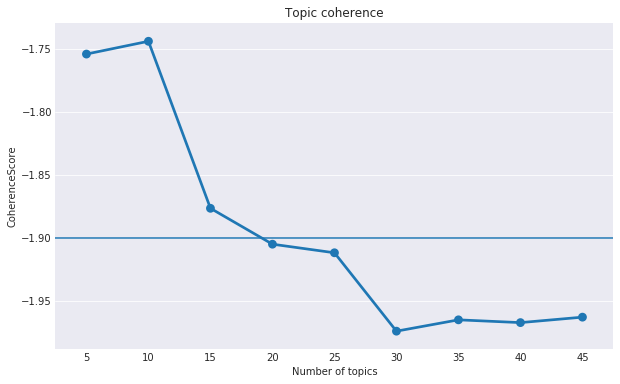

In [35]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-1.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [31]:
plotData

CoherenceScore  Number of topics
0       -1.753900                 5
1       -1.743757                10
2       -1.876234                15
3       -1.904699                20
4       -1.911515                25
5       -1.973686                30
6       -1.964702                35
7       -1.966900                40
8       -1.962573                45

In [14]:
##### Step-3 : Define multicore lda model and enjoy!!!
num_topics =18
Lda = models.LdaMulticore
lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
         passes=20,chunksize=4000,random_state=42)

INFO : using symmetric alpha at 0.05555555555555555
INFO : using symmetric eta at 0.05555555555555555
INFO : using serial LDA version on this node
INFO : running online LDA training, 18 topics, 20 passes over the supplied corpus of 126225 documents, updating every 4000 documents, evaluating every ~40000 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 1 processes
INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2DEBUG : worker process entering E-step loop
DEBUG : getting a new job

INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 1948/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
D

INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #9 (0.056): 0.023*"food" + 0.023*"great" + 0.015*"come" + 0.014*"good" + 0.013*"place" + 0.011*"order" + 0.011*"service" + 0.010*"amazing" + 0.008*"restaurant" + 0.008*"time"
INFO : topic #10 (0.056): 0.028*"good" + 0.022*"food" + 0.022*"order" + 0.014*"service" + 0.013*"time" + 0.009*"like" + 0.007*"restaurant" + 0.006*"place" + 0.006*"ask" + 0.006*"great"
INFO : topic #13 (0.056): 0.033*"food" + 0.026*"good" + 0.017*"place" + 0.015*"order" + 0.012*"great" + 0.010*"come" + 0.010*"service" + 0.009*"delicious" + 0.009*"time" + 0.008*"eat"
INFO : topic #15 (0.056): 0.019*"burger" + 0.014*"order" + 0.012*"good" + 0.012*"wait" + 0.011*"place" + 0.010*"come" + 0.009*"like" + 0.009*"time" + 0.009*"taste" + 0.009*"food"
INFO : topic #2 (0.056): 0.024*"food" + 0.018*"good" + 0.014*"like" + 0.013*"come" + 0.013*"great" + 0.011*"time" + 0.010*"order" + 0.010*"service" + 0.008*"place" + 0.006*"eat"
INFO : top

DEBUG : 2559/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #8 (0.056): 0.020*"good" + 0.017*"food" + 0.016*"time" + 0.011*"place" + 0.011*"taco" + 0.010*"mother_day" + 0.009*"favorite" + 0.009*"amazing" + 0.009*"service" + 0.008*"come"
INFO : topic #1 (0.056): 0.018*"good" + 0.017*"great" + 0.015*"place" + 0.012*"bar" + 0.011*"food" + 0.011*"nice" + 0.010*"service" + 0.008*"dessert" + 0.007*"drink" + 0.007*"love"
INFO : topic #13 (0.056): 0.037*"food" + 0.030*"good" + 0.017*"place" + 0.013*"great" + 0.012*"order" + 0.010*"fresh" + 0.010*"service" + 0.010*"come" + 0.010*"eat" + 0.010*"time"
INFO : topic #3 (0.056): 0.018*"food" + 0.017*"good" + 0.015*"great" + 0.013*"restaurant" + 0.01

INFO : topic diff=0.267236, rho=0.242536
INFO : PROGRESS: pass 0, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 3
DEBUG : 2926/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #17 (0.056): 0.050*"order" + 0.018*"time" + 0.018*"food" + 0.016*"come" + 0.013*"ask" + 0.012*"place" + 0.011*"tell" + 0.010*"bad" + 0.009*"good" + 0.008*"wait"
INFO : topic #2 (0.056): 0.024*"food" + 0.017*"good" + 0.015*"like" + 0.015*"buffet" + 0.011*"time" + 0.010*"come" + 0.009*"great" + 0.009*"service" + 0.008*"place" + 0.007*"want"
INFO : topic #0 (0.056): 0.022*"good" + 0.015*"price" + 0.013*"raman" + 0.013*"great" + 0.013*"place" + 0.011*"food" + 0.010*"try" + 0.008*"service"

INFO : topic #6 (0.056): 0.032*"steak" + 0.029*"fry" + 0.012*"good" + 0.011*"cheese" + 0.009*"burger" + 0.007*"come" + 0.007*"order" + 0.007*"sauce" + 0.006*"cook" + 0.006*"breakfast"
INFO : topic #16 (0.056): 0.030*"good" + 0.026*"chicken" + 0.016*"order" + 0.014*"like" + 0.012*"food" + 0.011*"come" + 0.011*"try" + 0.011*"sauce" + 0.010*"fry" + 0.010*"taste"
INFO : topic diff=0.272073, rho=0.208514
INFO : PROGRESS: pass 0, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 3
DEBUG : 3171/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #1 (0.056): 0.021*"great" + 0.020*"good" + 0.014*"bar" + 0.013*"place" + 0.012*"nice" + 0.012*"dessert" + 0.010*"service" + 0.

INFO : topic #14 (0.056): 0.041*"sushi" + 0.032*"roll" + 0.027*"good" + 0.019*"fish" + 0.017*"place" + 0.013*"try" + 0.013*"fresh" + 0.012*"great" + 0.011*"order" + 0.011*"eat"
INFO : topic #4 (0.056): 0.053*"food" + 0.042*"good" + 0.033*"place" + 0.032*"great" + 0.025*"service" + 0.016*"restaurant" + 0.015*"love" + 0.013*"come" + 0.012*"try" + 0.011*"delicious"
INFO : topic #5 (0.056): 0.070*"pizza" + 0.032*"good" + 0.028*"place" + 0.019*"love" + 0.013*"time" + 0.013*"try" + 0.012*"great" + 0.010*"cheese" + 0.010*"eat" + 0.009*"like"
INFO : topic diff=0.249766, rho=0.185695
INFO : PROGRESS: pass 0, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 3
DEBUG : 3287/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing

DEBUG : processing chunk #3 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #12 (0.056): 0.028*"taco" + 0.027*"good" + 0.021*"drink" + 0.016*"order" + 0.014*"come" + 0.012*"happy_hour" + 0.010*"mexican" + 0.010*"like" + 0.010*"try" + 0.009*"place"
INFO : topic #4 (0.056): 0.053*"food" + 0.043*"good" + 0.034*"place" + 0.031*"great" + 0.024*"service" + 0.016*"restaurant" + 0.016*"love" + 0.014*"come" + 0.013*"try" + 0.012*"delicious"
INFO : topic #3 (0.056): 0.019*"good" + 0.018*"restaurant" + 0.018*"food" + 0.015*"service" + 0.014*"great" + 0.012*"dish" + 0.011*"dinner" + 0.011*"experience" + 0.011*"amazing" + 0.009*"delicious"
INFO : topic #8 (0.056): 0.039*"coffee" + 0.019*"taco" + 0.015*"good" + 0.012*"latte" + 0.012*"cake" + 0.010*"pastry" + 0.010*"favorite" + 0.010*"time" + 0.009*"try" + 0.009*"place"
INFO : topic #14 (0.056): 0.045*"sushi" + 0.035*"roll" + 0.027*"go

INFO : topic diff=0.246149, rho=0.172629
INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #44000/126225, outstanding queue size 3
DEBUG : 3452/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #0 (0.056): 0.027*"price" + 0.022*"good" + 0.018*"raman" + 0.011*"place" + 0.009*"menu" + 0.009*"try" + 0.008*"bowl" + 0.008*"food" + 0.008*"quality" + 0.007*"like"
INFO : topic #9 (0.056): 0.054*"great" + 0.032*"food" + 0.021*"place" + 0.021*"amazing" + 0.017*"service" + 0.017*"come" + 0.016*"good" + 0.014*"awesome" + 0.014*"time" + 0.012*"friendly"
INFO : topic #3 (0.056): 0.020*"restaurant" + 0.019*"good" + 0.018*"food" + 0.015*"service" + 0.013*"great" + 0.013*"dish" + 0.011*"dinne

INFO : topic #13 (0.056): 0.040*"food" + 0.032*"good" + 0.021*"place" + 0.018*"great" + 0.017*"location" + 0.015*"fresh" + 0.015*"lunch" + 0.013*"service" + 0.012*"option" + 0.011*"time"
INFO : topic diff=0.223691, rho=0.172629
INFO : PROGRESS: pass 1, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 3
DEBUG : 3528/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #9 (0.056): 0.057*"great" + 0.034*"food" + 0.022*"place" + 0.022*"amazing" + 0.019*"service" + 0.017*"come" + 0.017*"good" + 0.015*"time" + 0.014*"awesome" + 0.013*"friendly"
INFO : topic #3 (0.056): 0.020*"restaurant" + 0.020*"good" + 0.018*"food" + 0.016*"service" + 0.013*"great" + 0.013*"dish" + 0.

INFO : topic #12 (0.056): 0.036*"taco" + 0.029*"good" + 0.021*"drink" + 0.014*"order" + 0.012*"happy_hour" + 0.012*"come" + 0.012*"mexican" + 0.011*"like" + 0.011*"try" + 0.010*"burrito"
INFO : topic #14 (0.056): 0.051*"sushi" + 0.038*"roll" + 0.028*"good" + 0.025*"fish" + 0.019*"place" + 0.016*"fresh" + 0.014*"try" + 0.011*"eat" + 0.011*"come" + 0.010*"salmon"
INFO : topic diff=0.207261, rho=0.172629
INFO : PROGRESS: pass 1, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 3
DEBUG : 3540/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #13 (0.056): 0.039*"food" + 0.033*"good" + 0.023*"place" + 0.018*"great" + 0.017*"location" + 0.016*"lunch" + 0.015*"fresh" +

INFO : topic #14 (0.056): 0.052*"sushi" + 0.039*"roll" + 0.026*"good" + 0.025*"fish" + 0.019*"place" + 0.016*"fresh" + 0.014*"try" + 0.011*"eat" + 0.010*"order" + 0.010*"come"
INFO : topic #10 (0.056): 0.009*"customer" + 0.009*"restaurant" + 0.009*"walk" + 0.008*"like" + 0.008*"people" + 0.007*"work" + 0.007*"time" + 0.007*"tell" + 0.007*"good" + 0.006*"ask"
INFO : topic #12 (0.056): 0.038*"taco" + 0.028*"good" + 0.021*"drink" + 0.014*"order" + 0.013*"mexican" + 0.012*"come" + 0.012*"happy_hour" + 0.012*"try" + 0.011*"like" + 0.010*"place"
INFO : topic diff=0.198368, rho=0.172629
INFO : PROGRESS: pass 1, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 3
DEBUG : 3589/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : perfo

INFO : topic #3 (0.056): 0.021*"good" + 0.019*"restaurant" + 0.018*"food" + 0.017*"service" + 0.013*"great" + 0.013*"dinner" + 0.012*"dish" + 0.012*"amazing" + 0.011*"experience" + 0.010*"delicious"
INFO : topic #9 (0.056): 0.060*"great" + 0.038*"food" + 0.025*"place" + 0.023*"amazing" + 0.023*"service" + 0.020*"good" + 0.018*"come" + 0.016*"time" + 0.015*"love" + 0.015*"friendly"
INFO : topic diff=0.160327, rho=0.172629
DEBUG : bound: at document #0
INFO : -7.297 per-word bound, 157.3 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 2, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 2, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3569/400

DEBUG : updating topics
DEBUG : processing chunk #6 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #8 (0.056): 0.076*"coffee" + 0.026*"cake" + 0.014*"pastry" + 0.014*"latte" + 0.013*"chocolate" + 0.010*"croissant" + 0.010*"cafe" + 0.009*"bakery" + 0.008*"coffee_shop" + 0.007*"cup"
INFO : topic #9 (0.056): 0.061*"great" + 0.041*"food" + 0.026*"place" + 0.024*"service" + 0.023*"amazing" + 0.020*"good" + 0.019*"come" + 0.017*"time" + 0.016*"love" + 0.016*"friendly"
INFO : topic #0 (0.056): 0.035*"price" + 0.023*"good" + 0.017*"raman" + 0.011*"quality" + 0.011*"place" + 0.010*"meat" + 0.009*"menu" + 0.009*"like" + 0.009*"small" + 0.008*"bit"
INFO : topic #10 (0.056): 0.009*"walk" + 0.009*"people" + 0.009*"customer" + 0.009*"restaurant" + 0.008*"like" + 0.008*"tell" + 0.007*"work" + 0.007*"time" + 0.006*"need" + 0.006*"know"
INFO : topic #6 (0.056): 0.077*"steak" + 0.023*"fr

INFO : topic diff=0.169249, rho=0.170113
INFO : PROGRESS: pass 2, dispatched chunk #13 = documents up to #56000/126225, outstanding queue size 3
DEBUG : 3638/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #12 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #17 (0.056): 0.053*"order" + 0.021*"food" + 0.020*"time" + 0.015*"ask" + 0.014*"tell" + 0.013*"bad" + 0.013*"come" + 0.012*"place" + 0.011*"like" + 0.010*"want"
INFO : topic #14 (0.056): 0.052*"sushi" + 0.043*"roll" + 0.026*"good" + 0.026*"fish" + 0.019*"place" + 0.017*"fresh" + 0.014*"try" + 0.012*"eat" + 0.011*"salmon" + 0.011*"order"
INFO : topic #4 (0.056): 0.051*"food" + 0.047*"good" + 0.034*"place" + 0.023*"great" + 0.021*"service" + 0.018*"restaurant" + 0.015*"come" + 0.015*"tr

INFO : topic #5 (0.056): 0.102*"pizza" + 0.033*"good" + 0.022*"place" + 0.019*"wing" + 0.017*"cheese" + 0.013*"slice" + 0.012*"love" + 0.012*"order" + 0.012*"try" + 0.010*"great"
INFO : topic diff=0.146532, rho=0.170113
INFO : PROGRESS: pass 2, dispatched chunk #19 = documents up to #80000/126225, outstanding queue size 3
DEBUG : 3642/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #13 (0.056): 0.038*"food" + 0.034*"good" + 0.025*"place" + 0.021*"great" + 0.017*"location" + 0.016*"lunch" + 0.015*"fresh" + 0.014*"service" + 0.013*"love" + 0.013*"time"
INFO : topic #6 (0.056): 0.087*"steak" + 0.021*"fry" + 0.016*"cook" + 0.015*"cheese" + 0.012*"good" + 0.011*"medium" + 0.010*"potato" + 0.010*"cut" + 0.009*"onion" + 0.008*"grill"
INFO : topic #4 (0.056): 0.051*"food" + 0.048*"good" + 0.033*"p

INFO : topic #15 (0.056): 0.085*"burger" + 0.062*"fry" + 0.024*"good" + 0.015*"like" + 0.012*"order" + 0.011*"cheese" + 0.011*"shake" + 0.010*"dog" + 0.010*"sandwich" + 0.009*"taste"
INFO : topic #17 (0.056): 0.052*"order" + 0.022*"food" + 0.021*"time" + 0.016*"ask" + 0.014*"tell" + 0.013*"bad" + 0.013*"come" + 0.012*"place" + 0.011*"like" + 0.011*"want"
INFO : topic diff=0.141228, rho=0.170113
INFO : PROGRESS: pass 2, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 3
DEBUG : 3626/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #9 (0.056): 0.065*"great" + 0.046*"food" + 0.029*"service" + 0.028*"place" + 0.025*"amazing" + 0.025*"good" + 0.020*"come" + 0.018*

INFO : topic #6 (0.056): 0.093*"steak" + 0.018*"cook" + 0.016*"fry" + 0.015*"cheese" + 0.012*"medium" + 0.012*"good" + 0.011*"cut" + 0.010*"onion" + 0.010*"potato" + 0.008*"grill"
INFO : topic #7 (0.056): 0.027*"salad" + 0.017*"pasta" + 0.017*"bread" + 0.012*"sauce" + 0.012*"italian" + 0.010*"dish" + 0.009*"restaurant" + 0.009*"soup" + 0.009*"meal" + 0.008*"order"
INFO : topic #15 (0.056): 0.087*"burger" + 0.062*"fry" + 0.024*"good" + 0.015*"like" + 0.013*"order" + 0.011*"cheese" + 0.010*"shake" + 0.010*"sandwich" + 0.009*"taste" + 0.009*"place"
INFO : topic diff=0.124957, rho=0.170113
INFO : PROGRESS: pass 2, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 3
DEBUG : 3611/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG :

INFO : topic #13 (0.056): 0.037*"food" + 0.032*"good" + 0.026*"place" + 0.021*"great" + 0.017*"location" + 0.016*"lunch" + 0.015*"fresh" + 0.014*"service" + 0.014*"love" + 0.013*"time"
INFO : topic #12 (0.056): 0.045*"taco" + 0.030*"good" + 0.020*"drink" + 0.017*"mexican" + 0.014*"order" + 0.013*"try" + 0.013*"burrito" + 0.012*"like" + 0.012*"tea" + 0.012*"come"
INFO : topic #14 (0.056): 0.055*"sushi" + 0.046*"roll" + 0.026*"fish" + 0.026*"good" + 0.019*"place" + 0.018*"fresh" + 0.013*"try" + 0.012*"eat" + 0.011*"rice" + 0.011*"salmon"
INFO : topic #3 (0.056): 0.021*"good" + 0.020*"restaurant" + 0.017*"service" + 0.017*"food" + 0.013*"dinner" + 0.013*"great" + 0.012*"amazing" + 0.012*"dish" + 0.012*"experience" + 0.011*"delicious"
INFO : topic #4 (0.056): 0.046*"food" + 0.044*"good" + 0.031*"place" + 0.019*"restaurant" + 0.019*"great" + 0.017*"service" + 0.015*"try" + 0.015*"come" + 0.012*"love" + 0.012*"dish"
INFO : topic diff=0.119004, rho=0.167703
INFO : PROGRESS: pass 3, dispatched

DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #9 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #1 (0.056): 0.024*"bar" + 0.018*"good" + 0.015*"drink" + 0.015*"great" + 0.014*"nice" + 0.014*"beer" + 0.014*"place" + 0.010*"dessert" + 0.010*"area" + 0.009*"selection"
INFO : topic #11 (0.056): 0.039*"wait" + 0.036*"come" + 0.035*"food" + 0.028*"table" + 0.025*"order" + 0.023*"time" + 0.022*"service" + 0.020*"server" + 0.019*"minute" + 0.017*"ask"
INFO : topic #15 (0.056): 0.094*"burger" + 0.066*"fry" + 0.026*"good" + 0.014*"like" + 0.013*"order" + 0.012*"cheese" + 0.010*"shake" + 0.009*"try" + 0.009*"taste" + 0.009*"bun"
INFO : topic #2 (0.056): 0.041*"buffet" + 0.027*"food" + 0.022*"good" + 0.020*"stay" + 0.020*"vegas" + 0.019*"hotel" + 0.018*"eat" + 0.016*"room" + 0.014*"like" + 0.010*"day"
INFO : topic #16 (0.056): 0.033*"

INFO : topic diff=0.106212, rho=0.167703
INFO : PROGRESS: pass 3, dispatched chunk #16 = documents up to #68000/126225, outstanding queue size 3
DEBUG : 3681/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #15 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #11 (0.056): 0.038*"wait" + 0.036*"come" + 0.035*"food" + 0.028*"table" + 0.025*"order" + 0.023*"time" + 0.022*"service" + 0.020*"server" + 0.020*"minute" + 0.016*"ask"
INFO : topic #12 (0.056): 0.048*"taco" + 0.031*"good" + 0.019*"drink" + 0.018*"mexican" + 0.015*"burrito" + 0.014*"order" + 0.013*"try" + 0.013*"like" + 0.011*"chip" + 0.011*"salsa"
INFO : topic #16 (0.056): 0.034*"chicken" + 0.024*"good" + 0.018*"order" + 0.015*"sauce" + 0.015*"like" + 0.012*"flavor" + 0.012*"fry" + 0

INFO : topic #13 (0.056): 0.037*"food" + 0.034*"good" + 0.028*"place" + 0.022*"great" + 0.016*"lunch" + 0.016*"location" + 0.015*"love" + 0.015*"fresh" + 0.015*"service" + 0.014*"time"
INFO : topic diff=0.097533, rho=0.167703
INFO : PROGRESS: pass 3, dispatched chunk #22 = documents up to #92000/126225, outstanding queue size 3
DEBUG : 3669/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #17 (0.056): 0.050*"order" + 0.023*"food" + 0.021*"time" + 0.015*"ask" + 0.014*"bad" + 0.014*"tell" + 0.013*"come" + 0.012*"place" + 0.012*"like" + 0.011*"want"
INFO : topic #6 (0.056): 0.102*"steak" + 0.021*"cook" + 0.014*"cheese" + 0.013*"cut" + 0.013*"medium" + 0.012*"potato" + 0.012*"fry" + 0.012*"g

INFO : topic #11 (0.056): 0.038*"wait" + 0.035*"come" + 0.034*"food" + 0.028*"table" + 0.025*"order" + 0.023*"service" + 0.022*"time" + 0.020*"server" + 0.019*"minute" + 0.017*"ask"
INFO : topic #8 (0.056): 0.100*"coffee" + 0.031*"cake" + 0.022*"chocolate" + 0.020*"pastry" + 0.014*"latte" + 0.012*"cup" + 0.011*"croissant" + 0.011*"cookie" + 0.010*"cafe" + 0.010*"bakery"
INFO : topic diff=0.093904, rho=0.167703
INFO : PROGRESS: pass 3, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 3
DEBUG : 3678/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #5 (0.056): 0.111*"pizza" + 0.034*"good" + 0.026*"wing" + 0.018*"place" + 0.018*"cheese" + 0.015*"slice" + 0.015*"o

INFO : topic #8 (0.056): 0.101*"coffee" + 0.030*"cake" + 0.025*"chocolate" + 0.020*"pastry" + 0.017*"latte" + 0.014*"cup" + 0.012*"cafe" + 0.011*"croissant" + 0.011*"cookie" + 0.009*"ice"
INFO : topic diff=0.071974, rho=0.167703
DEBUG : bound: at document #0
INFO : -7.286 per-word bound, 156.1 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 4, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 4, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3686/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documen

INFO : topic #14 (0.056): 0.056*"sushi" + 0.048*"roll" + 0.028*"fish" + 0.025*"good" + 0.019*"fresh" + 0.018*"place" + 0.014*"try" + 0.012*"eat" + 0.012*"salmon" + 0.011*"rice"
INFO : topic #9 (0.056): 0.068*"great" + 0.056*"food" + 0.035*"service" + 0.033*"place" + 0.032*"good" + 0.026*"amazing" + 0.022*"come" + 0.021*"love" + 0.019*"time" + 0.018*"friendly"
INFO : topic #5 (0.056): 0.118*"pizza" + 0.033*"good" + 0.025*"wing" + 0.019*"place" + 0.019*"cheese" + 0.016*"slice" + 0.015*"order" + 0.012*"try" + 0.011*"sauce" + 0.010*"love"
INFO : topic #17 (0.056): 0.049*"order" + 0.023*"food" + 0.021*"time" + 0.016*"ask" + 0.014*"bad" + 0.014*"tell" + 0.013*"come" + 0.013*"like" + 0.013*"place" + 0.011*"want"
INFO : topic diff=0.084806, rho=0.165394
INFO : PROGRESS: pass 4, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 3
DEBUG : 3674/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : updating to

DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #16 (0.056): 0.034*"chicken" + 0.024*"good" + 0.018*"order" + 0.015*"sauce" + 0.015*"like" + 0.012*"fry" + 0.012*"egg" + 0.012*"flavor" + 0.011*"come" + 0.010*"taste"
INFO : topic #10 (0.056): 0.009*"walk" + 0.009*"people" + 0.009*"restaurant" + 0.008*"know" + 0.008*"work" + 0.008*"like" + 0.007*"customer" + 0.007*"need" + 0.007*"tell" + 0.006*"staff"
INFO : topic #1 (0.056): 0.027*"bar" + 0.019*"drink" + 0.016*"good" + 0.015*"beer" + 0.015*"nice" + 0.014*"place" + 0.014*"great" + 0.010*"area" + 0.010*"menu" + 0.009*"sit"
INFO : topic #11 (0.056): 0.040*"wait" + 0.036*"come" + 0.033*"food" + 0.028*"table" + 0.027*"order" + 0.023*"time" + 0.022*"service" + 0.020*"server" + 0.019*"minute" + 0.017*"ask"
INFO : topic #8 (0.056): 0.092*"coffee" + 0.039*"cake" + 0.024*"chocolate" + 0.020*"mother_day" + 0.019*"pastry" + 0.013*"cookie" + 0.012*"latte" + 0.011*"cup" + 0.011*"cafe" + 0.010*"croissant"
INFO : topic diff=0.0884

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #18 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #14 (0.056): 0.057*"sushi" + 0.047*"roll" + 0.028*"fish" + 0.025*"good" + 0.019*"fresh" + 0.018*"place" + 0.015*"try" + 0.013*"salmon" + 0.012*"eat" + 0.011*"rice"
INFO : topic #0 (0.056): 0.040*"good" + 0.038*"price" + 0.021*"food" + 0.015*"place" + 0.014*"quality" + 0.013*"like" + 0.012*"pretty" + 0.011*"think" + 0.011*"small" + 0.011*"taste"
INFO : topic #8 (0.056): 0.097*"coffee" + 0.035*"cake" + 0.027*"chocolate" + 0.019*"pastry" + 0.014*"latte" + 0.014*"cookie" + 0.013*"cup" + 0.012*"croissant" + 0.010*"ice" + 0.010*"cafe"
INFO : topic #10 (0.056): 0.009*"people" + 0.009*"restaurant" + 0.009*"walk" + 0.008*"know" + 0.008*"customer" + 0.008*"work" + 0.007*"like" + 0.007*"need" + 

INFO : topic diff=0.077878, rho=0.165394
INFO : PROGRESS: pass 4, dispatched chunk #25 = documents up to #104000/126225, outstanding queue size 3
DEBUG : 3690/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #11 (0.056): 0.041*"wait" + 0.036*"come" + 0.033*"food" + 0.028*"table" + 0.027*"order" + 0.022*"time" + 0.022*"service" + 0.020*"minute" + 0.020*"server" + 0.017*"ask"
INFO : topic #16 (0.056): 0.032*"chicken" + 0.023*"good" + 0.017*"order" + 0.015*"sauce" + 0.015*"like" + 0.012*"fry" + 0.011*"egg" + 0.011*"flavor" + 0.011*"come" + 0.010*"try"
INFO : topic #14 (0.056): 0.058*"sushi" + 0.047*"roll" + 0.029*"fish" + 0.023*"good" + 0.019*"fresh" + 0.018*"place" + 0.014*"try" + 0.012*"s

INFO : topic #12 (0.056): 0.048*"taco" + 0.030*"good" + 0.020*"mexican" + 0.016*"drink" + 0.016*"burrito" + 0.014*"tea" + 0.014*"order" + 0.013*"try" + 0.012*"like" + 0.012*"chip"
INFO : topic diff=0.069759, rho=0.165394
INFO : PROGRESS: pass 4, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 3
DEBUG : 3691/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #9 (0.056): 0.070*"great" + 0.058*"food" + 0.038*"service" + 0.035*"good" + 0.033*"place" + 0.028*"amazing" + 0.022*"come" + 0.021*"love" + 0.020*"time" + 0.018*"friendly"
INFO : topic #0 (0.056): 0.042*"good" + 0.036*"price" + 0.023*"food" + 0.016*"place" + 0.014*"like" + 0.014*"pretty" + 0.014*"quality" +

INFO : topic #0 (0.056): 0.043*"good" + 0.036*"price" + 0.024*"food" + 0.017*"place" + 0.014*"like" + 0.014*"quality" + 0.013*"pretty" + 0.012*"small" + 0.012*"taste" + 0.011*"raman"
INFO : topic #14 (0.056): 0.058*"sushi" + 0.050*"roll" + 0.028*"fish" + 0.023*"good" + 0.019*"fresh" + 0.018*"place" + 0.013*"try" + 0.012*"rice" + 0.012*"eat" + 0.012*"salmon"
INFO : topic #12 (0.056): 0.050*"taco" + 0.030*"good" + 0.020*"mexican" + 0.017*"drink" + 0.015*"order" + 0.015*"burrito" + 0.015*"tea" + 0.013*"try" + 0.012*"like" + 0.012*"chip"
INFO : topic diff=0.070809, rho=0.163177
INFO : PROGRESS: pass 5, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 3
DEBUG : 3731/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #4 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inf

INFO : topic #17 (0.056): 0.047*"order" + 0.023*"food" + 0.021*"time" + 0.016*"bad" + 0.016*"ask" + 0.014*"tell" + 0.014*"come" + 0.013*"like" + 0.013*"place" + 0.011*"want"
INFO : topic #15 (0.056): 0.106*"burger" + 0.083*"fry" + 0.026*"good" + 0.015*"cheese" + 0.014*"order" + 0.012*"like" + 0.011*"shake" + 0.010*"bun" + 0.010*"try" + 0.009*"dog"
INFO : topic #12 (0.056): 0.050*"taco" + 0.030*"good" + 0.020*"mexican" + 0.017*"drink" + 0.016*"burrito" + 0.014*"order" + 0.013*"tea" + 0.013*"try" + 0.012*"like" + 0.012*"salsa"
INFO : topic #8 (0.056): 0.088*"coffee" + 0.038*"cake" + 0.028*"chocolate" + 0.017*"crepe" + 0.015*"pastry" + 0.015*"cookie" + 0.013*"cup" + 0.012*"latte" + 0.012*"cafe" + 0.010*"ice"
INFO : topic diff=0.071128, rho=0.163177
INFO : PROGRESS: pass 5, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 3
DEBUG : 3720/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a 

INFO : topic #5 (0.056): 0.121*"pizza" + 0.033*"good" + 0.031*"wing" + 0.020*"cheese" + 0.018*"order" + 0.017*"place" + 0.016*"slice" + 0.011*"crust" + 0.011*"try" + 0.011*"sauce"
INFO : topic #14 (0.056): 0.058*"sushi" + 0.049*"roll" + 0.029*"fish" + 0.023*"good" + 0.020*"fresh" + 0.017*"place" + 0.014*"try" + 0.013*"salmon" + 0.012*"eat" + 0.011*"rice"
INFO : topic #0 (0.056): 0.046*"good" + 0.036*"price" + 0.028*"food" + 0.017*"place" + 0.015*"like" + 0.013*"quality" + 0.013*"pretty" + 0.012*"taste" + 0.012*"think" + 0.011*"small"
INFO : topic #17 (0.056): 0.047*"order" + 0.023*"food" + 0.022*"time" + 0.016*"ask" + 0.016*"bad" + 0.014*"tell" + 0.014*"like" + 0.013*"come" + 0.013*"place" + 0.011*"want"
INFO : topic #10 (0.056): 0.009*"walk" + 0.009*"restaurant" + 0.009*"people" + 0.008*"know" + 0.008*"work" + 0.007*"customer" + 0.007*"need" + 0.007*"like" + 0.007*"staff" + 0.007*"tell"
INFO : topic diff=0.070591, rho=0.163177
INFO : PROGRESS: pass 5, dispatched chunk #17 = documents 

DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #21 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #2 (0.056): 0.046*"buffet" + 0.025*"stay" + 0.023*"vegas" + 0.021*"hotel" + 0.021*"good" + 0.020*"food" + 0.016*"eat" + 0.016*"room" + 0.012*"casino" + 0.012*"line"
INFO : topic #3 (0.056): 0.022*"restaurant" + 0.016*"good" + 0.014*"service" + 0.013*"dinner" + 0.013*"dish" + 0.013*"dessert" + 0.012*"meal" + 0.012*"great" + 0.012*"food" + 0.012*"delicious"
INFO : topic #0 (0.056): 0.048*"good" + 0.035*"price" + 0.030*"food" + 0.018*"place" + 0.015*"like" + 0.014*"quality" + 0.014*"pretty" + 0.012*"taste" + 0.012*"small" + 0.011*"think"
INFO : topic #11 (0.056): 0.041*"wait" + 0.036*"come" + 0.032*"food" + 0.029*"table" + 0.028*"order" + 0.022*"time" + 0.022*"service" + 0.021*"server" + 0.021*"minute" + 0.017*"ask"
INFO : topic #

INFO : topic diff=0.064981, rho=0.163177
INFO : PROGRESS: pass 5, dispatched chunk #28 = documents up to #116000/126225, outstanding queue size 3
DEBUG : 3725/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #13 (0.056): 0.034*"food" + 0.031*"good" + 0.031*"place" + 0.021*"great" + 0.016*"lunch" + 0.015*"time" + 0.015*"try" + 0.015*"love" + 0.015*"location" + 0.014*"fresh"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"good" + 0.014*"dinner" + 0.014*"service" + 0.013*"dessert" + 0.013*"dish" + 0.012*"delicious" + 0.012*"great" + 0.012*"meal" + 0.011*"experience"
INFO : topic #7 (0.056): 0.042*"salad" + 0.021*"bread" + 0.019*"pasta" + 0.016*"sauce" + 0.013*"italian" + 0.013*"soup" +

INFO : topic diff=0.053737, rho=0.163177
DEBUG : bound: at document #0
INFO : -7.288 per-word bound, 156.3 perplexity estimate based on a held-out corpus of 2225 documents with 88742 words
INFO : PROGRESS: pass 6, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 6, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 6, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3756/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #5 (0.056): 0.119*"pizza" + 0.032*"

INFO : topic #14 (0.056): 0.059*"sushi" + 0.051*"roll" + 0.030*"fish" + 0.022*"good" + 0.020*"fresh" + 0.016*"place" + 0.013*"try" + 0.013*"salmon" + 0.012*"eat" + 0.011*"rice"
INFO : topic #17 (0.056): 0.046*"order" + 0.023*"food" + 0.022*"time" + 0.016*"ask" + 0.015*"bad" + 0.015*"tell" + 0.014*"like" + 0.013*"come" + 0.013*"place" + 0.011*"want"
INFO : topic #16 (0.056): 0.033*"chicken" + 0.023*"good" + 0.017*"order" + 0.014*"sauce" + 0.014*"like" + 0.013*"egg" + 0.013*"fry" + 0.011*"come" + 0.011*"flavor" + 0.010*"try"
INFO : topic diff=0.061876, rho=0.161047
INFO : PROGRESS: pass 6, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 3
DEBUG : 3714/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a

INFO : topic #16 (0.056): 0.033*"chicken" + 0.023*"good" + 0.017*"order" + 0.014*"sauce" + 0.014*"like" + 0.013*"fry" + 0.012*"egg" + 0.011*"come" + 0.011*"flavor" + 0.010*"try"
INFO : topic #14 (0.056): 0.058*"sushi" + 0.050*"roll" + 0.029*"fish" + 0.022*"good" + 0.020*"fresh" + 0.016*"place" + 0.013*"try" + 0.013*"salmon" + 0.012*"eat" + 0.011*"order"
INFO : topic #8 (0.056): 0.085*"coffee" + 0.039*"cake" + 0.029*"chocolate" + 0.025*"crepe" + 0.019*"pastry" + 0.018*"mother_day" + 0.016*"cookie" + 0.013*"sweet" + 0.013*"ice_cream" + 0.012*"strawberry"
INFO : topic #12 (0.056): 0.053*"taco" + 0.028*"good" + 0.019*"mexican" + 0.017*"drink" + 0.016*"burrito" + 0.014*"order" + 0.013*"tea" + 0.012*"try" + 0.012*"chip" + 0.012*"like"
INFO : topic diff=0.067337, rho=0.161047
INFO : PROGRESS: pass 6, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 3
DEBUG : 3720/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : resul

DEBUG : processing chunk #18 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #13 (0.056): 0.033*"food" + 0.032*"place" + 0.031*"good" + 0.020*"great" + 0.016*"lunch" + 0.016*"time" + 0.016*"try" + 0.015*"love" + 0.015*"location" + 0.014*"fresh"
INFO : topic #17 (0.056): 0.046*"order" + 0.023*"food" + 0.021*"time" + 0.016*"bad" + 0.016*"ask" + 0.014*"tell" + 0.014*"like" + 0.013*"come" + 0.013*"place" + 0.011*"want"
INFO : topic #5 (0.056): 0.122*"pizza" + 0.033*"wing" + 0.031*"good" + 0.021*"cheese" + 0.019*"order" + 0.017*"slice" + 0.015*"place" + 0.012*"crust" + 0.011*"sauce" + 0.010*"try"
INFO : topic #14 (0.056): 0.060*"sushi" + 0.050*"roll" + 0.030*"fish" + 0.022*"good" + 0.020*"fresh" + 0.016*"place" + 0.014*"try" + 0.013*"salmon" + 0.012*"eat" + 0.011*"rice"
INFO : topic #15 (0.056): 0.107*"burger" + 0.089*"fry" + 0.025*"good" + 0.016*"cheese" + 0.014*"order" + 0.

DEBUG : 3693/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #24 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #15 (0.056): 0.106*"burger" + 0.094*"fry" + 0.024*"good" + 0.015*"cheese" + 0.014*"order" + 0.013*"shake" + 0.012*"dog" + 0.011*"like" + 0.011*"bun" + 0.009*"try"
INFO : topic #7 (0.056): 0.047*"salad" + 0.022*"bread" + 0.021*"pasta" + 0.017*"sauce" + 0.014*"italian" + 0.014*"soup" + 0.010*"dish" + 0.009*"chicken" + 0.009*"tomato" + 0.009*"shrimp"
INFO : topic #8 (0.056): 0.090*"coffee" + 0.033*"cake" + 0.031*"chocolate" + 0.023*"crepe" + 0.019*"pastry" + 0.017*"cookie" + 0.014*"ice_cream" + 0.013*"sweet" + 0.012*"latte" + 0.012*"cup"
INFO : topic #14 (0.056): 0.061*"sushi" + 0.050*"roll" + 0.030*"fish" + 0.020*"good" + 0.020*

INFO : topic diff=0.056184, rho=0.161047
INFO : PROGRESS: pass 6, dispatched chunk #31 = documents up to #126225/126225, outstanding queue size 3
DEBUG : 3709/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #8 (0.056): 0.089*"coffee" + 0.034*"cake" + 0.032*"chocolate" + 0.023*"crepe" + 0.020*"pastry" + 0.016*"latte" + 0.016*"cookie" + 0.015*"ice_cream" + 0.014*"cup" + 0.013*"sweet"
INFO : topic #11 (0.056): 0.041*"wait" + 0.036*"come" + 0.030*"food" + 0.030*"table" + 0.029*"order" + 0.023*"time" + 0.021*"minute" + 0.020*"server" + 0.020*"service" + 0.017*"ask"
INFO : topic #16 (0.056): 0.032*"chicken" + 0.023*"good" + 0.017*"order" + 0.014*"like" + 0.013*"sauce" + 0.013*"egg" + 0.012*"f

INFO : topic #9 (0.056): 0.072*"great" + 0.063*"food" + 0.041*"service" + 0.041*"good" + 0.034*"place" + 0.028*"amazing" + 0.023*"come" + 0.023*"love" + 0.020*"time" + 0.018*"friendly"
INFO : topic #14 (0.056): 0.061*"sushi" + 0.052*"roll" + 0.030*"fish" + 0.021*"good" + 0.020*"fresh" + 0.016*"place" + 0.013*"try" + 0.012*"salmon" + 0.012*"rice" + 0.012*"eat"
INFO : topic diff=0.057965, rho=0.158998
INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 3
DEBUG : 3749/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #1 (0.056): 0.036*"bar" + 0.028*"drink" + 0.018*"beer" + 0.015*"nice" + 0.014*"place" + 0.014*"great" + 0.012*"good" + 0.012*"sit

INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"restaurant" + 0.009*"people" + 0.008*"know" + 0.008*"work" + 0.007*"need" + 0.007*"customer" + 0.007*"staff" + 0.007*"like" + 0.006*"tell"
INFO : topic #13 (0.056): 0.032*"food" + 0.032*"place" + 0.030*"good" + 0.020*"great" + 0.016*"try" + 0.016*"lunch" + 0.016*"time" + 0.015*"location" + 0.015*"love" + 0.013*"fresh"
INFO : topic #17 (0.056): 0.045*"order" + 0.023*"food" + 0.022*"time" + 0.016*"bad" + 0.016*"ask" + 0.014*"tell" + 0.014*"like" + 0.014*"come" + 0.013*"place" + 0.011*"want"
INFO : topic diff=0.058386, rho=0.158998
INFO : PROGRESS: pass 7, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 3
DEBUG : 3713/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing

INFO : topic #12 (0.056): 0.056*"taco" + 0.027*"good" + 0.020*"mexican" + 0.018*"burrito" + 0.016*"drink" + 0.015*"order" + 0.013*"salsa" + 0.013*"chip" + 0.012*"try" + 0.012*"nachos"
INFO : topic #0 (0.056): 0.055*"good" + 0.038*"food" + 0.033*"price" + 0.021*"place" + 0.018*"like" + 0.015*"service" + 0.014*"taste" + 0.014*"pretty" + 0.013*"quality" + 0.012*"think"
INFO : topic #5 (0.056): 0.127*"pizza" + 0.035*"wing" + 0.031*"good" + 0.021*"cheese" + 0.020*"order" + 0.017*"slice" + 0.015*"place" + 0.012*"crust" + 0.011*"sauce" + 0.010*"try"
INFO : topic #15 (0.056): 0.109*"burger" + 0.093*"fry" + 0.024*"good" + 0.017*"cheese" + 0.014*"order" + 0.013*"dog" + 0.012*"shake" + 0.011*"like" + 0.010*"bun" + 0.009*"try"
INFO : topic diff=0.060006, rho=0.158998
INFO : PROGRESS: pass 7, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 3
DEBUG : 3734/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 

INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #1 (0.056): 0.035*"bar" + 0.028*"drink" + 0.018*"beer" + 0.016*"nice" + 0.015*"place" + 0.015*"great" + 0.013*"sit" + 0.012*"good" + 0.011*"happy_hour" + 0.011*"area"
INFO : topic #7 (0.056): 0.051*"salad" + 0.022*"bread" + 0.022*"pasta" + 0.017*"sauce" + 0.014*"soup" + 0.014*"italian" + 0.010*"chicken" + 0.010*"tomato" + 0.010*"dish" + 0.009*"shrimp"
INFO : topic #17 (0.056): 0.045*"order" + 0.023*"food" + 0.021*"time" + 0.016*"bad" + 0.015*"ask" + 0.014*"tell" + 0.014*"like" + 0.013*"come" + 0.013*"place" + 0.011*"want"
INFO : topic #16 (0.056): 0.032*"chicken" + 0.023*"good" + 0.017*"order" + 0.013*"sauce" + 0.013*"like" + 0.013*"fry" + 0.013*"egg" + 0.011*"come" + 0.011*"breakfast" + 0.010*"try"
INFO : topic #2 (0.056): 0.050*"buffet" + 0.027*"stay" + 0.023*"vegas" + 0.023*"hotel" + 0.018*"good" + 0.017*"room" + 0.015*"eat" + 0.014*"food" + 0.013*"casino" + 0.013*"line"
INFO : topic diff=0.0569

DEBUG : 3752/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #27 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #5 (0.056): 0.124*"pizza" + 0.034*"wing" + 0.030*"good" + 0.021*"order" + 0.020*"cheese" + 0.018*"slice" + 0.014*"place" + 0.013*"crust" + 0.012*"sauce" + 0.010*"try"
INFO : topic #2 (0.056): 0.050*"buffet" + 0.028*"stay" + 0.023*"vegas" + 0.023*"hotel" + 0.018*"room" + 0.017*"good" + 0.014*"eat" + 0.014*"casino" + 0.013*"food" + 0.012*"line"
INFO : topic #7 (0.056): 0.048*"salad" + 0.022*"bread" + 0.020*"pasta" + 0.018*"sauce" + 0.014*"soup" + 0.014*"italian" + 0.010*"chicken" + 0.010*"tomato" + 0.009*"dish" + 0.009*"shrimp"
INFO : topic #14 (0.056): 0.062*"sushi" + 0.051*"roll" + 0.030*"fish" + 0.020*"fresh" + 0.019*"good" +

INFO : PROGRESS: pass 8, dispatched chunk #0 = documents up to #4000/126225, outstanding queue size 1
INFO : PROGRESS: pass 8, dispatched chunk #1 = documents up to #8000/126225, outstanding queue size 2
INFO : PROGRESS: pass 8, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3739/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #7 (0.056): 0.050*"salad" + 0.023*"bread" + 0.021*"pasta" + 0.018*"sauce" + 0.016*"soup" + 0.015*"italian" + 0.010*"chicken" + 0.010*"tomato" + 0.009*"dish" + 0.009*"serve"
INFO : topic #15 (0.056): 0.110*"burger" + 0.094*"f

INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"people" + 0.009*"restaurant" + 0.008*"work" + 0.008*"know" + 0.008*"need" + 0.007*"customer" + 0.007*"staff" + 0.006*"like" + 0.006*"day"
INFO : topic #0 (0.056): 0.057*"good" + 0.040*"food" + 0.032*"price" + 0.021*"place" + 0.018*"like" + 0.015*"service" + 0.014*"pretty" + 0.014*"taste" + 0.013*"quality" + 0.012*"little"
INFO : topic diff=0.054053, rho=0.157026
INFO : PROGRESS: pass 8, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 3
DEBUG : 3742/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #3 (0.056): 0.022*"restaurant" + 0.015*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.013*"good" + 0.012*"menu" + 0.012*

INFO : topic #8 (0.056): 0.080*"coffee" + 0.039*"cake" + 0.030*"chocolate" + 0.025*"crepe" + 0.018*"pastry" + 0.017*"ice_cream" + 0.016*"mother_day" + 0.016*"cookie" + 0.016*"tea" + 0.016*"sweet"
INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"restaurant" + 0.009*"know" + 0.009*"people" + 0.008*"work" + 0.008*"need" + 0.007*"staff" + 0.007*"customer" + 0.007*"day" + 0.006*"like"
INFO : topic #12 (0.056): 0.056*"taco" + 0.026*"good" + 0.020*"mexican" + 0.018*"burrito" + 0.017*"drink" + 0.015*"order" + 0.013*"chip" + 0.013*"salsa" + 0.012*"try" + 0.012*"bean"
INFO : topic diff=0.059474, rho=0.157026
INFO : PROGRESS: pass 8, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 3
DEBUG : 3735/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #13 of 4000 docume

INFO : topic #6 (0.056): 0.147*"steak" + 0.031*"cook" + 0.029*"meat" + 0.019*"cut" + 0.014*"medium" + 0.014*"steakhouse" + 0.013*"potato" + 0.011*"prime_rib" + 0.011*"medium_rare" + 0.011*"ribeye"
INFO : topic #11 (0.056): 0.042*"wait" + 0.037*"come" + 0.031*"food" + 0.030*"order" + 0.029*"table" + 0.024*"time" + 0.022*"minute" + 0.021*"server" + 0.020*"service" + 0.017*"ask"
INFO : topic #4 (0.056): 0.027*"good" + 0.022*"chicken" + 0.021*"food" + 0.020*"order" + 0.019*"noodle" + 0.019*"dish" + 0.018*"rice" + 0.016*"soup" + 0.016*"spicy" + 0.016*"place"
INFO : topic #3 (0.056): 0.022*"restaurant" + 0.015*"dish" + 0.015*"dessert" + 0.014*"dinner" + 0.013*"good" + 0.012*"delicious" + 0.012*"meal" + 0.012*"menu" + 0.011*"experience" + 0.011*"service"
INFO : topic diff=0.053118, rho=0.157026
INFO : PROGRESS: pass 8, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 3
DEBUG : 3778/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the r

DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #8 (0.056): 0.085*"coffee" + 0.032*"cake" + 0.032*"chocolate" + 0.022*"crepe" + 0.020*"tea" + 0.018*"ice_cream" + 0.018*"pastry" + 0.017*"cookie" + 0.016*"sweet" + 0.013*"strawberry"
INFO : topic #5 (0.056): 0.126*"pizza" + 0.034*"wing" + 0.029*"good" + 0.022*"order" + 0.021*"cheese" + 0.018*"slice" + 0.014*"place" + 0.013*"crust" + 0.012*"sauce" + 0.010*"topping"
INFO : topic #17 (0.056): 0.044*"order" + 0.023*"food" + 0.021*"time" + 0.016*"ask" + 0.015*"bad" + 0.014*"tell" + 0.014*"like" + 0.014*"place" + 0.013*"come" + 0.011*"want"
INFO : topic #15 (0.056): 0.112*"burger" + 0.100*"fry" + 0.022*"good" + 0.016*"cheese" + 0.014*"order" + 0.013*"shake" + 0.013*"dog" + 0.012*"bun" + 0.010*"like" + 0.008*"try"
INFO : topic #14 (0.056): 0.064*"sushi" + 0.052*"roll" + 0.031*"fish" + 0.021*"fresh" + 0.018*"good" + 0.014*"place" + 0.013*"salmon" + 

DEBUG : 3752/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #14 (0.056): 0.062*"sushi" + 0.053*"roll" + 0.030*"fish" + 0.020*"fresh" + 0.018*"good" + 0.014*"place" + 0.013*"try" + 0.013*"salmon" + 0.012*"order" + 0.011*"eat"
INFO : topic #1 (0.056): 0.039*"bar" + 0.029*"drink" + 0.019*"beer" + 0.016*"nice" + 0.014*"place" + 0.014*"great" + 0.013*"sit" + 0.011*"good" + 0.011*"happy_hour" + 0.011*"area"
INFO : topic #16 (0.056): 0.031*"chicken" + 0.023*"good" + 0.016*"order" + 0.013*"like" + 0.013*"egg" + 0.013*"sauce" + 0.012*"fry" + 0.012*"breakfast" + 0.011*"sandwich" + 0.011*"come"
INFO : topic #13 (0.056): 0.033*"place" + 0.029*"food" + 0.029*"good" + 0.019*"great" + 0.017*"try" + 0

INFO : topic #17 (0.056): 0.043*"order" + 0.022*"food" + 0.022*"time" + 0.016*"ask" + 0.015*"bad" + 0.015*"tell" + 0.014*"like" + 0.014*"come" + 0.014*"place" + 0.011*"eat"
INFO : topic diff=0.052381, rho=0.155125
INFO : PROGRESS: pass 9, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 3
DEBUG : 3774/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #0 (0.056): 0.059*"good" + 0.041*"food" + 0.032*"price" + 0.022*"place" + 0.019*"like" + 0.016*"service" + 0.015*"pretty" + 0.014*"taste" + 0.013*"quality" + 0.012*"little"
INFO : topic #11 (0.056): 0.042*"wait" + 0.037*"come" + 0.030*"order" + 0.030*"food" + 0.029*"table" + 0.023*"time" + 0.021*"minute" + 0.021*"ser

INFO : topic #7 (0.056): 0.054*"salad" + 0.023*"bread" + 0.021*"pasta" + 0.018*"sauce" + 0.015*"soup" + 0.014*"italian" + 0.011*"tomato" + 0.011*"chicken" + 0.010*"dish" + 0.008*"serve"
INFO : topic #5 (0.056): 0.135*"pizza" + 0.033*"wing" + 0.029*"good" + 0.021*"order" + 0.021*"cheese" + 0.019*"slice" + 0.013*"place" + 0.013*"sauce" + 0.012*"crust" + 0.010*"try"
INFO : topic diff=0.052667, rho=0.155125
INFO : PROGRESS: pass 9, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 3
DEBUG : 3719/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #12 (0.056): 0.057*"taco" + 0.026*"good" + 0.021*"mexican" + 0.019*"burrito" + 0.016*"drink" + 0.015*"order" + 0.013*"chip"

INFO : topic #3 (0.056): 0.021*"restaurant" + 0.015*"dish" + 0.015*"dessert" + 0.014*"dinner" + 0.013*"menu" + 0.012*"good" + 0.012*"meal" + 0.012*"delicious" + 0.011*"experience" + 0.011*"service"
INFO : topic #17 (0.056): 0.045*"order" + 0.023*"food" + 0.022*"time" + 0.016*"ask" + 0.016*"bad" + 0.014*"like" + 0.014*"tell" + 0.014*"come" + 0.013*"place" + 0.011*"eat"
INFO : topic #9 (0.056): 0.073*"great" + 0.065*"food" + 0.044*"good" + 0.042*"service" + 0.034*"place" + 0.028*"amazing" + 0.023*"love" + 0.023*"come" + 0.021*"time" + 0.019*"friendly"
INFO : topic diff=0.054542, rho=0.155125
INFO : PROGRESS: pass 9, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 3
DEBUG : 3760/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #16 of 4000 documents
DEBU

INFO : topic #0 (0.056): 0.061*"good" + 0.042*"food" + 0.031*"price" + 0.023*"place" + 0.019*"like" + 0.016*"service" + 0.015*"pretty" + 0.014*"taste" + 0.013*"quality" + 0.012*"little"
INFO : topic #9 (0.056): 0.072*"great" + 0.065*"food" + 0.044*"good" + 0.042*"service" + 0.034*"place" + 0.028*"amazing" + 0.023*"come" + 0.023*"love" + 0.020*"time" + 0.019*"friendly"
INFO : topic #14 (0.056): 0.064*"sushi" + 0.053*"roll" + 0.032*"fish" + 0.021*"fresh" + 0.018*"good" + 0.014*"place" + 0.014*"salmon" + 0.013*"try" + 0.012*"rice" + 0.011*"sauce"
INFO : topic #12 (0.056): 0.057*"taco" + 0.026*"good" + 0.020*"mexican" + 0.020*"burrito" + 0.015*"order" + 0.015*"drink" + 0.015*"chip" + 0.015*"nachos" + 0.013*"salsa" + 0.012*"bean"
INFO : topic diff=0.052202, rho=0.155125
INFO : PROGRESS: pass 9, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 3
DEBUG : 3793/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result pu

DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #11 (0.056): 0.041*"wait" + 0.037*"come" + 0.030*"food" + 0.029*"order" + 0.029*"table" + 0.023*"time" + 0.021*"server" + 0.021*"minute" + 0.021*"service" + 0.018*"ask"
INFO : topic #16 (0.056): 0.032*"chicken" + 0.023*"good" + 0.016*"order" + 0.014*"like" + 0.013*"fry" + 0.013*"sauce" + 0.013*"egg" + 0.012*"breakfast" + 0.011*"sandwich" + 0.010*"come"
INFO : topic #5 (0.056): 0.129*"pizza" + 0.035*"wing" + 0.029*"good" + 0.022*"order" + 0.020*"cheese" + 0.019*"slice" + 0.013*"crust" + 0.013*"sauce" + 0.012*"place" + 0.010*"topping"
INFO : topic #2 (0.056): 0.053*"buffet" + 0.029*"stay" + 0.024*"hotel" + 0.023*"vegas" + 0.019*"room" + 0.014*"casino" + 0.014*"good" + 0.013*"line" + 0.012*"eat" + 0.011*"strip"
INFO : topic #15 (0.056): 0.113*"burger" + 0.100*"fry" + 0.021*"good" + 0.016*"cheese" + 0.014*"order" + 0.014*"shake" + 0.012*"bun" + 

INFO : PROGRESS: pass 10, dispatched chunk #2 = documents up to #12000/126225, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 3761/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #9 (0.056): 0.072*"great" + 0.065*"food" + 0.044*"good" + 0.043*"service" + 0.034*"place" + 0.028*"amazing" + 0.023*"love" + 0.023*"come" + 0.020*"time" + 0.019*"friendly"
INFO : topic #15 (0.056): 0.114*"burger" + 0.098*"fry" + 0.021*"good" + 0.017*"cheese" + 0.015*"shake" + 0.014*"order" + 0.013*"bun" + 0.011*"dog" + 0.011*"n" + 0.010*"like"
INFO : topic #14 (0.056): 0.064*"sushi" + 0.054*"roll" + 0.032*"fish" + 0.020*"fresh" + 0.018*"good" + 0.013*"salmon" + 0.013*"place" + 0.012*"try" + 0.012*"rice" + 0.012*"sauce"
INFO :

INFO : topic #6 (0.056): 0.147*"steak" + 0.034*"cook" + 0.030*"meat" + 0.020*"cut" + 0.014*"steakhouse" + 0.014*"medium" + 0.012*"potato" + 0.012*"medium_rare" + 0.011*"ribeye" + 0.011*"oz"
INFO : topic diff=0.049768, rho=0.153292
INFO : PROGRESS: pass 10, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 3
DEBUG : 3772/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #7 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #7 (0.056): 0.055*"salad" + 0.024*"bread" + 0.021*"pasta" + 0.018*"sauce" + 0.015*"soup" + 0.015*"italian" + 0.012*"chicken" + 0.011*"tomato" + 0.009*"dish" + 0.008*"serve"
INFO : topic #1 (0.056): 0.040*"bar" + 0.032*"drink" + 0.019*"beer" + 0.015*"nice" + 0.014*"great" + 0.014*"place" + 0.014*"sit

INFO : topic #1 (0.056): 0.039*"bar" + 0.032*"drink" + 0.019*"beer" + 0.016*"nice" + 0.014*"great" + 0.014*"place" + 0.013*"sit" + 0.012*"happy_hour" + 0.011*"bartender" + 0.011*"area"
INFO : topic #8 (0.056): 0.077*"coffee" + 0.038*"cake" + 0.029*"chocolate" + 0.029*"tea" + 0.023*"crepe" + 0.019*"ice_cream" + 0.019*"sweet" + 0.018*"dessert" + 0.017*"pastry" + 0.016*"cookie"
INFO : topic diff=0.054590, rho=0.153292
INFO : PROGRESS: pass 10, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 3
DEBUG : 3749/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #11 (0.056): 0.042*"wait" + 0.037*"come" + 0.031*"order" + 0.030*"food" + 0.030*"table" + 0.024*"time" + 0.021

INFO : topic #14 (0.056): 0.064*"sushi" + 0.053*"roll" + 0.032*"fish" + 0.021*"fresh" + 0.017*"good" + 0.014*"salmon" + 0.013*"try" + 0.012*"place" + 0.011*"rice" + 0.011*"sauce"
INFO : topic #17 (0.056): 0.044*"order" + 0.022*"food" + 0.022*"time" + 0.016*"ask" + 0.016*"bad" + 0.014*"tell" + 0.014*"like" + 0.014*"come" + 0.014*"place" + 0.011*"eat"
INFO : topic #12 (0.056): 0.061*"taco" + 0.025*"good" + 0.021*"mexican" + 0.020*"burrito" + 0.016*"order" + 0.015*"drink" + 0.014*"nachos" + 0.014*"chip" + 0.013*"salsa" + 0.012*"bean"
INFO : topic diff=0.048877, rho=0.153292
INFO : PROGRESS: pass 10, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 3
DEBUG : 3761/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inf

INFO : topic #8 (0.056): 0.082*"coffee" + 0.032*"cake" + 0.031*"chocolate" + 0.030*"tea" + 0.021*"crepe" + 0.020*"ice_cream" + 0.018*"sweet" + 0.017*"dessert" + 0.017*"pastry" + 0.016*"cookie"
INFO : topic #16 (0.056): 0.031*"chicken" + 0.023*"good" + 0.017*"order" + 0.013*"like" + 0.013*"fry" + 0.013*"egg" + 0.013*"sauce" + 0.012*"breakfast" + 0.012*"sandwich" + 0.010*"come"
INFO : topic #4 (0.056): 0.025*"good" + 0.024*"chicken" + 0.022*"order" + 0.020*"rice" + 0.019*"noodle" + 0.019*"dish" + 0.018*"food" + 0.017*"spicy" + 0.016*"beef" + 0.015*"soup"
INFO : topic #15 (0.056): 0.116*"burger" + 0.104*"fry" + 0.021*"good" + 0.016*"cheese" + 0.014*"order" + 0.014*"shake" + 0.013*"dog" + 0.012*"bun" + 0.010*"like" + 0.009*"n"
INFO : topic diff=0.047982, rho=0.153292
INFO : PROGRESS: pass 10, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 3
DEBUG : 3763/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result pu

DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #30 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #14 (0.056): 0.064*"sushi" + 0.055*"roll" + 0.031*"fish" + 0.020*"fresh" + 0.017*"good" + 0.013*"salmon" + 0.013*"try" + 0.012*"place" + 0.012*"order" + 0.011*"bowl"
INFO : topic #8 (0.056): 0.081*"coffee" + 0.032*"tea" + 0.032*"cake" + 0.032*"chocolate" + 0.021*"crepe" + 0.020*"ice_cream" + 0.019*"dessert" + 0.019*"sweet" + 0.018*"pastry" + 0.015*"ice"
INFO : topic #12 (0.056): 0.056*"taco" + 0.025*"good" + 0.023*"mexican" + 0.020*"burrito" + 0.016*"order" + 0.015*"drink" + 0.014*"chip" + 0.013*"bean" + 0.013*"salsa" + 0.013*"nachos"
INFO : topic #1 (0.056): 0.041*"bar" + 0.031*"drink" + 0.019*"beer" + 0.016*"nice" + 0.014*"great" + 0.014*"sit" + 0.014*"place" + 0.012*"happy_hour" + 0.011*"bartender" + 0.011*"area"
INFO : topic #0 (0.056): 0.062*"good" + 0.042*"food" + 0

INFO : topic diff=0.048690, rho=0.151522
INFO : PROGRESS: pass 11, dispatched chunk #5 = documents up to #24000/126225, outstanding queue size 3
DEBUG : 3754/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #14 (0.056): 0.065*"sushi" + 0.056*"roll" + 0.032*"fish" + 0.021*"fresh" + 0.017*"good" + 0.013*"salmon" + 0.012*"place" + 0.012*"try" + 0.012*"sauce" + 0.012*"rice"
INFO : topic #7 (0.056): 0.056*"salad" + 0.025*"bread" + 0.022*"pasta" + 0.019*"sauce" + 0.017*"soup" + 0.016*"italian" + 0.012*"chicken" + 0.011*"tomato" + 0.009*"dish" + 0.009*"serve"
INFO : topic #5 (0.056): 0.137*"pizza" + 0.034*"wing" + 0.028*"good" + 0.022*"order" + 0.021*"cheese" + 0.019*"slice" + 0.013*"sauce" + 0.

INFO : topic #4 (0.056): 0.024*"good" + 0.024*"chicken" + 0.023*"order" + 0.020*"dish" + 0.020*"rice" + 0.019*"noodle" + 0.018*"food" + 0.017*"spicy" + 0.016*"beef" + 0.015*"soup"
INFO : topic diff=0.049083, rho=0.151522
INFO : PROGRESS: pass 11, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 3
DEBUG : 3722/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #4 (0.056): 0.024*"good" + 0.024*"chicken" + 0.023*"order" + 0.020*"dish" + 0.020*"rice" + 0.019*"noodle" + 0.018*"food" + 0.017*"spicy" + 0.015*"beef" + 0.015*"soup"
INFO : topic #7 (0.056): 0.057*"salad" + 0.024*"bread" + 0.021*"pasta" + 0.019*"sauce" + 0.016*"soup" + 0.015*"italian" + 0.012*"chicken" + 0

INFO : topic #8 (0.056): 0.079*"coffee" + 0.034*"cake" + 0.030*"chocolate" + 0.029*"tea" + 0.024*"crepe" + 0.020*"ice_cream" + 0.019*"dessert" + 0.018*"sweet" + 0.018*"pastry" + 0.016*"ice"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"dish" + 0.015*"dessert" + 0.014*"dinner" + 0.013*"menu" + 0.012*"meal" + 0.012*"good" + 0.012*"delicious" + 0.011*"experience" + 0.010*"service"
INFO : topic diff=0.050812, rho=0.151522
INFO : PROGRESS: pass 11, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 3
DEBUG : 3775/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #16 (0.056): 0.032*"chicken" + 0.023*"good" + 0.017*"order" + 0.014*"egg" + 0.013*"fry" + 0.013*"lik

INFO : topic #5 (0.056): 0.133*"pizza" + 0.036*"wing" + 0.027*"good" + 0.023*"order" + 0.021*"cheese" + 0.019*"slice" + 0.014*"crust" + 0.012*"sauce" + 0.012*"place" + 0.010*"topping"
INFO : topic #8 (0.056): 0.081*"coffee" + 0.033*"cake" + 0.031*"tea" + 0.031*"chocolate" + 0.023*"crepe" + 0.021*"ice_cream" + 0.018*"dessert" + 0.018*"sweet" + 0.017*"pastry" + 0.016*"ice"
INFO : topic #9 (0.056): 0.072*"great" + 0.066*"food" + 0.045*"good" + 0.043*"service" + 0.034*"place" + 0.029*"amazing" + 0.023*"come" + 0.023*"love" + 0.020*"time" + 0.019*"friendly"
INFO : topic diff=0.048849, rho=0.151522
INFO : PROGRESS: pass 11, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 3
DEBUG : 3784/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging cha

INFO : topic #4 (0.056): 0.026*"chicken" + 0.024*"good" + 0.022*"order" + 0.020*"noodle" + 0.020*"rice" + 0.019*"dish" + 0.018*"spicy" + 0.017*"food" + 0.016*"beef" + 0.015*"soup"
INFO : topic #11 (0.056): 0.042*"wait" + 0.037*"come" + 0.030*"food" + 0.030*"order" + 0.029*"table" + 0.024*"time" + 0.021*"minute" + 0.021*"server" + 0.020*"service" + 0.018*"ask"
INFO : topic #2 (0.056): 0.055*"buffet" + 0.031*"stay" + 0.025*"hotel" + 0.022*"vegas" + 0.020*"room" + 0.015*"casino" + 0.013*"line" + 0.012*"good" + 0.011*"eat" + 0.011*"strip"
INFO : topic #0 (0.056): 0.062*"good" + 0.044*"food" + 0.030*"price" + 0.024*"place" + 0.020*"like" + 0.017*"service" + 0.015*"pretty" + 0.015*"taste" + 0.013*"little" + 0.012*"quality"
INFO : topic diff=0.048443, rho=0.151522
INFO : PROGRESS: pass 11, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 3
DEBUG : 3824/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBU

DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #0 (0.056): 0.062*"good" + 0.043*"food" + 0.030*"price" + 0.024*"place" + 0.020*"like" + 0.017*"service" + 0.015*"pretty" + 0.015*"taste" + 0.012*"quality" + 0.012*"little"
INFO : topic #2 (0.056): 0.058*"buffet" + 0.030*"stay" + 0.027*"hotel" + 0.023*"vegas" + 0.021*"room" + 0.015*"casino" + 0.014*"line" + 0.012*"good" + 0.012*"eat" + 0.011*"strip"
INFO : topic #16 (0.056): 0.031*"chicken" + 0.023*"good" + 0.017*"order" + 0.013*"egg" + 0.013*"like" + 0.013*"fry" + 0.012*"breakfast" + 0.012*"sauce" + 0.012*"sandwich" + 0.011*"come"
INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"restaurant" + 0.009*"people" + 0.008*"know" + 0.008*"work" + 0.007*"need" + 0.007*"customer" + 0.007*"staff" + 0.006*"review" + 0.006*"day"
INFO : topic #5 (0.056): 0.133*

INFO : topic diff=0.046656, rho=0.149812
INFO : PROGRESS: pass 12, dispatched chunk #8 = documents up to #36000/126225, outstanding queue size 3
DEBUG : 3781/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #14 (0.056): 0.065*"sushi" + 0.058*"roll" + 0.032*"fish" + 0.021*"fresh" + 0.017*"good" + 0.014*"salmon" + 0.012*"try" + 0.012*"order" + 0.012*"sauce" + 0.012*"rice"
INFO : topic #7 (0.056): 0.058*"salad" + 0.024*"bread" + 0.021*"pasta" + 0.019*"sauce" + 0.016*"soup" + 0.015*"italian" + 0.012*"chicken" + 0.012*"tomato" + 0.009*"dish" + 0.008*"serve"
INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"restaurant" + 0.009*"people" + 0.008*"work" + 0.008*"know" + 0.008*"need" + 0.007*"custome

INFO : topic #14 (0.056): 0.064*"sushi" + 0.055*"roll" + 0.032*"fish" + 0.021*"fresh" + 0.016*"good" + 0.013*"salmon" + 0.012*"lobster" + 0.012*"try" + 0.012*"sauce" + 0.011*"place"
INFO : topic diff=0.051213, rho=0.149812
INFO : PROGRESS: pass 12, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 3
DEBUG : 3757/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #4 (0.056): 0.025*"chicken" + 0.024*"good" + 0.023*"order" + 0.020*"dish" + 0.020*"rice" + 0.019*"noodle" + 0.018*"food" + 0.017*"spicy" + 0.016*"soup" + 0.016*"beef"
INFO : topic #10 (0.056): 0.009*"walk" + 0.009*"restaurant" + 0.009*"know" + 0.008*"work" + 0.008*"people" + 0.008*"need" + 0.008*"staff" +

INFO : topic #12 (0.056): 0.063*"taco" + 0.024*"good" + 0.022*"mexican" + 0.021*"burrito" + 0.016*"order" + 0.014*"drink" + 0.014*"chip" + 0.014*"nachos" + 0.014*"salsa" + 0.013*"bean"
INFO : topic #9 (0.056): 0.072*"great" + 0.067*"food" + 0.045*"good" + 0.043*"service" + 0.034*"place" + 0.028*"amazing" + 0.023*"love" + 0.023*"come" + 0.020*"time" + 0.019*"friendly"
INFO : topic diff=0.045776, rho=0.149812
INFO : PROGRESS: pass 12, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 3
DEBUG : 3775/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #17 (0.056): 0.043*"order" + 0.022*"food" + 0.022*"time" + 0.016*"ask" + 0.015*"bad" + 0.014*"tell" + 0.014*"like" + 0

INFO : topic #14 (0.056): 0.067*"sushi" + 0.054*"roll" + 0.033*"fish" + 0.021*"fresh" + 0.015*"good" + 0.014*"salmon" + 0.012*"sauce" + 0.012*"try" + 0.012*"rice" + 0.012*"bowl"
INFO : topic #9 (0.056): 0.072*"great" + 0.066*"food" + 0.045*"good" + 0.043*"service" + 0.034*"place" + 0.029*"amazing" + 0.023*"love" + 0.022*"come" + 0.020*"time" + 0.019*"friendly"
INFO : topic #5 (0.056): 0.134*"pizza" + 0.036*"wing" + 0.027*"good" + 0.024*"order" + 0.022*"cheese" + 0.019*"slice" + 0.014*"crust" + 0.013*"sauce" + 0.011*"place" + 0.010*"topping"
INFO : topic diff=0.044972, rho=0.149812
INFO : PROGRESS: pass 12, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 3
DEBUG : 3770/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : per

INFO : topic #12 (0.056): 0.058*"taco" + 0.024*"good" + 0.023*"mexican" + 0.021*"burrito" + 0.016*"order" + 0.015*"chip" + 0.014*"drink" + 0.014*"bean" + 0.013*"salsa" + 0.013*"nachos"
INFO : topic #4 (0.056): 0.026*"chicken" + 0.023*"good" + 0.022*"order" + 0.021*"noodle" + 0.020*"rice" + 0.019*"dish" + 0.018*"spicy" + 0.017*"food" + 0.016*"soup" + 0.015*"beef"
INFO : topic #0 (0.056): 0.063*"good" + 0.043*"food" + 0.029*"price" + 0.024*"place" + 0.020*"like" + 0.017*"service" + 0.016*"pretty" + 0.014*"taste" + 0.012*"little" + 0.012*"quality"
INFO : topic #1 (0.056): 0.042*"bar" + 0.032*"drink" + 0.019*"beer" + 0.016*"nice" + 0.014*"great" + 0.014*"sit" + 0.013*"place" + 0.012*"happy_hour" + 0.012*"bartender" + 0.011*"fun"
INFO : topic diff=0.052296, rho=0.149812
DEBUG : 3719/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a mo

DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #4 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #13 (0.056): 0.035*"place" + 0.028*"good" + 0.027*"food" + 0.019*"try" + 0.017*"time" + 0.017*"great" + 0.015*"love" + 0.014*"lunch" + 0.014*"location" + 0.013*"menu"
INFO : topic #4 (0.056): 0.026*"chicken" + 0.023*"order" + 0.023*"good" + 0.021*"rice" + 0.020*"noodle" + 0.019*"dish" + 0.017*"spicy" + 0.017*"food" + 0.016*"soup" + 0.016*"beef"
INFO : topic #14 (0.056): 0.067*"sushi" + 0.057*"roll" + 0.032*"fish" + 0.021*"fresh" + 0.016*"good" + 0.013*"salmon" + 0.012*"sauce" + 0.012*"rice" + 0.012*"order" + 0.011*"try"
INFO : topic #12 (0.056): 0.062*"taco" + 0.025*"good" + 0.024*"mexican" + 0.020*"burrito" + 0.016*"order" + 0.015*"drink" + 0.014*"salsa" + 0.014*"chip" + 0.013*"bean" + 0.012*"nachos"
INFO : topic #16 (0.056): 0

INFO : topic diff=0.046312, rho=0.148158
INFO : PROGRESS: pass 13, dispatched chunk #11 = documents up to #48000/126225, outstanding queue size 3
DEBUG : 3764/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #12 (0.056): 0.061*"taco" + 0.024*"good" + 0.023*"mexican" + 0.020*"burrito" + 0.015*"order" + 0.015*"drink" + 0.014*"chip" + 0.014*"salsa" + 0.014*"bean" + 0.013*"nachos"
INFO : topic #2 (0.056): 0.056*"buffet" + 0.030*"stay" + 0.027*"hotel" + 0.023*"vegas" + 0.021*"room" + 0.016*"casino" + 0.015*"line" + 0.011*"eat" + 0.011*"good" + 0.010*"strip"
INFO : topic #3 (0.056): 0.022*"restaurant" + 0.016*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.013*"menu" + 0.012*"meal" + 0.012*"deli

INFO : topic #14 (0.056): 0.065*"sushi" + 0.056*"roll" + 0.033*"fish" + 0.021*"fresh" + 0.016*"good" + 0.014*"salmon" + 0.012*"lobster" + 0.012*"try" + 0.012*"sauce" + 0.011*"rice"
INFO : topic diff=0.048030, rho=0.148158
INFO : PROGRESS: pass 13, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 3
DEBUG : 3774/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #1 (0.056): 0.040*"bar" + 0.034*"drink" + 0.020*"beer" + 0.016*"nice" + 0.014*"sit" + 0.014*"great" + 0.013*"happy_hour" + 0.013*"place" + 0.012*"fun" + 0.012*"bartender"
INFO : topic #12 (0.056): 0.063*"taco" + 0.024*"good" + 0.023*"mexican" + 0.021*"burrito" + 0.016*"order" + 0.015*"chip" + 0.015*"drink"

INFO : topic #11 (0.056): 0.043*"wait" + 0.037*"come" + 0.031*"food" + 0.030*"order" + 0.030*"table" + 0.023*"time" + 0.022*"minute" + 0.022*"server" + 0.021*"service" + 0.017*"ask"
INFO : topic #10 (0.056): 0.009*"restaurant" + 0.009*"walk" + 0.008*"people" + 0.008*"know" + 0.008*"work" + 0.008*"need" + 0.007*"staff" + 0.007*"customer" + 0.006*"day" + 0.006*"business"
INFO : topic diff=0.046416, rho=0.148158
INFO : PROGRESS: pass 13, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 3
DEBUG : 3809/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #12 (0.056): 0.060*"taco" + 0.024*"good" + 0.021*"burrito" + 0.021*"mexican" + 0.016*"nachos" + 0.016*"chip" + 0.016

INFO : topic #5 (0.056): 0.136*"pizza" + 0.037*"wing" + 0.027*"good" + 0.024*"order" + 0.021*"cheese" + 0.020*"slice" + 0.014*"crust" + 0.013*"sauce" + 0.010*"topping" + 0.010*"place"
INFO : topic #15 (0.056): 0.119*"burger" + 0.106*"fry" + 0.018*"good" + 0.017*"cheese" + 0.015*"shake" + 0.014*"order" + 0.012*"bun" + 0.012*"dog" + 0.010*"n" + 0.009*"like"
INFO : topic #17 (0.056): 0.042*"order" + 0.022*"food" + 0.022*"time" + 0.016*"ask" + 0.015*"bad" + 0.015*"tell" + 0.015*"like" + 0.014*"come" + 0.014*"place" + 0.011*"want"
INFO : topic diff=0.046185, rho=0.148158
INFO : PROGRESS: pass 13, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 3
DEBUG : 3801/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #28 of 4000 documents
DEBUG : performing inferen

INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #4 (0.056): 0.026*"chicken" + 0.023*"order" + 0.022*"good" + 0.021*"noodle" + 0.021*"rice" + 0.020*"dish" + 0.017*"spicy" + 0.017*"soup" + 0.016*"food" + 0.015*"beef"
INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"restaurant" + 0.008*"people" + 0.008*"know" + 0.008*"work" + 0.007*"need" + 0.007*"staff" + 0.007*"customer" + 0.006*"review" + 0.006*"day"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.015*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.013*"menu" + 0.012*"meal" + 0.012*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #0 (0.056): 0.064*"good" + 0.044*"food" + 0.029*"price" + 0.024*"place" + 0.020*"like" + 0.018*"service" + 0.015*"pretty" + 0.015*"taste" + 0.012*"quality" + 0.012*"little"
INFO : topic #1 (0.056): 0.042*"bar" + 0.033*"drink" + 0.019*"beer" + 0.015*"nice" + 0.014*"great" + 0.014*"sit" + 0.012*"place" + 0.012*"happy_hour" + 0.012*"bartender" + 0.

DEBUG : 3798/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #11 (0.056): 0.043*"wait" + 0.037*"come" + 0.031*"order" + 0.030*"food" + 0.029*"table" + 0.024*"time" + 0.022*"minute" + 0.021*"server" + 0.020*"service" + 0.017*"ask"
INFO : topic #7 (0.056): 0.061*"salad" + 0.025*"bread" + 0.021*"pasta" + 0.019*"sauce" + 0.016*"soup" + 0.015*"italian" + 0.013*"chicken" + 0.012*"tomato" + 0.008*"cheese" + 0.008*"serve"
INFO : topic #8 (0.056): 0.075*"coffee" + 0.035*"cake" + 0.035*"tea" + 0.030*"chocolate" + 0.022*"ice_cream" + 0.021*"dessert" + 0.020*"sweet" + 0.020*"crepe" + 0.018*"ice" + 0.016*"cookie"
INFO : topic #5 (0.056): 0.142*"pizza" + 0.035*"wing" + 0.027*"good" + 0.023*"order" + 0

INFO : topic diff=0.048648, rho=0.146558
INFO : PROGRESS: pass 14, dispatched chunk #14 = documents up to #60000/126225, outstanding queue size 3
DEBUG : 3758/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #15 (0.056): 0.124*"burger" + 0.104*"fry" + 0.018*"good" + 0.018*"cheese" + 0.015*"dog" + 0.014*"order" + 0.014*"shake" + 0.011*"bun" + 0.010*"n" + 0.009*"like"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"dish" + 0.015*"dessert" + 0.014*"dinner" + 0.013*"menu" + 0.012*"meal" + 0.011*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #6 (0.056): 0.153*"steak" + 0.033*"meat" + 0.033*"cook" + 0.021*"cut" + 0.016*"steakhouse" + 0.014*"medium" + 0.013*"m

INFO : topic #7 (0.056): 0.062*"salad" + 0.025*"bread" + 0.023*"pasta" + 0.019*"sauce" + 0.016*"italian" + 0.015*"soup" + 0.013*"chicken" + 0.011*"tomato" + 0.009*"cheese" + 0.008*"serve"
INFO : topic diff=0.043448, rho=0.146558
INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 3
DEBUG : 3773/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #19 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #1 (0.056): 0.041*"bar" + 0.034*"drink" + 0.020*"beer" + 0.016*"nice" + 0.014*"great" + 0.014*"sit" + 0.014*"happy_hour" + 0.012*"place" + 0.012*"bartender" + 0.011*"fun"
INFO : topic #0 (0.056): 0.065*"good" + 0.045*"food" + 0.030*"price" + 0.024*"place" + 0.020*"like" + 0.017*"service" + 0.015*"pr

INFO : topic #7 (0.056): 0.060*"salad" + 0.026*"bread" + 0.022*"pasta" + 0.020*"sauce" + 0.015*"soup" + 0.015*"italian" + 0.013*"chicken" + 0.011*"tomato" + 0.009*"cheese" + 0.009*"serve"
INFO : topic #17 (0.056): 0.043*"order" + 0.023*"food" + 0.022*"time" + 0.016*"ask" + 0.015*"bad" + 0.015*"tell" + 0.014*"like" + 0.014*"place" + 0.014*"come" + 0.011*"want"
INFO : topic diff=0.042775, rho=0.146558
INFO : PROGRESS: pass 14, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 3
DEBUG : 3769/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #25 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #9 (0.056): 0.073*"great" + 0.067*"food" + 0.045*"good" + 0.043*"service" + 0.034*"place" + 0.029*"amazing" + 0.023*"love" + 

INFO : topic #9 (0.056): 0.072*"great" + 0.067*"food" + 0.045*"good" + 0.043*"service" + 0.034*"place" + 0.029*"amazing" + 0.023*"love" + 0.022*"come" + 0.020*"time" + 0.019*"friendly"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.015*"dinner" + 0.015*"dish" + 0.014*"dessert" + 0.013*"menu" + 0.012*"meal" + 0.012*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #2 (0.056): 0.056*"buffet" + 0.032*"stay" + 0.027*"hotel" + 0.022*"vegas" + 0.022*"room" + 0.016*"casino" + 0.013*"line" + 0.012*"station" + 0.011*"strip" + 0.010*"good"
INFO : topic diff=0.050021, rho=0.146558
DEBUG : 3741/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
INFO : topic #11 (0.056): 0.042*"wait" + 0

DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.013*"menu" + 0.012*"meal" + 0.012*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #6 (0.056): 0.150*"steak" + 0.034*"cook" + 0.033*"meat" + 0.022*"cut" + 0.016*"steakhouse" + 0.014*"medium" + 0.013*"ribeye" + 0.012*"medium_rare" + 0.012*"oz" + 0.011*"potato"
INFO : topic #16 (0.056): 0.032*"chicken" + 0.023*"good" + 0.017*"order" + 0.014*"egg" + 0.014*"breakfast" + 0.014*"fry" + 0.013*"sandwich" + 0.013*"like" + 0.012*"sauce" + 0.010*"come"
INFO : topic #0 (0.056): 0.063*"good" + 0.044*"food" + 0.030*"price" + 0.025*"place" + 0.020*"like" + 0.017*"service" + 0.015*"pretty" + 0.015*"taste" + 0.012*"little" + 0.012*"quality"
INFO : topic #4 (0.056): 0.026*"chicken" + 0.023*"order" + 0.022*"rice" + 0.022*"good" + 0.020*"noodle" + 0.020*"dish" + 0.017*"spicy" + 0.016*"soup" + 0.016*"food" + 0.016*"beef"
INFO

DEBUG : 3772/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #5 (0.056): 0.145*"pizza" + 0.036*"wing" + 0.027*"good" + 0.024*"order" + 0.022*"cheese" + 0.020*"slice" + 0.014*"sauce" + 0.013*"crust" + 0.010*"topping" + 0.010*"place"
INFO : topic #7 (0.056): 0.062*"salad" + 0.025*"bread" + 0.022*"pasta" + 0.020*"sauce" + 0.016*"soup" + 0.016*"italian" + 0.013*"chicken" + 0.011*"tomato" + 0.009*"dish" + 0.009*"cheese"
INFO : topic #1 (0.056): 0.042*"bar" + 0.035*"drink" + 0.019*"beer" + 0.016*"nice" + 0.014*"great" + 0.013*"sit" + 0.013*"happy_hour" + 0.012*"place" + 0.012*"bartender" + 0.011*"fun"
INFO : topic #11 (0.056): 0.043*"wait" + 0.038*"come" + 0.031*"food" + 0.030*"order" + 0.030

INFO : topic diff=0.045959, rho=0.145009
INFO : PROGRESS: pass 15, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 3
DEBUG : 3764/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #6 (0.056): 0.153*"steak" + 0.034*"cook" + 0.034*"meat" + 0.021*"cut" + 0.015*"steakhouse" + 0.014*"medium" + 0.012*"ribeye" + 0.012*"potato" + 0.012*"medium_rare" + 0.011*"oz"
INFO : topic #1 (0.056): 0.040*"bar" + 0.035*"drink" + 0.020*"beer" + 0.016*"nice" + 0.014*"sit" + 0.014*"great" + 0.014*"happy_hour" + 0.012*"place" + 0.012*"bartender" + 0.012*"fun"
INFO : topic #7 (0.056): 0.063*"salad" + 0.025*"bread" + 0.023*"pasta" + 0.019*"sauce" + 0.016*"soup" + 0.015*"italian" + 0.013

INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"dish" + 0.014*"dinner" + 0.014*"dessert" + 0.013*"menu" + 0.013*"meal" + 0.011*"delicious" + 0.011*"experience" + 0.010*"good" + 0.010*"order"
INFO : topic diff=0.044350, rho=0.145009
INFO : PROGRESS: pass 15, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 3
DEBUG : 3814/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #0 (0.056): 0.065*"good" + 0.045*"food" + 0.030*"price" + 0.025*"place" + 0.020*"like" + 0.017*"service" + 0.015*"pretty" + 0.014*"taste" + 0.013*"quality" + 0.012*"little"
INFO : topic #13 (0.056): 0.036*"place" + 0.028*"good" + 0.026*"food" + 0.019*"try" + 0.018*"time" + 0.016*"great" + 0.

INFO : topic #1 (0.056): 0.042*"bar" + 0.034*"drink" + 0.020*"beer" + 0.016*"nice" + 0.015*"sit" + 0.014*"great" + 0.013*"happy_hour" + 0.012*"bartender" + 0.012*"place" + 0.011*"fun"
INFO : topic #6 (0.056): 0.153*"steak" + 0.035*"cook" + 0.035*"meat" + 0.021*"cut" + 0.014*"steakhouse" + 0.014*"medium" + 0.013*"ribeye" + 0.012*"potato" + 0.012*"medium_rare" + 0.011*"oz"
INFO : topic diff=0.044367, rho=0.145009
INFO : PROGRESS: pass 15, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 3
DEBUG : 3806/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #28 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #17 (0.056): 0.042*"order" + 0.022*"food" + 0.022*"time" + 0.017*"ask" + 0.015*"bad" + 0.015*"tell" + 0.014*"like

INFO : topic #7 (0.056): 0.061*"salad" + 0.026*"bread" + 0.023*"pasta" + 0.020*"sauce" + 0.018*"soup" + 0.016*"italian" + 0.013*"chicken" + 0.011*"tomato" + 0.009*"cheese" + 0.009*"serve"
INFO : topic #16 (0.056): 0.031*"chicken" + 0.024*"good" + 0.017*"order" + 0.013*"egg" + 0.013*"sandwich" + 0.013*"fry" + 0.013*"breakfast" + 0.013*"like" + 0.012*"sauce" + 0.010*"come"
INFO : topic #8 (0.056): 0.077*"coffee" + 0.037*"tea" + 0.032*"chocolate" + 0.030*"cake" + 0.021*"crepe" + 0.021*"ice_cream" + 0.020*"sweet" + 0.019*"dessert" + 0.017*"ice" + 0.017*"pastry"
INFO : topic #5 (0.056): 0.139*"pizza" + 0.038*"wing" + 0.027*"good" + 0.024*"order" + 0.022*"cheese" + 0.020*"slice" + 0.014*"crust" + 0.014*"sauce" + 0.010*"topping" + 0.010*"place"
INFO : topic diff=0.052878, rho=0.143508
INFO : PROGRESS: pass 16, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 3
DEBUG : 3801/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBU

INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #2 (0.056): 0.057*"buffet" + 0.032*"stay" + 0.029*"hotel" + 0.023*"vegas" + 0.023*"room" + 0.016*"casino" + 0.015*"line" + 0.011*"strip" + 0.010*"eat" + 0.010*"day"
INFO : topic #11 (0.056): 0.044*"wait" + 0.037*"come" + 0.031*"order" + 0.030*"food" + 0.029*"table" + 0.024*"time" + 0.022*"minute" + 0.021*"server" + 0.020*"service" + 0.017*"ask"
INFO : topic #5 (0.056): 0.145*"pizza" + 0.036*"wing" + 0.026*"good" + 0.024*"order" + 0.022*"cheese" + 0.021*"slice" + 0.014*"sauce" + 0.013*"crust" + 0.010*"topping" + 0.010*"place"
INFO : topic #3 (0.056): 0.022*"restaurant" + 0.016*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.014*"menu" + 0.012*"meal" + 0.012*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #17 (0.056): 0.042*"order" + 0.022*"food" + 0.022*"time" + 0.016*"ask" + 0.015*"tell" + 0.015*"bad" + 0.015*"like

DEBUG : 3761/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #13 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #15 (0.056): 0.126*"burger" + 0.105*"fry" + 0.018*"cheese" + 0.017*"good" + 0.015*"dog" + 0.014*"shake" + 0.014*"order" + 0.012*"bun" + 0.010*"n" + 0.008*"like"
INFO : topic #12 (0.056): 0.063*"taco" + 0.023*"good" + 0.023*"mexican" + 0.021*"burrito" + 0.016*"order" + 0.015*"chip" + 0.014*"salsa" + 0.014*"drink" + 0.014*"bean" + 0.013*"nachos"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"dish" + 0.015*"dessert" + 0.014*"dinner" + 0.014*"menu" + 0.012*"meal" + 0.011*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #0 (0.056): 0.065*"good" + 0.045*"food" + 0.029*"price" + 0.024*"place" + 0.021

INFO : topic diff=0.041495, rho=0.143508
INFO : PROGRESS: pass 16, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 3
DEBUG : 3774/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #14 (0.056): 0.069*"sushi" + 0.056*"roll" + 0.034*"fish" + 0.022*"fresh" + 0.015*"good" + 0.015*"salmon" + 0.012*"bowl" + 0.012*"sauce" + 0.012*"try" + 0.012*"rice"
INFO : topic #13 (0.056): 0.036*"place" + 0.029*"good" + 0.025*"food" + 0.020*"try" + 0.018*"time" + 0.015*"great" + 0.015*"love" + 0.014*"lunch" + 0.014*"location" + 0.013*"menu"
INFO : topic #6 (0.056): 0.154*"steak" + 0.034*"cook" + 0.034*"meat" + 0.021*"cut" + 0.015*"steakhouse" + 0.014*"medium" + 0.013*"ribeye" + 0.0

INFO : topic #6 (0.056): 0.152*"steak" + 0.034*"cook" + 0.033*"meat" + 0.021*"cut" + 0.015*"medium" + 0.014*"steakhouse" + 0.013*"ribeye" + 0.012*"potato" + 0.012*"medium_rare" + 0.011*"grill"
INFO : topic diff=0.040999, rho=0.143508
INFO : PROGRESS: pass 16, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 3
DEBUG : 3775/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #25 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #5 (0.056): 0.140*"pizza" + 0.038*"wing" + 0.026*"good" + 0.025*"order" + 0.023*"cheese" + 0.020*"slice" + 0.014*"crust" + 0.013*"sauce" + 0.011*"topping" + 0.010*"pie"
INFO : topic #17 (0.056): 0.042*"order" + 0.022*"food" + 0.021*"time" + 0.016*"ask" + 0.015*"bad" + 0.015*"tell" + 0.014*"lik

INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"restaurant" + 0.009*"people" + 0.008*"work" + 0.008*"know" + 0.008*"need" + 0.007*"staff" + 0.007*"customer" + 0.007*"business" + 0.007*"review"
INFO : topic #4 (0.056): 0.028*"chicken" + 0.023*"order" + 0.021*"rice" + 0.021*"noodle" + 0.021*"good" + 0.020*"dish" + 0.018*"spicy" + 0.016*"soup" + 0.016*"beef" + 0.015*"thai"
INFO : topic diff=0.048007, rho=0.143508
DEBUG : 3745/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
INFO : topic #5 (0.056): 0.143*"pizza" + 0.037*"wing" + 0.026*"good" + 0.024*"order" + 0.021*"cheese" + 0.020*"slice" + 0.015*"crust" + 0.014*"sauce" + 0.010*"topping" + 0.010*"pie"
INFO : topic #12 (0.056): 0.060*"taco" + 0.024*"mex

INFO : topic #13 (0.056): 0.036*"place" + 0.028*"good" + 0.025*"food" + 0.020*"try" + 0.018*"time" + 0.016*"great" + 0.015*"love" + 0.014*"lunch" + 0.013*"location" + 0.013*"menu"
INFO : topic #11 (0.056): 0.043*"wait" + 0.037*"come" + 0.031*"order" + 0.030*"food" + 0.030*"table" + 0.024*"time" + 0.021*"minute" + 0.021*"server" + 0.020*"service" + 0.017*"ask"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.013*"menu" + 0.012*"meal" + 0.012*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #4 (0.056): 0.027*"chicken" + 0.024*"order" + 0.022*"rice" + 0.021*"good" + 0.021*"noodle" + 0.020*"dish" + 0.018*"spicy" + 0.017*"soup" + 0.016*"beef" + 0.016*"thai"
INFO : topic diff=0.043776, rho=0.142053
INFO : PROGRESS: pass 17, dispatched chunk #6 = documents up to #28000/126225, outstanding queue size 3
DEBUG : 3762/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result

DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #4 (0.056): 0.026*"chicken" + 0.024*"order" + 0.022*"rice" + 0.021*"dish" + 0.021*"good" + 0.020*"noodle" + 0.018*"spicy" + 0.016*"beef" + 0.016*"soup" + 0.016*"food"
INFO : topic #11 (0.056): 0.043*"wait" + 0.038*"come" + 0.031*"food" + 0.030*"order" + 0.030*"table" + 0.024*"time" + 0.021*"minute" + 0.021*"server" + 0.020*"service" + 0.017*"ask"
INFO : topic #16 (0.056): 0.032*"chicken" + 0.024*"good" + 0.017*"order" + 0.014*"breakfast" + 0.014*"sandwich" + 0.014*"fry" + 0.014*"egg" + 0.013*"like" + 0.013*"sauce" + 0.011*"come"
INFO : topic #3 (0.056): 0.022*"restaurant" + 0.016*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.013*"menu" + 0.012*"meal" + 0.011*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #12 (0.056): 0.063*"taco" + 0.024*"mexican" + 0.023*"good" + 0.021*"burrito" + 0.016*"order" + 0.015*"chip" + 0.015*"salsa" + 0.014*"bean"

DEBUG : 3786/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #13 (0.056): 0.036*"place" + 0.029*"good" + 0.025*"food" + 0.020*"try" + 0.019*"time" + 0.016*"love" + 0.015*"great" + 0.014*"lunch" + 0.013*"location" + 0.013*"menu"
INFO : topic #0 (0.056): 0.065*"good" + 0.046*"food" + 0.029*"price" + 0.025*"place" + 0.021*"like" + 0.017*"service" + 0.015*"pretty" + 0.015*"taste" + 0.012*"think" + 0.012*"little"
INFO : topic #9 (0.056): 0.073*"great" + 0.068*"food" + 0.046*"good" + 0.043*"service" + 0.033*"place" + 0.028*"amazing" + 0.023*"love" + 0.022*"come" + 0.020*"time" + 0.020*"friendly"
INFO : topic #5 (0.056): 0.144*"pizza" + 0.039*"wing" + 0.026*"good" + 0.025*"order" + 0.023*"cheese" + 0.020*"slice" + 0.014*"crust" + 0.013*"sauce" + 0.010*"topping" + 0.010*"delivery"
INFO : topic #2 

INFO : topic #12 (0.056): 0.063*"taco" + 0.023*"good" + 0.022*"mexican" + 0.022*"burrito" + 0.016*"chip" + 0.016*"nachos" + 0.016*"order" + 0.014*"salsa" + 0.013*"bean" + 0.013*"drink"
INFO : topic diff=0.042740, rho=0.142053
INFO : PROGRESS: pass 17, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 3
DEBUG : 3804/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #12 (0.056): 0.062*"taco" + 0.023*"good" + 0.022*"mexican" + 0.022*"burrito" + 0.017*"nachos" + 0.016*"chip" + 0.016*"order" + 0.014*"bean" + 0.014*"salsa" + 0.013*"drink"
INFO : topic #3 (0.056): 0.021*"restaurant" + 0.016*"dish" + 0.015*"dessert" + 0.014*"dinner" + 0.014*"menu" + 0.013*"meal" + 0.011

INFO : topic #9 (0.056): 0.073*"great" + 0.068*"food" + 0.045*"good" + 0.044*"service" + 0.034*"place" + 0.029*"amazing" + 0.023*"love" + 0.022*"come" + 0.020*"time" + 0.019*"friendly"
INFO : topic #7 (0.056): 0.060*"salad" + 0.026*"bread" + 0.022*"pasta" + 0.020*"sauce" + 0.016*"soup" + 0.015*"italian" + 0.014*"chicken" + 0.011*"tomato" + 0.009*"cheese" + 0.009*"serve"
INFO : topic diff=0.042838, rho=0.142053
INFO : PROGRESS: pass 17, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 3
DEBUG : 3809/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #28 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #0 (0.056): 0.065*"good" + 0.045*"food" + 0.029*"price" + 0.025*"place" + 0.021*"like" + 0.017*"service" + 0.015*"

INFO : topic #9 (0.056): 0.072*"great" + 0.067*"food" + 0.046*"good" + 0.044*"service" + 0.034*"place" + 0.028*"amazing" + 0.023*"love" + 0.023*"come" + 0.020*"friendly" + 0.020*"time"
INFO : topic #7 (0.056): 0.062*"salad" + 0.026*"bread" + 0.023*"pasta" + 0.020*"sauce" + 0.018*"soup" + 0.016*"italian" + 0.013*"chicken" + 0.011*"tomato" + 0.009*"cheese" + 0.009*"serve"
INFO : topic #6 (0.056): 0.148*"steak" + 0.035*"cook" + 0.034*"meat" + 0.023*"cut" + 0.015*"steakhouse" + 0.014*"medium" + 0.013*"ribeye" + 0.012*"medium_rare" + 0.012*"oz" + 0.011*"potato"
INFO : topic #15 (0.056): 0.125*"burger" + 0.107*"fry" + 0.018*"cheese" + 0.016*"good" + 0.016*"shake" + 0.014*"order" + 0.014*"bun" + 0.013*"n" + 0.012*"dog" + 0.009*"patty"
INFO : topic diff=0.050680, rho=0.140641
INFO : PROGRESS: pass 18, dispatched chunk #3 = documents up to #16000/126225, outstanding queue size 3
DEBUG : 3799/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result

DEBUG : processing chunk #7 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #7 (0.056): 0.064*"salad" + 0.025*"bread" + 0.021*"pasta" + 0.020*"sauce" + 0.016*"soup" + 0.015*"italian" + 0.014*"chicken" + 0.012*"tomato" + 0.009*"cheese" + 0.009*"fresh"
INFO : topic #16 (0.056): 0.031*"chicken" + 0.023*"good" + 0.017*"order" + 0.014*"breakfast" + 0.014*"egg" + 0.014*"sandwich" + 0.014*"fry" + 0.013*"like" + 0.013*"sauce" + 0.011*"come"
INFO : topic #2 (0.056): 0.058*"buffet" + 0.033*"stay" + 0.029*"hotel" + 0.023*"room" + 0.023*"vegas" + 0.017*"casino" + 0.015*"line" + 0.011*"strip" + 0.010*"day" + 0.010*"eat"
INFO : topic #8 (0.056): 0.074*"coffee" + 0.035*"tea" + 0.034*"cake" + 0.030*"chocolate" + 0.022*"ice_cream" + 0.021*"sweet" + 0.020*"dessert" + 0.020*"crepe" + 0.019*"ice" + 0.015*"cookie"
INFO : topic #11 (0.056): 0.044*"wait" + 0.037*"come" + 0.031*"order" + 0.030*"food" + 0.029*"table" + 0.024*"time" + 0.022*"minute" + 0.021*"server" + 0.

DEBUG : 3759/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #13 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #2 (0.056): 0.058*"buffet" + 0.032*"stay" + 0.027*"hotel" + 0.022*"vegas" + 0.022*"room" + 0.017*"casino" + 0.014*"line" + 0.010*"station" + 0.010*"day" + 0.010*"strip"
INFO : topic #5 (0.056): 0.142*"pizza" + 0.041*"wing" + 0.026*"good" + 0.025*"order" + 0.023*"cheese" + 0.021*"slice" + 0.014*"sauce" + 0.014*"crust" + 0.011*"topping" + 0.009*"delivery"
INFO : topic #9 (0.056): 0.072*"great" + 0.068*"food" + 0.046*"good" + 0.044*"service" + 0.033*"place" + 0.029*"amazing" + 0.023*"love" + 0.023*"come" + 0.020*"time" + 0.019*"friendly"
INFO : topic #11 (0.056): 0.043*"wait" + 0.037*"come" + 0.031*"order" + 0.030*"food" + 0.030*

INFO : topic #2 (0.056): 0.063*"buffet" + 0.033*"stay" + 0.027*"hotel" + 0.023*"vegas" + 0.021*"room" + 0.016*"casino" + 0.014*"line" + 0.011*"strip" + 0.010*"station" + 0.010*"dessert"
INFO : topic diff=0.039859, rho=0.140641
INFO : PROGRESS: pass 18, dispatched chunk #20 = documents up to #84000/126225, outstanding queue size 3
DEBUG : 3778/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #19 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #12 (0.056): 0.065*"taco" + 0.023*"mexican" + 0.022*"good" + 0.022*"burrito" + 0.016*"order" + 0.016*"nachos" + 0.015*"chip" + 0.014*"salsa" + 0.013*"bean" + 0.013*"drink"
INFO : topic #8 (0.056): 0.080*"coffee" + 0.033*"tea" + 0.033*"cake" + 0.032*"chocolate" + 0.023*"crepe" + 0.021*"ice_cream" + 0.0

INFO : topic #5 (0.056): 0.143*"pizza" + 0.039*"wing" + 0.025*"good" + 0.025*"order" + 0.023*"cheese" + 0.021*"slice" + 0.015*"crust" + 0.014*"sauce" + 0.011*"topping" + 0.010*"delivery"
INFO : topic #17 (0.056): 0.042*"order" + 0.022*"food" + 0.022*"time" + 0.017*"ask" + 0.015*"tell" + 0.015*"bad" + 0.015*"like" + 0.014*"place" + 0.014*"come" + 0.011*"want"
INFO : topic diff=0.039400, rho=0.140641
INFO : PROGRESS: pass 18, dispatched chunk #26 = documents up to #108000/126225, outstanding queue size 3
DEBUG : 3777/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #25 of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #13 (0.056): 0.036*"place" + 0.029*"good" + 0.025*"food" + 0.020*"try" + 0.018*"time" + 0.015*"love" + 0.015*"great" + 0.014*"

INFO : topic #2 (0.056): 0.057*"buffet" + 0.033*"stay" + 0.028*"hotel" + 0.022*"room" + 0.022*"vegas" + 0.017*"casino" + 0.014*"line" + 0.012*"station" + 0.011*"strip" + 0.010*"dessert"
INFO : topic #11 (0.056): 0.043*"wait" + 0.036*"come" + 0.031*"order" + 0.030*"table" + 0.030*"food" + 0.024*"time" + 0.022*"minute" + 0.021*"server" + 0.020*"service" + 0.017*"ask"
INFO : topic #4 (0.056): 0.028*"chicken" + 0.023*"order" + 0.022*"rice" + 0.022*"noodle" + 0.020*"good" + 0.020*"dish" + 0.018*"spicy" + 0.017*"soup" + 0.016*"beef" + 0.016*"thai"
INFO : topic diff=0.046372, rho=0.140641
DEBUG : 3744/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #31 of 2225 documents
DEBUG : performing inference on a chunk of 2225 documents
INFO : topic #2 (0.056): 0.060*"buffet" + 0.033*"stay" + 0

INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #13 (0.056): 0.036*"place" + 0.028*"good" + 0.025*"food" + 0.020*"try" + 0.018*"time" + 0.015*"love" + 0.015*"great" + 0.014*"lunch" + 0.013*"menu" + 0.013*"location"
INFO : topic #12 (0.056): 0.065*"taco" + 0.025*"mexican" + 0.023*"good" + 0.021*"burrito" + 0.016*"order" + 0.015*"chip" + 0.015*"salsa" + 0.014*"bean" + 0.013*"drink" + 0.013*"nachos"
INFO : topic #6 (0.056): 0.151*"steak" + 0.034*"cook" + 0.033*"meat" + 0.022*"cut" + 0.016*"steakhouse" + 0.014*"medium" + 0.013*"ribeye" + 0.013*"medium_rare" + 0.012*"oz" + 0.011*"potato"
INFO : topic #10 (0.056): 0.010*"walk" + 0.009*"restaurant" + 0.008*"people" + 0.008*"work" + 0.008*"know" + 0.008*"staff" + 0.008*"need" + 0.007*"customer" + 0.006*"review" + 0.006*"day"
INFO : topic #11 (0.056): 0.043*"wait" + 0.037*"come" + 0.031*"order" + 0.030*"food" + 0.030*"table" + 0.024*"time" + 0.021*"minute" + 0.021*"server" + 0.020*"service" + 0.017*"ask"

DEBUG : 3804/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #10 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #16 (0.056): 0.032*"chicken" + 0.024*"good" + 0.017*"order" + 0.014*"breakfast" + 0.014*"sandwich" + 0.014*"fry" + 0.014*"egg" + 0.013*"like" + 0.013*"sauce" + 0.010*"come"
INFO : topic #3 (0.056): 0.022*"restaurant" + 0.016*"dish" + 0.015*"dinner" + 0.014*"dessert" + 0.014*"menu" + 0.012*"meal" + 0.011*"delicious" + 0.011*"experience" + 0.011*"good" + 0.010*"order"
INFO : topic #15 (0.056): 0.133*"burger" + 0.106*"fry" + 0.017*"cheese" + 0.016*"good" + 0.015*"order" + 0.014*"shake" + 0.013*"dog" + 0.012*"bun" + 0.012*"n" + 0.008*"like"
INFO : topic #14 (0.056): 0.068*"sushi" + 0.060*"roll" + 0.034*"fish" + 0.022*"fresh" + 0.0

INFO : topic #0 (0.056): 0.065*"good" + 0.045*"food" + 0.029*"price" + 0.025*"place" + 0.021*"like" + 0.017*"service" + 0.015*"taste" + 0.015*"pretty" + 0.012*"think" + 0.012*"little"
INFO : topic diff=0.042596, rho=0.139271
INFO : PROGRESS: pass 19, dispatched chunk #17 = documents up to #72000/126225, outstanding queue size 3
DEBUG : 3786/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : processing chunk #16 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : merging changes from 4000 documents into a model of 126225 documents
INFO : topic #7 (0.056): 0.065*"salad" + 0.025*"bread" + 0.023*"pasta" + 0.019*"sauce" + 0.016*"soup" + 0.016*"italian" + 0.014*"chicken" + 0.012*"tomato" + 0.009*"cheese" + 0.009*"fresh"
INFO : topic #14 (0.056): 0.068*"sushi" + 0.059*"roll" + 0.034*"fish" + 0.022*"fresh" + 0.015*"salmon" + 0.014*"good" + 0.012*"sa

INFO : topic #2 (0.056): 0.060*"buffet" + 0.033*"stay" + 0.028*"hotel" + 0.023*"vegas" + 0.021*"room" + 0.016*"casino" + 0.014*"line" + 0.011*"strip" + 0.010*"dessert" + 0.010*"station"
INFO : topic #14 (0.056): 0.070*"sushi" + 0.057*"roll" + 0.035*"fish" + 0.022*"fresh" + 0.014*"salmon" + 0.013*"good" + 0.013*"rice" + 0.012*"sauce" + 0.012*"bowl" + 0.011*"order"
INFO : topic diff=0.041292, rho=0.139271
INFO : PROGRESS: pass 19, dispatched chunk #23 = documents up to #96000/126225, outstanding queue size 3
DEBUG : 3798/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #22 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
INFO : topic #2 (0.056): 0.060*"buffet" + 0.033*"stay" + 0.028*"hotel" + 0.023*"vegas" + 0.021*"room" + 0.016*"casino" + 0.014*"line" +

INFO : topic #11 (0.056): 0.043*"wait" + 0.037*"come" + 0.030*"food" + 0.030*"order" + 0.030*"table" + 0.024*"time" + 0.021*"minute" + 0.021*"server" + 0.021*"service" + 0.018*"ask"
INFO : topic #8 (0.056): 0.079*"coffee" + 0.035*"tea" + 0.031*"cake" + 0.031*"chocolate" + 0.021*"crepe" + 0.020*"ice_cream" + 0.020*"sweet" + 0.019*"dessert" + 0.017*"pastry" + 0.017*"ice"
INFO : topic #17 (0.056): 0.041*"order" + 0.022*"food" + 0.022*"time" + 0.017*"ask" + 0.015*"tell" + 0.015*"bad" + 0.015*"like" + 0.014*"place" + 0.014*"come" + 0.011*"want"
INFO : topic diff=0.041552, rho=0.139271
INFO : PROGRESS: pass 19, dispatched chunk #29 = documents up to #120000/126225, outstanding queue size 3
DEBUG : 3799/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : merging changes from 4000 documents into a model of 126225 documents
DEBUG : processing chunk #28 of 4000 documents
DEBUG : perf

In [15]:
lda.save('lda_final2')
dictionary.save('dictionary2')
corpora.MmCorpus.serialize('doc_term_matrix.mm2', doc_term_matrix)

INFO : saving LdaState object under lda_final2.state, separately None
DEBUG : {'kw': {}, 'mode': 'wb', 'uri': 'lda_final2.state'}
DEBUG : encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'wb', 'fileobj': <_io.BufferedWriter name='lda_final2.state'>}
INFO : saved lda_final2.state
DEBUG : {'kw': {}, 'mode': 'wb', 'uri': 'lda_final2.id2word'}
DEBUG : encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'wb', 'fileobj': <_io.BufferedWriter name='lda_final2.id2word'>}
INFO : saving LdaMulticore object under lda_final2, separately ['expElogbeta', 'sstats']
INFO : storing np array 'expElogbeta' to lda_final2.expElogbeta.npy
INFO : not storing attribute state
INFO : not storing attribute dispatcher
INFO : not storing attribute id2word
DEBUG : {'kw': {}, 'mode': 'wb', 'uri': 'lda_final2'}
DEBUG : encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'wb', 'fileobj': <_io.BufferedWriter name='lda_final2'>}
INFO : saved lda_final2
INFO : saving Dictionary ob

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

In [17]:
num_topics =18
vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary,sort_topics=False)
pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')


DEBUG : performing inference on a chunk of 126225 documents
DEBUG : 119530/126225 documents converged within 50 iterations
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       9.121952        1       1 -0.141173 -0.048302
1       4.712426        1       2 -0.080897  0.081530
2       2.697802        1       3 -0.053718  0.189493
3       7.318216        1       4 -0.099539 -0.018557
4       4.785061        1       5  0.053165 -0.175765
5       2.142567        1       6  0.098512 -0.104355
6       1.429865        1       7  0.271373  0.159497
7       3.138320        1       8  0.213298 -0.057687
8       1.522855        1       9  0.234216  0.303524
9       9.813600        1      10 -0.193063 -0.049671
10      6.511023        1      11 -0.191158  0.159104
11      9.521327        1      12 -0.223143  0.048645
12      2.569093        1      13  0.147295 -0.131026
13     10.358801        1      14 -0.169210 -0.084737
14      2.967657        1      15  0.091595 -0.135838
15      2.226099        1      16  0.168091 -0.0455

In [118]:
def get_relevant_words(vis,lam=0.3,topn=10):
    a = vis.topic_info
    a['finalscore'] = a['logprob']*lam+(1-lam)*a['loglift']
    a = a.loc[:,['Category','Term','finalscore']].groupby(['Category'])\
    .apply(lambda x: x.sort_values(by='finalscore',ascending=False).head(topn))
    a = a.loc[:,'Term'].reset_index().loc[:,['Category','Term']]
    a = a[a['Category']!='Default']
    a = a.to_dict('split')['data']
    d ={}
    for k,v in a: 
        if k not in d.keys():
            d[k] =set()
            d[k].add(v)
        else:
            d[k].add(v)
    finalData = pd.DataFrame([],columns=['Topic','words with Relevance'])
    finalData['Topic']=d.keys()
    finalData['words with Relevance']=d.values()
    return finalData


In [120]:
from random import sample

import scipy as scp
from scipy.cluster import hierarchy as sch
from scipy import spatial as scs

# get topic distributions
topic_dist = lda.state.get_lambda()

In [160]:
# get topic terms
num_words = 75

# no. of terms to display in annotation
n_ann_terms = 7

In [162]:
def calculate_edges(threshold,vis,lam,topn):
    relevantwords = get_relevant_words(vis,lam=0.3,topn=num_words)
    relevantwords.Topic =relevantwords.Topic.apply(lambda x: int(x[5:]))
    relevantwords = relevantwords.sort_values(by = 'Topic')
    rel_words_dict = relevantwords.to_dict('split')['data']
    topic_terms = [rel_words_dict[topic][1] for topic in range(topic_dist.shape[0])]

    edges = []
    t_size = topic_dist.shape[0]
    fst_topics = [rel_words_dict[topic][1] for topic in range(topic_dist.shape[0])]
    for topic1 in range(t_size):
        for topic2 in range(t_size):
            if topic1>topic2:
                pos_tokens = fst_topics[topic1] & fst_topics[topic2]
                neg_tokens = fst_topics[topic1].symmetric_difference(fst_topics[topic2])

                pos_tokens = list(pos_tokens)[:min(len(pos_tokens), n_ann_terms)]
                neg_tokens = list(neg_tokens)[:min(len(neg_tokens), n_ann_terms)]

                if len(pos_tokens)>threshold:
                    if topic1==topic2:
                        pass
                    else:
                        edges.append((topic1, topic2))
            else:
                pass
    return edges    
edges = calculate_edges(5,vis,lam=0.3,topn=num_words)

In [163]:
import pickle
with open('edgelist.pkl', 'wb') as f:
    pickle.dump(edges, f)
with open('fst_topics.pkl','wb') as f:
    pickle.dump(fst_topics,f)
with open('vis.pkl','wb') as f:
    pickle.dump(vis,f)

# Creating graph

In [164]:
import pickle

with open('edgelist.pkl', 'rb') as f:
    edges = pickle.load(f)
with open('fst_topics.pkl','rb') as f:
    fst_topics = pickle.load(f)
with open('vis.pkl','rb') as f:
    vis = pickle.load(f)
t_size =len(fst_topics)

In [157]:
import plotly.offline as py
from plotly.graph_objs import *
py.init_notebook_mode()
import numpy as np
import networkx as nx

G=nx.Graph()

G.add_nodes_from(range(t_size))
G.add_edges_from(edges)

graph_pos = nx.circular_layout(G)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [150]:
edge_trace = Scatter(
    x=[],
    y=[],
    text=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='text',
    mode='lines')

for edge in G.edges():
    x0, y0 = graph_pos[edge[0]]
    x1, y1 = graph_pos[edge[1]]
    
    pos_tokens = fst_topics[edge[0]] & fst_topics[edge[1]]
    neg_tokens = fst_topics[edge[0]].symmetric_difference(fst_topics[edge[1]])

    pos_tokens = list(pos_tokens)[:min(len(pos_tokens), n_ann_terms)]
    neg_tokens = list(neg_tokens)[:min(len(neg_tokens), n_ann_terms)]
    
    annotation = "<br>".join((": ".join(("+++", str(pos_tokens))), ": ".join(("---", str(neg_tokens)))))
    
    x_trace = list(np.linspace(x0, x1, 10))
    y_trace = list(np.linspace(y0, y1, 10))
    text_annotation = [annotation] * 10
    x_trace.append(None)
    y_trace.append(None)
    text_annotation.append(None)
    edge_trace['x'] += x_trace
    edge_trace['y'] += y_trace
    edge_trace['text'] += text_annotation


node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = graph_pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)

In [151]:
for node, adjacencies in enumerate(list(G.adjacency())[:-1]):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of connections: '+str(len(adjacencies))
    node_info = str(list(fst_topics[node])[:n_ann_terms])
    node_trace['text'].append(node_info)

In [152]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(showlegend=True,
                hovermode='closest',
                xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=True)))

py.plot(fig)

'file:///home/ubuntu/temp-plot.html'